## Population Model

In [1]:
import numpy as np
import pandas

# Adjustables
is_sim = True
drug = 'large_data_1pop'
num_PK_comp = 2
observation_name = 'Platelets '
noise_mult = 1 # 0.5
mixed_effect_param_names = ["V_c"]
no_pooled_names = []
fixed_param_names = ["K_1", "V_1", "sigma_PK"]


In [2]:
# Set folders to save to
import os

image_file = "../Images/parameter_inference/"
if is_sim:
    PK_data_file = "../Data_and_parameters/PK_sim/"
    PD_data_file = "../Data_and_parameters/PD_sim/"
else:
    PK_data_file = "../Data_and_parameters/PK_real/"
    PD_data_file = "../Data_and_parameters/PD_real/"

# Collect fixed and mixed effects params
PK_params = ["K_cl", "V_c", "K_1", "V_1", "sigma_PK"]
PD_params = ["S", "R_0", "Nonsense", "gamma", "MTT", "sigma_PD"]
all_params = (
    [PD_params[0]] + PK_params[:-1] + PD_params[1:-1] + PK_params[-1:]
    + PD_params[-1:]
)
PKPD_param_numbers = dict(zip(all_params, range(11)))
PK_param_numbers = dict(zip(PK_params, range(6)))
fixed_params = {
    k: (PK_param_numbers[k], PKPD_param_numbers[k]) for k in fixed_param_names
}
fixed_params["Nonsense"] = (np.nan, PKPD_param_numbers["Nonsense"])
fixed_params = dict(sorted(fixed_params.items(), key=lambda item: item[1][1]))
param_numbers = dict(zip(
    [param for param in all_params if (param not in fixed_param_names)],
    range(11)
))
mixed_effect_params = {
    k: PKPD_param_numbers[k] for k in mixed_effect_param_names
}
mixed_effect_params = dict(sorted(
    mixed_effect_params.items(),
    key=lambda item: item[1]
))
no_pooled_params = {k: PKPD_param_numbers[k] for k in no_pooled_names}
no_pooled_params = dict(sorted(
    no_pooled_params .items(),
    key=lambda item: item[1]
))

# File Name additions
fixed_file = ""
fixed_param_names = sorted(fixed_param_names)
if len(fixed_param_names) > 0:
    fixed_file += "_fixed"
    for param in fixed_param_names:
        fixed_file += "_"+param

PK_pop_model_file = ""
if len(mixed_effect_param_names) == 0 and len(no_pooled_names) == 0:
    PK_pop_model_file += "fixed_effects"
else:
    PK_pop_model_file += "pop"
    for param in mixed_effect_param_names:
        if param in PK_params:
            PK_pop_model_file += "_"+param
    if len(no_pooled_names) > 0:
        PK_pop_model_file += "independ"
        for param in no_pooled_names:
            if param in PK_params:
                PK_pop_model_file += "_"+param

PD_pop_model_file = ""
if len(mixed_effect_param_names) == 0 and len(mixed_effect_param_names) == 0:
    PD_pop_model_file += "fixed_effects"
else:
    PD_pop_model_file += "pop"
    for param in mixed_effect_param_names:
        PD_pop_model_file += "_"+param
    if len(no_pooled_names) > 0:
        PD_pop_model_file += "_independ"
        for param in no_pooled_names:
            PD_pop_model_file += "_"+param

if noise_mult != 1:
    drug += "_small_noise_"+str(noise_mult)


os.makedirs(PK_data_file+drug, exist_ok=True)
os.makedirs(PD_data_file+drug, exist_ok=True)
os.makedirs(image_file+"PK_"+drug, exist_ok=True)
os.makedirs(image_file+"PD_"+drug, exist_ok=True)

### PK Analysis

For the simulated dataset, we need to acquire the data generating parameters. Typical values are the same from the poooled analysis, so we will load those results. The values for $\Omega$ we have to set here.

In [3]:
from plotly import figure_factory as ff

# Load the Data-generating typical parameters
PK_real_typs = np.load(PK_data_file+"actual_params.npy")

# Define population omegas
PK_real_omegas = [1e-10, 0.3] + [1e-10]*3
np.save(PK_data_file+"omega.npy", PK_real_omegas)

split_param_names = np.char.split(PK_real_typs[0, :], ", ")
PK_real_params = PK_real_typs
for param, x in mixed_effect_params.items():
    if param in PK_params:
        pos = x + np.count_nonzero(
            np.asarray(list(mixed_effect_params.values())) < x
        )
        PK_real_params = np.insert(
            PK_real_params,
            pos,
            ["omega_"+split_param_names[x-1][0], PK_real_omegas[x-1]],
            axis=1
        )
        PK_real_params[0, pos-1] = str().join(
            [split_param_names[x-1][0], "_typ", ", "]
            + list(split_param_names[x-1][1:])
        )

PK_real_params[1, -1] = noise_mult*float(PK_real_params[1, -1])
PK_bounds = np.load("../Data_and_parameters/PK_sim/bounds.npy")

table_df = pandas.DataFrame(
    PK_real_params.transpose(),
    columns=['Parameter name', 'Data generating value']
)
table_df = table_df.astype({'Data generating value': float})
table_df = table_df.round({'Data generating value': 4})
table_df = table_df.set_index('Parameter name').transpose()
fig = ff.create_table(table_df)
fig.update_layout(
    width=500,
    height=45,
)

pop_param_names = PK_real_params[0, :]
PK_real_params = PK_real_params[1, :].astype('float64')

PK_param_names = PK_real_typs[0, :]
PK_real_typs = PK_real_typs[1, :].astype('float64')

# fig.write_image(image_file + "PK_"+drug+"/data_table.svg")
fig.show()

In [ ]:
from Code.PK_model import ChiPKLin
import chi
import logging

# Remove Annoying logging
logger = logging.getLogger()
logger.handlers = []

# Set up the model
PK_model = ChiPKLin(num_comp=num_PK_comp)
PK_model.set_administration(
    compartment='central', amount_var='drug_amount')
PK_model.set_outputs(['central.drug_concentration'])
noise_model = chi.MultiplicativeGaussianErrorModel()

pop_models = []
for param in PK_params:
    if param in mixed_effect_params:
        print(param, "mixed")
        pop_models.append(chi.LogNormalModel(n_dim=1))
    elif param in no_pooled_params:
        print(param, "no pooled")
        pop_models.append(chi.HeterogeneousModel(n_dim=1))
    else:
        print(param, "pooled")
        pop_models.append(chi.PooledModel(n_dim=1))

population_model = chi.ComposedPopulationModel(pop_models)

# Set up the inference problem
problem = chi.ProblemModellingController(PK_model, noise_model)
problem.set_population_model(population_model)

# Set the bounds on the parameters
# bounds = np.asarray([
#     [0.01, 0.1*V_c_approx, 0.01, 0.01*V_c_approx, 0.0001],
#     [100, 10*V_c_approx, 100, 100*V_c_approx, 1]
# ])

# np.save("../Data_and_parameters/PK_sim/bounds", bounds)


In [ ]:
def create_PK_dataset(dose_amts, n_ids_per_dose, n_times_data):
    times = np.linspace(0.05, 5, n_times_data)
    n_ids_data = n_ids_per_dose*len(dose_amts)

    # Get populatuion parameters
    pop_params = PK_real_params.copy()
    for param, pos in mixed_effect_params.items():
        if param in PK_params:
            pos += np.count_nonzero(
                np.asarray(list(mixed_effect_params.values())) < pos
            )
            pop_params[pos-1] = np.log(pop_params[pos-1])
    # Acquire patient parameters
    individual_parameters = population_model.sample(
        parameters=pop_params,
        n_samples=n_ids_data
    )

    # Set up Dataframe
    df = pandas.DataFrame(columns=[
        "ID", "Time", "Observable", "Value", "Dose group", "Duration", "Dose"
    ])
    # Generate data
    for i_dose, dose in enumerate(dose_amts):
        PK_model.set_dosing_regimen(dose=dose, start=0, period=0)
        for i_ind in range(0, n_ids_per_dose):
            # Simulate model
            param = individual_parameters[i_ind+i_dose, :]
            patient_result = PK_model.simulate(param[:-1], times)
            patient_result = noise_model.sample(
                param[-1:], patient_result[0, :]
            )[:, 0]

            # Format patient data
            patient_data = pandas.DataFrame()
            patient_id = i_ind+(i_dose*n_ids_per_dose)+1
            patient_data["ID"] = [patient_id]*(len(times)+1)
            patient_data["Time"] = np.concatenate((times, [0]))
            patient_data["Observable"] = (
                ['central.drug_concentration']*len(times)+[None]
            )
            patient_data["Value"] = np.concatenate((patient_result, [None]))
            patient_data["Dose group"] = [dose]*(len(times)+1)
            patient_data["Duration"] = [None]*len(times)+[0.01]
            patient_data["Dose"] = [None]*len(times)+[dose]

            # Join to main dataframe
            df = pandas.concat([df, patient_data])
        df = df.reset_index(drop=True)

    return df, individual_parameters


In [ ]:
if is_sim:
    # Check whether Dataset already exists
    try:
        df = pandas.read_csv(PD_data_file + drug+"/data.csv")
        df.drop(
            df.loc[df['Observable'] == 'circulating.R'].index, inplace=True
        )
        dose_time = (df.loc[df['Dose'].notna()])['Time'].min()
        df['Time'] = df['Time']-dose_time
        df.replace(
            {'PK_central.drug_concentration': 'central.drug_concentration'},
            inplace=True
        )
        ind_V_c = np.load(PD_data_file + drug+"/ind_Vc_param.npy")
    except FileNotFoundError:
        try:
            df = pandas.read_csv(PK_data_file + drug+"/data.csv")
            ind_V_c = np.load(PK_data_file + drug+"/ind_V_c.npy")
        except FileNotFoundError:
            print("creating new dataset")
            # Select options for data
            dose_amts = [1.0, 2.0, 3.0]
            n_ids_per_dose = 15
            n_times_data = 50

            # Create and save simulated data
            df, ind_params = create_PK_dataset(
                dose_amts, n_ids_per_dose, n_times_data
            )
            df.to_csv(PK_data_file + drug+"/data.csv", index=False)
            for param, pos in mixed_effect_params.items():
                np.save(
                    PK_data_file + drug + "/ind_" + param + ".npy",
                    ind_params[:, pos-1]
                )
            ind_V_c = ind_params[:, 1]

    df_obs = df.loc[df['Observable'] == 'central.drug_concentration']
    df = df.loc[df['ID'].isin(df_obs['ID'].unique())]
    n_ids_data = len(df["ID"].unique())

    individual_parameters = np.asarray([PK_real_params]*n_ids_data)
    individual_parameters[:, 1] = ind_V_c
    dose_unit = "mg"
    problem.set_data(df)
else:
    # Load in the data
    df = pandas.read_csv(PK_data_file + drug+"/data.csv")
    dose_unit = "mg"

    # Reformat this into Something Chi understands
    df = df.rename(columns={
        'TIME': 'Time', 'OBS': 'Value', 'DOSE': 'Dose group'
    })
    df.replace(
        {drug: 'central.drug_concentration'},
        inplace=True
    )
    dosing_df = df.groupby('ID', as_index=False)['Dose group'].mean()
    dosing_df.columns = ['ID', 'Dose']
    dosing_df['Time'] = [0.0]*len(dosing_df)
    dosing_df['Duration'] = [0.001]*len(dosing_df)

    df = pandas.concat([df, dosing_df], join='outer', ignore_index=True)
df

Before we begin with the parameter inference we can make some estimations of the parameter values. This ensures we have the correct scale of these parameters and helps us with determining the priors and starting points for the maximum posterior method.

In [ ]:
from scipy.integrate import simpson
from scipy.stats import linregress

# Find the first and second points for each individual
df_dose = np.asarray(df.groupby('ID')['Dose'].first())
df_obs['rank'] = df_obs.sort_values('Time').groupby('ID').cumcount()+1
points_1st = df_obs[df_obs['rank'] == 1].sort_values('ID', ignore_index=True)
points_2nd = df_obs[df_obs['rank'] == 2].sort_values('ID', ignore_index=True)

# Determine y-intercept
y_0 = points_1st['Value'] - points_1st['Time'] * (
    (points_1st['Value'] - points_2nd['Value'])
    / (points_1st['Time'] - points_2nd['Time'])
)
# Estimate V_c
V_c_approx = (df_dose/y_0).mean()

# Determine the AUC from the first to last point,
AUC_0_last = np.empty(len(df["ID"].unique()))
# and the last drug concentration value,
C_last = np.empty(len(df["ID"].unique()))
# and the rate of decay of the drug,
lambda_z = np.empty(len(df["ID"].unique()))

for i, patient in enumerate(df["ID"].unique()):
    y_ind = np.asarray(df_obs.loc[df_obs['ID'] == patient]['Value'])
    x_ind = np.asarray(df_obs.loc[df_obs['ID'] == patient]['Time'])
    AUC_0_last[i] = simpson(y=y_ind, x=x_ind)
    C_last[i] = y_ind[-1]
    lambda_z[i] = linregress(
        x=x_ind[int(0.5*len(x_ind)):],
        y=x_ind[int(0.5*len(x_ind)):]
    ).slope

# Extrapolate AUC_0_last to infinity
AUC_inf = AUC_0_last+C_last/lambda_z
# Approximate the clearance
cl_approx = (df_dose/AUC_inf).mean()

Approximations = [
    cl_approx,          # Clearance
    V_c_approx,         # Central volume
    cl_approx,          # Periferal compartment transfer
    V_c_approx,         # Periferal compartment volume
    0.1,                # PK Noise parameter
]

table_df.loc["Approximate"] = [np.nan]*len(table_df.columns)
for i, param in enumerate(PK_params):
    pos = i + np.count_nonzero(
        np.asarray(list(mixed_effect_params.values())) < (i+1)
    )
    table_df.iat[1, pos] = Approximations[i]
table_df = table_df.round(4)

fig = ff.create_table(table_df, index=True)
fig.update_layout(
    width=500,
    height=65
)
# fig.write_image(image_file + "PK_"+drug+"/data_table.svg")
fig.show()

# Determine the shape parameters for the priors
shape_parameters = [
    0.6,                       # Clearance
    0.4,                        # Central volume
    1.2,                          # Periferal compartment transfer
    0.8,                        # Periferal compartment volume
    0.4,                        # PK Noise parameter
]

In [ ]:
import pints

# Build the priors and transformation of the parameter space
log_priors = []
transformations = []
for param in PK_params:
    if param in mixed_effect_params:
        # Prior for the typical value and omega
        approx = np.log(Approximations[PK_param_numbers[param]])
        shape = shape_parameters[PK_param_numbers[param]]
        log_priors.append(pints.GaussianLogPrior(approx, shape))

        approx = np.log(shape_parameters[PK_param_numbers[param]])
        log_priors.append(pints.LogNormalLogPrior(approx, 0.4))
        # Transformation for the individual parameters
        ind_trans = pints.LogTransformation(n_ids_data)
        transformations = [ind_trans] + transformations
        # Transformation for the population parameters
        transformations.append(pints.IdentityTransformation(2))
    else:
        # Prior and transformation for the pooled parameter
        approx = np.log(Approximations[PK_param_numbers[param]])
        shape = shape_parameters[PK_param_numbers[param]]
        log_priors.append(pints.LogNormalLogPrior(approx, shape))
        transformations.append(pints.LogTransformation(1))

# Compose the priors together
log_prior = pints.ComposedLogPrior(*log_priors)
problem.set_log_prior(log_prior)

# Compose the transformations together
transformation = pints.ComposedTransformation(*transformations)


#### Visualisation

In [ ]:
import plotly.express.colors as pxclrs

# Adjust the DataFrame for use in figures
dose_amts = df.Dose.unique()
dose_amts = dose_amts[~np.isnan(dose_amts)]
dose_groups = df["Dose group"].unique()

n_ids_per_dose = df.groupby("Dose group")["ID"].nunique()
x_label = "Time, hours"
y_label = "Drug concentration, mg/L"
col_label = 'Dose, '+dose_unit
df_graph = df.rename(columns={
    'Dose group':col_label, 
    'Time':x_label, 
    'Value':y_label
}, errors="raise")
df_graph = df_graph.astype({col_label: 'category', 'ID': 'category'}, errors="raise")

ind_colour_selection = np.asarray([
    # pxclrs.sample_colorscale(pxclrs.get_colorscale("turbo"), n_ids_data, low=0.8, high=1.0),
    pxclrs.sample_colorscale(pxclrs.get_colorscale("viridis"), int(n_ids_per_dose.at[dose_amts[0]]), low=0, high=0.23),
    pxclrs.sample_colorscale(pxclrs.get_colorscale("viridis"), int(n_ids_per_dose.at[dose_amts[1]]), low=0.35, high=0.65),
    pxclrs.sample_colorscale(pxclrs.get_colorscale("viridis"), int(n_ids_per_dose.at[dose_amts[2]]), low=0.7, high=1.0)
])

In [ ]:
# Visualise population model (measurement space)
n_ids = 1000
n_times = 1000

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure()


run_individual_parameters = population_model.sample(
    parameters=PK_actual_pop_params,
    n_samples=n_ids,
    seed=1
)
more_times = np.linspace(start=0, stop=5, num=n_times)

for i, group in enumerate(dose_groups):
    # Simulate population distribution of measurements
    measurements = df.loc[(df["Dose group"]==group)]
    dose = measurements["Dose"].dropna().mean()

    pop_measurements = np.empty(shape=(n_ids, n_times))
    PK_model.set_dosing_regimen(dose=dose, period=0)
    
    for j, patient in enumerate(df_graph.loc[df_graph[col_label]==group]['ID'].unique()):
        fig.add_trace(go.Scatter(
            x=df_graph.loc[df_graph['ID']==patient][x_label],
            y=df_graph.loc[df_graph['ID']==patient][y_label],
            mode='markers',
            marker_color=ind_colour_selection[i, j],
            name='Simulated data',
            legendgroup = dose,
            showlegend = j==int(n_ids_per_dose.at[group]/2),
            legendgrouptitle = {'text': 'Dose '+str(dose)+' '+dose_unit}
        ))

    # Plot 5th to 95th percentile of population distribution
    for idd, patient_parameters in enumerate(run_individual_parameters):
        result = PK_model.simulate(patient_parameters[:-1], more_times)[0]
        pop_measurements[idd] = noise_model.sample(
            patient_parameters[-1:], result)[:, 0]

    fifth = np.percentile(pop_measurements, q=5, axis=0)
    ninety_fifth = np.percentile(pop_measurements, q=95, axis=0)
    fig.add_trace(go.Scatter(
        x=np.hstack([more_times, more_times[::-1]]),
        y=np.hstack([fifth, ninety_fifth[::-1]]),
        line=dict(width=1, color=ind_colour_selection[i, int(n_ids_per_dose.at[dose_amts[0]]/2)]),
        fill='toself',
        name='Population model',
        text=r"90% bulk probability",
        hoverinfo='text',
        showlegend=True
    ))

fig.update_layout(
    xaxis_title=x_label,
    yaxis_title=y_label,
    template='plotly_white',
    width=750,
    height=500,
)
fig.update_yaxes(type="log", minor=dict(dtick='D1', showgrid=True), dtick = 1)
# fig.write_image(image_file + "PK_"+drug+"_population_data.svg")
fig.show()

#### Maximum Log likelihood method

In [11]:
n_runs = 10
log_posterior = problem.get_log_posterior()

In [12]:
from Code.Inference import OptimisationController
from plotly import figure_factory as ff

# Set the start point for optimisation
start_point = np.asarray(Approximations)

n_mix = 0
for param, pos in mixed_effect_params.items():
    if param in PK_params:
        pos = pos+np.count_nonzero(
            np.asarray(list(mixed_effect_params.values())) < pos
        )
        start_point[pos-1] = np.log(start_point[pos-1])
        start_point = np.insert(start_point, pos, 0.4)
        n_mix +=1


# Optimise the model with respect to the data
optimisation = OptimisationController(
    log_posterior
)
optimisation.set_n_runs(n_runs*10)
initial_params = optimisation._initial_params

i = 0
for k, ini_param in enumerate(initial_params):
    if pandas.isna(log_posterior(ini_param)):
        print(i, ini_param[n_ids_data:])
        for j, param in enumerate(ini_param):
            test_param = ini_param.copy()
            test_param[j] = 0.5*param
            if not pandas.isna(log_posterior(test_param)):
                print("parameter "+str(j-n_ids_data)+" too large: "+str(param))
            test_param[j] = 1.5*param
            if not pandas.isna(log_posterior(test_param)):
                print("parameter "+str(j-n_ids_data)+" too small: "+str(param))
        initial_params = np.delete(initial_params, k, axis=0)
    else:
        i += 1
        if i >= n_runs-1:
            print("successful")
            break

optimisation.set_n_runs(n_runs)
optimisation.set_initial_point([1], [start_point])
print(initial_params[:n_runs-1, :-n_mix*n_ids_data].shape)
optimisation.set_initial_point(
    range(2, 1+n_runs),
    initial_params[:n_runs-1, :-n_mix*n_ids_data],
    initial_params[:n_runs-1, -n_mix*n_ids_data:]
)

successful


ValueError: population parameters must be same length as the log-posterior population parameters

In [14]:
start_point

array([2.29495356e+01, 1.33842331e+00, 4.00000000e-01, 8.01589645e-01,
       3.81302679e+00, 8.01589645e-01, 9.82855469e+02, 0.00000000e+00,
       5.00000000e-01, 6.95700680e+01, 1.00000000e-01, 9.82855469e+01])

In [ ]:
optimisation.set_optimiser(pints.CMAES)
optimisation.set_transform(transformation)
optimisation.set_parallel_evaluation(True)
result = optimisation.run(show_run_progress_bar=False, log_to_screen=False)

# Show summary of optimisation
print('Log-Posterior Value: \t'+str(result['Score'].unique()))
time = np.asarray(result['Time'].unique())
print('Time Taken: \t'+str((time/60).astype(int))+" minutes, "+str((time%60).astype(int))+" seconds, ")

In [ ]:
opt_pop_params = np.empty((n_runs, len(start_point)))
opt_ind_params = np.empty((
    n_runs, len(result.dropna(subset=['ID'])['ID'].unique())
))
column_names = ['Parameter']
for run in range(1, n_runs+1):
    column_names.append('Run ' + str(run))
    run_res = result.loc[result['Run'] == run]
    opt_pop_params[run-1] = run_res.loc[run_res['ID'].isnull()]['Estimate'].values
    opt_ind_params[run-1] = run_res.dropna(subset=['ID'])['Estimate'].values

scores = np.transpose([result.groupby(["Run"])['Score'].first()])
column_names = column_names + ['Mean', 'True']
summary_data = np.concatenate((
    [np.concatenate((pop_param_names, ["Log-posterior"]))],
    np.concatenate((opt_pop_params, scores), axis=1),
    [np.concatenate((np.mean(parameters, axis=0), [np.NaN]))],
    [np.concatenate((PK_real_params, [np.NaN]))]
), axis=0)
summary_df = pandas.DataFrame(summary_data.transpose(), columns=column_names)

summary_df.to_csv(
    PK_data_file+drug+"/"+PK_pop_model_file+"_opt_pop.csv", index=False
)
np.save(PK_data_file+drug+"/"+PK_pop_model_file+"_opt_ind.npy", opt_ind_params)

In [ ]:
opt_ind_params = np.load(PK_data_file+drug+'/'+PK_pop_model_file+"_opt_ind.npy")
summary_df = pandas.read_csv(
    PK_data_file+drug+'/'+PK_pop_model_file+"_opt_pop.csv"
)

print('Result:')
table_df = summary_df
table_df = table_df.set_index('Parameter').transpose()
n_runs = len(table_df)-2
for param, pos in mixed_effect_params.items():
    if param in PK_params:
        col = pop_param_names[pos - 1 + np.count_nonzero(
            np.asarray(list(mixed_effect_params.values())) < pos
        )]
        param_typ = np.asarray(table_df[col])
        param_typ[:-1] = np.exp(param_typ[:-1])
        table_df[col] = param_typ
rounding = dict(zip(table_df.columns, [3]*6))
rounding["Log-posterior"] = 2
table_df = table_df.round(rounding)
fig = ff.create_table(table_df, index=True)
fig.update_layout(
    width=900,
    height=250,
)
fig.write_image(image_file + "PK_"+drug+'/'+PK_pop_model_file+"_opt_table.svg")
fig.show()

In [ ]:
from Code.PLot import Plot_Models

plot = Plot_Models(
    pop_model=population_model,
    error_model=noise_model,
    mech_model=PK_model,
    data=df
)

fig = plot.plot_over_time(self, np.asarray(summary_df['Optimised']), ind_params=None, show_data=False, doses=None, subplots=1)

In [ ]:
# Visualise the results
time_span = df["Time"].max()
n_times = 1000
more_times = np.linspace(0, time_span, n_times)

inferred_pop_params = np.asarray(summary_df['Optimised'])
avg_inferred = np.delete(inferred_pop_params, 2)
avg_inferred[1] = np.exp(avg_inferred[1])


n_ids = 1000
sim_ind_params = population_model.sample(
    parameters=inferred_pop_params,
    n_samples=n_ids
)

# Plot the Observations
fig = go.Figure()

# Plot the population model for each dose
for i, group in enumerate(dose_groups):
    # Simulate and Plot from the population maximum likelihood estimation
    amt = dose_amts[i]
    PK_model.set_dosing_regimen(amt)
    more_values = PK_model.simulate(avg_inferred[:-1], more_times)
    fig.add_trace(
        go.Scatter(
            x=more_times,
            y=more_values[0],
            mode='lines',
            line=dict(color=ind_colour_selection[i, int(n_ids_per_dose.at[group]/2)], dash='dash'),
            name='Typical simulation',
            legendgroup= group,
            legendgrouptitle = {'text': 'Dose '+str(group)+' '+dose_unit},
            showlegend=True
        ), 
    )
    for j, patient in enumerate(df_graph.loc[df_graph[col_label]==group]['ID'].unique()):
        PK_model.set_dosing_regimen(df_graph.loc[(df_graph['ID']==patient) & df_graph['Observable'].isna()]['Dose'].iat[0])
        individual_parameters = avg_inferred
        individual_parameters[1] = opt_ind_params[i*n_ids_per_dose.at[group] + j]
        individual_values = PK_model.simulate(individual_parameters[:-1], more_times)
        fig.add_trace(
            go.Scatter(
                x=more_times,
                y=individual_values[0],
                name='Individual simulation',
                legendgroup = group,
                showlegend= j==int(n_ids_per_dose.at[group]/2),
                mode="lines",
                line=go.scatter.Line(color=ind_colour_selection[i, j], width=0.5),
                opacity=0.5,
            ),
        )
        fig.add_trace(go.Scatter(
            x=df_graph.loc[df_graph['ID']==patient][x_label],
            y=df_graph.loc[df_graph['ID']==patient][y_label],
            mode='markers',
            marker_color=ind_colour_selection[i, j],
            name='Data',
            legendgroup = group,
            showlegend = j==int(n_ids_per_dose.at[group]/2),
        ))
    
    PK_model.set_dosing_regimen(amt)
    # Find 5th to 95th percentile of population distribution
    simulations = np.empty(shape=(n_ids, n_times))
    for idd, patient_parameters in enumerate(sim_ind_params):
        ind_sim = PK_model.simulate(patient_parameters[:-1], more_times)[0]
        simulations[idd] = noise_model.sample(
            patient_parameters[-1:], ind_sim)[:, 0]
    fifth = np.percentile(simulations, q=5, axis=0)
    ninety_fifth = np.percentile(simulations, q=95, axis=0)

    # Plot the variability
    fig.add_trace(go.Scatter(
        x=np.hstack([more_times, more_times[::-1]]),
        y=np.hstack([fifth, ninety_fifth[::-1]]),
        line=dict(width=0, color=ind_colour_selection[i, int(n_ids_per_dose.at[group]/2)]),
        fill='toself',
        name='Population model',
        text=r"90% bulk probability",
        hoverinfo='text',
        legendgroup= group,
        showlegend=True
    ))

fig.update_layout(
    xaxis_title=x_label,
    yaxis_title=y_label,
    template='plotly_white',
    width=750,
    height=500,
)
y_range = [np.log10(np.min(df_graph[y_label]))-0.05, np.log10(np.max(more_values))+0.2]
x_range = [0, 5]
fig['layout']['yaxis'].update(type="log", minor=dict(dtick='D1', showgrid=True), dtick = 1, range=y_range)
fig['layout']['xaxis'].update(range=x_range)
# fig.write_image(image_file + "PK_"+drug+"/"+PK_pop_model_file+"opt_graph.svg")
fig.show()

#### Bayesian Inference

In [ ]:
# Further adjustables
num_iterations = 6000  # max iterations per parameter
num_samples = 100  # number of wanted final samples per parameter per run
n_runs = 5

In [ ]:
inferred_pop_params = pandas.read_csv(PK_data_file+drug+"/"+PK_pop_model_file+"opt_pop_results.csv")
opt_params = inferred_pop_params['Optimised']
opt_ind_params = np.load(PK_data_file+drug+"/"+PK_pop_model_file+"opt_ind_results.npy")

pop_ranges = np.asarray([
    np.concatenate((PK_bounds[0,0:1], [np.log(PK_bounds[0,1])], [np.exp(-1-2*0.4)], PK_bounds[0,2:])),
    np.concatenate((PK_bounds[1,0:1], [np.log(PK_bounds[1,1])], [np.exp(-1+2*0.4)], PK_bounds[1,2:]))
])
start_pop_points = np.concatenate((
    np.linspace(start=opt_params, stop=pop_ranges[0], num=n_runs-1, endpoint=False)[:int(0.5*(n_runs-1))], 
    np.linspace(start=opt_params, stop=pop_ranges[1], num=n_runs-1, endpoint=False)[:int(0.5*(n_runs-1))], 
))
# print(sampler._initial_params)
# start_points = optimisation.make_initial_point(3, start_pop_points)
# start_points = np.concatenate((
#     start_points, optimisation.make_initial_point(1, opt_params, opt_ind_params)
# ))

In [ ]:
# from Code.Inference import SamplingController
from chi._inference import SamplingController

sampler = SamplingController(log_posterior)
sampler.set_n_runs(n_runs)
# if n_runs%2==0:
#     sampler.set_initial_point(range(1, n_runs), start_pop_points[1:, :])
# else:
#     sampler.set_initial_point(range(1, n_runs), start_pop_points)
# sampler.set_initial_point([n_runs], opt_params, opt_ind_params)

cov_0 = 0.01 * np.abs(np.concatenate((opt_ind_params, opt_params)))
# cov_0 = None
sampler.set_sampler(pints.NoUTurnMCMC)
# sampler.set_stop_criterion(max_iterations= num_iterations*len(opt_params), r_hat=1.01) # num_iterations*len(opt_params)
sampler.set_transform(transformation)
posterior_samples = sampler.run(n_iterations=num_samples*len(opt_params), log_to_screen=True) #, sigma0=cov_0)

In [ ]:
import xarray as xr
posterior_samples.to_netcdf(PK_data_file+drug+"/"+"MCMC_samples.nc")
posterior_samples = xr.open_dataset(PK_data_file+drug+"/"+PK_pop_model_file+"MCMC_samples.nc").load()

In [ ]:
posterior_samples

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

az.style.use(["arviz-white",  "arviz-viridish"])

lines = list(zip(*(population_model.get_parameter_names(),[{}]*len(PK_real_params), PK_real_params)))
az.plot_trace(posterior_samples.drop_isel(draw=range(0, 30)), var_names=('^(?!.*?central.V_c).*'), filter_vars="regex", lines=lines, divergences='bottom')
plt.savefig(image_file +"PK_"+drug+"/"+PK_pop_model_file+"MCMC_Pop_trace_plot.svg")
plt.show()

In [ ]:
def V_c_transformation(V_c_params):
    trans_V_c = V_c_params
    trans_V_c['Log mean central.V_c'] = np.exp(trans_V_c['Log mean central.V_c'])
    return trans_V_c
lines[1] = (population_model.get_parameter_names()[1], {}, np.exp(PK_real_params[1]))
lines.append(("central.V_c", {}, np.exp(PK_real_params[1])))
az.plot_trace(posterior_samples.drop_isel(draw=range(0, 30)), var_names=('.*central.V_c'), filter_vars="regex", lines=lines, transform=V_c_transformation)
plt.savefig(image_file +"PK_"+drug+"/"+PK_pop_model_file+"MCMC_ind_trace_plot.svg")
plt.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

dose_group_colours = dict(zip(df["Dose group"].unique(), colour_selection[:len(df["Dose group"].unique())]))

# Discard warmup iterations
posterior_samples = posterior_samples.sel(draw=slice(-num_samples, None))

# Visualise posteriors
fig = make_subplots(rows=2, cols=2, shared_yaxes=True)
fig.add_trace(
    go.Histogram(
        name='Posterior samples',
        x=posterior_samples['Pooled central.K_cl'].values.flatten(),
        histnorm='probability',
        marker_color='lightgrey',
        showlegend=False
    ),
    row=1,
    col=1
)
# fig.add_trace(
#     go.Scatter(
#         name='Data-generating parameters',
#         x=[np.exp(population_parameters[0])]*2,
#         y=[0, 0.08],
#         mode='lines',
#         line_color='black',
#         showlegend=False
#     ),
#     row=1,
#     col=1
# )

fig.add_trace(
    go.Histogram(
        name='Posterior samples',
        x=posterior_samples['Pooled periferal_1.K_p'].values.flatten(),
        histnorm='probability',
        marker_color='lightgrey',
        showlegend=False
    ),
    row=1,
    col=2
)
# fig.add_trace(
#     go.Scatter(
#         name='Data-generating parameters',
#         x=[np.exp(population_parameters[3])]*2,
#         y=[0, 0.08],
#         mode='lines',
#         line_color='black',
#         showlegend=False
#     ),
#     row=2,
#     col=1
# )

fig.add_trace(
    go.Histogram(
        name='Posterior samples',
        x=posterior_samples['Pooled periferal_1.V_p'].values.flatten(),
        histnorm='probability',
        marker_color='lightgrey',
        showlegend=False
    ),
    row=2,
    col=1
)
# fig.add_trace(
#     go.Scatter(
#         name='Data-generating parameters',
#         x=[np.exp(population_parameters[4])]*2,
#         y=[0, 0.06],
#         mode='lines',
#         line_color='black',
#         showlegend=False
#     ),
#     row=2,
#     col=2
# )


fig.add_trace(
    go.Histogram(
        name='Posterior samples',
        x=posterior_samples['Pooled Sigma rel.'].values.flatten(),
        histnorm='probability',
        marker_color='lightgrey',
        showlegend=False
    ),
    row=2,
    col=2
)
# fig.add_trace(
#     go.Scatter(
#         name='Data-generating parameters',
#         x=[np.exp(population_parameters[5])]*2,
#         y=[0, 0.06],
#         mode='lines',
#         line_color='black',
#         showlegend=False
#     ),
#     row=3,
#     col=1
# )

fig.update_layout(
    xaxis_title='Clearance rate',
    # xaxis2_title='Central compartment volume',
    xaxis2_title='Compartment transfer rate',
    xaxis3_title='Periferal compartment volume',
    xaxis4_title='Sigma_m',
    yaxis_title='Probability',
    yaxis3_title='Probability',
    # yaxis5_title='Probability',
    template='plotly_white',
    bargap=0,
    bargroupgap=0,
    width=900, 
    height=540,
    barmode='overlay'
)
fig.show()

In [ ]:
fig = make_subplots(rows=2, cols=2, shared_yaxes=True, shared_xaxes=True)

group_id = dict(zip(dose_groups, [0]*len(dose_groups)))
for i, patient in enumerate(df["ID"].unique()):
    group = df.loc[df["ID"]==patient, "Dose group"].iloc[0]
    colour = dose_group_colours[group][group_id[group]]
    group_id[group]+=1
    fig.add_trace(
        go.Histogram(
            name='Patient '+ str(patient)+' Post. samples',
            x=posterior_samples['central.V_c'].values[
                0, :, i].flatten(),
            histnorm='probability',
            showlegend=False,
            marker=dict(color=colour, opacity=0.7)
        ),
        row=1,
        col=1
    )

# fig.add_trace(
#     go.Scatter(
#         name='Data-gen. Mean parameter',
#         x=[np.exp(PK_actual_pop_params[1])]*2,
#         y=[0, 0.1],
#         mode='lines',
#         line_color='black',
#         showlegend=False
#     ),
#     row=1,
#     col=2
# )

fig.add_trace(
    go.Histogram(
        name='Posterior samples',
        x=np.exp(posterior_samples['Log mean central.V_c'].values.flatten()),
        histnorm='probability',
        marker_color='lightgrey',
        showlegend=False
    ),
    row=2,
    col=1
)
# fig.add_trace(
#     go.Scatter(
#         name='Data-generating parameters',
#         x=[PK_actual_pop_params[1]]*2,
#         y=[0, 0.08],
#         mode='lines',
#         line_color='black',
#         showlegend=False
#     ),
#     row=1,
#     col=2
# )

fig.add_trace(
    go.Histogram(
        name='Posterior samples',
        x=posterior_samples['Log std. central.V_c'].values.flatten(),
        histnorm='probability',
        marker_color='lightgrey',
        showlegend=False
    ),
    row=2,
    col=2
)
# fig.add_trace(
#     go.Scatter(
#         name='Data-generating parameters',
#         x=[PK_actual_pop_params[2]]*2,
#         y=[0, 0.08],
#         mode='lines',
#         line_color='black',
#         showlegend=False
#     ),
#     row=2,
#     col=2
# )

fig.update_layout(
    xaxis3_title='V_c',
    xaxis4_title='Log std. V_c',
    yaxis_title='Individual parameter probabilities',
    yaxis3_title='Population parameters probability',
    bargap=0,
    bargroupgap=0,
    width=900, 
    height=540,
    template='plotly_white'
)
fig.show()

In [ ]:
posterior_samples.close()

### PD Analysis

In [3]:
# # Load in the data simulated from the Naive model
# df = pandas.read_csv("../Data_and_parameters/PK_sim/sythesised_data_real_timepoints.csv")
# df = df.sort_values(['ID', 'TIME'], ascending=True, ignore_index=True)
# dose_unit = "mg"

# # Reformat this into Something Chi understands
# df = df.rename(columns={'TIME':'Time', 'OBS': 'Value', 'DOSE':'Dose group'})
# df['Observable'] = ['central.drug_concentration']*len(df)
# dosing_df = df.groupby('ID',as_index=False)['Dose group'].mean()
# dosing_df.columns = ['ID', 'Dose']
# dosing_df['Time'] = [0.0]*len(dosing_df)
# dosing_df['Duration'] = [0.001]*len(dosing_df)

# df = pandas.concat([df, dosing_df], join='outer', ignore_index=True)
# df

In [4]:
# Define the Data-generating parameters
import plotly.figure_factory as ff

PK_real_typs = np.load(PK_data_file+"actual_params.npy")
PK_real_typs[1, -1] = noise_mult*float(PK_real_typs[1, -1])
# PK_actual_pop_params = np.load(PK_data_file+"actual_pop_params.npy")
# print("PK_actual_pop_params", PK_actual_pop_params)
PD_actual_params = np.load(PD_data_file+"actual_params.npy")
PD_actual_params[1, -3] = noise_mult*float(PD_actual_params[1, -3])
print(PD_actual_params)

# Define population parameters
PKPD_real_omegas = [1e-10, 1e-10, 0.3] + [1e-10]*8
order = [5, 0, 1, 2, 3, 6, 7, 8,  4, 9]
np.save(PD_data_file+"omega.npy", PKPD_real_omegas)
PKPD_actual_params = np.concatenate((PK_real_typs, PD_actual_params), axis=1)[:, order]
split_param_names = np.char.split(PKPD_actual_params[0, :], ", ")
PKPD_actual_pop_params = PKPD_actual_params
for x in mixed_effect_params.values():
    pos = x+np.count_nonzero(np.asarray(list(mixed_effect_params.values()))<x)
    PKPD_actual_pop_params = np.insert(
        PKPD_actual_pop_params,
        pos+1,
        ["omega_"+split_param_names[x][0] , PKPD_real_omegas[x]],
        axis=1
    )
    PKPD_actual_pop_params[0, pos] = str().join([split_param_names[x][0], "_typ", ", "]+list(split_param_names[x][1:]))
PKPD_actual_pop_params = np.insert(
    PKPD_actual_pop_params,
    [6+np.count_nonzero(np.asarray(list(mixed_effect_params.values()))<=6)],
    [['Nonsense'] , [0]],
    axis=1
)

PK_bounds = np.load("../Data_and_parameters/PK_sim/bounds.npy")
PD_bounds = np.load("../Data_and_parameters/PD_sim/bounds.npy")
PKPD_bounds = np.concatenate((PK_bounds , PD_bounds ), axis=1)[:, order]


table_df = pandas.DataFrame(PKPD_actual_pop_params.transpose(), columns=['Parameter name', 'Data generating value'])
table_df = table_df.astype({'Data generating value':float})
table_df = table_df.round({'Data generating value':4})
table_df = table_df.set_index('Parameter name').transpose()

fig =  ff.create_table(table_df)
fig.update_layout(
    width=700,
    height=45,
)
# fig.write_image(image_file + "PKPD_"+drug+"/data_table.svg")

pop_param_names = PKPD_actual_pop_params[0, :]
PKPD_actual_pop_params = PKPD_actual_pop_params[1, :].astype('float64')

PK_param_names = PK_real_typs[0, :]
PD_param_names = PD_actual_params[0, :]

PK_real_typs = PK_real_typs[1, :].astype('float64')
PD_actual_params = PD_actual_params[1, :].astype('float64')
fig.show()


[['S, L/mg' 'R_0, 10^3/mu L' 'gamma' 'MTT, hr' 'sigma_{c, PD}' 'eta'
  'sigma_{m, PD}']
 ['20.0' '983.1' '0.44' '85.26' '42.43' '1.0' '0.13']]


In [5]:
from Code.PD_model import ChiMyelotoxicityPKPD
from Code.PK_model import ChiPKLin
import chi
import logging

# Remove Annoying logging
logger = logging.getLogger()
logger.handlers = []

# Set up the model
PK_model = ChiPKLin(num_comp=num_PK_comp)
PKPD_model = ChiMyelotoxicityPKPD(PK_model, 'central.drug_concentration')

PKPD_model.set_administration(
    compartment='PK_central', amount_var='drug_amount')

PKPD_model.set_outputs(['PK_central.drug_concentration', 'circulating.R'])

PK_noise_model = chi.MultiplicativeGaussianErrorModel()
PD_noise_model = chi.GaussianErrorModel()

PK_opt_params = pandas.read_csv(PK_data_file+drug+"/"+PK_pop_model_file+"_opt_pop.csv")
PK_opt_params = PK_opt_params.set_index("Parameter")
log_posterior_values = PK_opt_params.loc["Log-posterior"].drop(["Mean", "True"])
log_posterior_values = np.asarray(log_posterior_values)
converged = log_posterior_values>=(np.max(log_posterior_values)-50)
n_conv = np.count_nonzero(converged)

if n_conv<3:
    print("Not enough consistent results from the PK Maximum Likelihood Estimation to start PD")
else:
    PK_opt_params = (PK_opt_params.drop(columns=['Mean', 'True']).values[:, converged])[:-1]
    PK_opt_params = PK_opt_params.mean(axis=1)
print(PK_opt_params)

fixed = {}
pop_models = []
for param in all_params:
    if param == "Nonsense":
        fixed["drug.drug_concentration"]= 0
    elif param in fixed_params:
        print(param, "fixed")
        if param == "sigma_PK":
            fixed["PK_central.drug_concentration Sigma rel."] = PK_opt_params[-1]
        else:
            mix_arr = np.asarray(list(mixed_effect_params.values()))
            pos = fixed_params[param][0] + np.count_nonzero(
                (0 < mix_arr) &
                (mix_arr < fixed_params[param][1])
            )
            fixed['PK_'+PK_model.parameters()[fixed_params[param][0]]] = PK_opt_params[pos]
    elif param in mixed_effect_params:
        print(param, "mixed")
        pop_models.append(chi.LogNormalModel(n_dim=1))
    elif param in no_pooled_params:
        print(param, "no pooled")
        pop_models.append(chi.HeterogeneousModel(n_dim=1))
    else:
        print(param, "pooled")
        pop_models.append(chi.PooledModel(n_dim=1))

population_model = chi.ComposedPopulationModel(pop_models)

# Set up the inference problem
problem = chi.ProblemModellingController(PKPD_model, [PK_noise_model, PD_noise_model])
problem.fix_parameters(fixed)
problem.set_population_model(population_model)

# # Set the bounds on the parameters and start point
# # lower_bound = [0.01, 0.1*V_c_approx, 0.01, 0.01*V_c_approx, 0.0001]
# # upper_bound = [100, 10*V_c_approx, 100, 100*V_c_approx, 1]

# # np.save("../Data_and_parameters/PK_sim/bounds", np.asarray([lower_bound, upper_bound]))
# PK_bounds = np.load("../Data_and_parameters/PK_sim/bounds.npy")
# PD_bounds = np.load("../Data_and_parameters/PD_sim/bounds.npy")

# # PD_bounds[0] = 1.2*PD_bounds[0]
# # PD_bounds[1] = 0.6*PD_bounds[1]


[ 2.81854781 -0.36721346  0.32178064  2.34106627  4.95029203  0.0881269 ]
S pooled
K_cl pooled
V_c mixed
K_1 fixed
V_1 fixed
R_0 pooled
gamma pooled
MTT pooled
sigma_PK fixed
sigma_PD pooled


In [6]:
print(fixed)
population_model.get_parameter_names()

{'PK_periferal_1.K_p': 2.3410662673616844, 'PK_periferal_1.V_p': 4.950292034186703, 'drug.drug_concentration': 0, 'PK_central.drug_concentration Sigma rel.': 0.08812690054182709}


['Pooled E_drug.S',
 'Pooled PK_central.K_cl',
 'Log mean PK_central.V_c',
 'Log std. PK_central.V_c',
 'Pooled circulating.R_0',
 'Pooled proliferating.gamma',
 'Pooled transit.MTT',
 'Pooled circulating.R Sigma']

In [7]:
def create_PKPD_dataset(dose_amts, n_ids_per_dose, n_times_data, dose_time=0):
    PK_times = np.linspace(0.05, 5, n_times_data)[:] + dose_time
    PD_times = np.linspace(-dose_time, 500, n_times_data)[:] + dose_time
    times = np.sort(np.concatenate((PK_times, PD_times)))
    n_ids_data = n_ids_per_dose*len(dose_amts)

    # Get populatuion parameters
    pop_params = PKPD_actual_pop_params.copy()
    i = 0
    for param, pos in PKPD_param_numbers.items():
        if param in mixed_effect_params:
            pop_params[pos+i] = np.log(pop_params[pos+i])
            i += 1
        elif param in fixed_params:
            pop_params = np.delete(pop_params, pos+i)
            i -= 1

    # Acquire patient parameters
    individual_parameters = population_model.sample(
        parameters=pop_params,
        n_samples=n_ids_data
    )

    # Set up Dataframe
    df = pandas.DataFrame(columns=[
        "ID", "Time", "Observable", "Value", "Dose group", "Duration", "Dose"
    ])
    # Generate data
    for i_dose, dose in enumerate(dose_amts):
        PKPD_model.set_dosing_regimen(dose=dose, start=dose_time, period=0)
        for i_ind in range(0, n_ids_per_dose):
            # Simulate model
            pat_param = individual_parameters[i_ind+i_dose*n_ids_per_dose, :]
            for _, x in fixed_params.items():
                pos =  x[1] + np.count_nonzero(
                    np.asarray(list(mixed_effect_params.values()))<x[1]
                )
                pat_param = np.insert(pat_param, x[1], PKPD_actual_pop_params[pos])

            patient_result = PKPD_model.simulate(pat_param[:-2], times)
            PK_pat_result = PK_noise_model.sample(
                pat_param[-2:-1], patient_result[0, np.in1d(times, PK_times)]
            )[:, 0]
            PD_pat_result = PD_noise_model.sample(
                pat_param[-1:], patient_result[1, np.in1d(times, PD_times)]
            )[:, 0]

            patient_data = pandas.DataFrame(columns=[
                "ID", "Time", "Observable", "Value", "Dose group", "Duration", "Dose"
            ])
            # Format patient data
            include_PK_data = dose!=0.0
            if include_PK_data:
                len_data = len(times)
                patient_data["Time"] = np.concatenate((PK_times, PD_times, [dose_time]))
                patient_data["Observable"] = (
                    ['PK_central.drug_concentration']*len(PK_times) +
                    ['circulating.R']*len(PD_times) +
                    [None]
                )
                patient_data["Value"] = np.concatenate((PK_pat_result, PD_pat_result, [None]))
            else:
                len_data = len(PD_times)
                patient_data["Time"] = np.concatenate((PD_times, [dose_time]))
                patient_data["Observable"] = (
                    ['circulating.R']*len_data+[None]
                )
                patient_data["Value"] = np.concatenate((PD_pat_result, [None]))
            
            patient_id = i_ind+(i_dose*n_ids_per_dose)+1
            patient_data["ID"] = [patient_id]*(len_data+1)
            patient_data["Dose group"] = [dose]*(len_data+1)
            patient_data["Duration"] = [None]*len_data+[0.01]
            patient_data["Dose"] = [None]*len_data+[dose]

            # Join to main dataframe
            df = pandas.concat([df, patient_data])
        df = df.reset_index(drop=True)

    return df, individual_parameters

In [8]:
# Create simulated data
dose_amts = [1.0, 2.0, 3.0]
n_ids_data = 15*len(dose_amts)
dose_time = 48
n_times_data = 50

if is_sim:
    # Check whether Dataset already exists
    try:
        df = pandas.read_csv(PD_data_file + drug + "/data.csv")
        dose_time = (df.loc[df['Dose'].notna()])['Time'].min()
        ind_V_c = np.load(PD_data_file + drug+"/ind_V_c_param.npy")
    except FileNotFoundError:
        print("creating new dataset")
        # Select options for data
        dose_amts = [1.0, 2.0, 3.0]
        dose_time = 48
        n_ids_per_dose = 15
        n_times_data = 50

        # Create and save simulated data
        df, ind_params = create_PKPD_dataset(
            dose_amts, n_ids_per_dose, n_times_data, dose_time=dose_time
        )
        df.to_csv(PD_data_file + drug+"/data.csv", index=False)
        for param, pos in mixed_effect_params.items():
            np.save(
                PD_data_file + drug + "/ind_" + param + "_param.npy",
                ind_params[:, pos]
            )
        ind_V_c = ind_params[:, 2]

    n_ids_data = len(df["ID"].unique())

    ind_real_params = np.asarray([PKPD_actual_pop_params]*n_ids_data)
    ind_real_params[:, 2] = ind_V_c
    dose_unit = "mg"
    problem.set_data(df)
else:
    # Load in the data
    df = pandas.read_csv(PK_data_file + drug+"/data.csv")
    dose_unit = "mg"

    # Reformat this into Something Chi understands
    df = df.rename(columns={
        'TIME': 'Time', 'OBS': 'Value', 'DOSE': 'Dose group'
    })
    df.replace(
        {drug: 'central.drug_concentration'},
        inplace=True
    )
    dosing_df = df.groupby('ID', as_index=False)['Dose group'].mean()
    dosing_df.columns = ['ID', 'Dose']
    dosing_df['Time'] = [0.0]*len(dosing_df)
    dosing_df['Duration'] = [0.001]*len(dosing_df)

    df = pandas.concat([df, dosing_df], join='outer', ignore_index=True)
df

ID        Time                     Observable       Value  Dose group  \
0      1   48.050000  PK_central.drug_concentration    1.572217         1.0   
1      1   48.151020  PK_central.drug_concentration    0.399759         1.0   
2      1   48.252041  PK_central.drug_concentration    0.135037         1.0   
3      1   48.353061  PK_central.drug_concentration    0.062635         1.0   
4      1   48.454082  PK_central.drug_concentration    0.045785         1.0   
...   ..         ...                            ...         ...         ...   
4540  45  514.448980                  circulating.R  686.601690         3.0   
4541  45  525.632653                  circulating.R  677.261097         3.0   
4542  45  536.816327                  circulating.R  693.820509         3.0   
4543  45  548.000000                  circulating.R  658.251656         3.0   
4544  45   48.000000                            NaN         NaN         3.0   

      Duration  Dose  
0          NaN   NaN  
1          NaN   NaN  
2          NaN   NaN  
3          NaN   NaN  
4          NaN   NaN  
...        ...   ...  
4540       NaN   NaN  
4541       NaN   NaN  
4542       NaN   NaN  
4543       NaN   NaN  
4544      0.01   3.0  

[4545 rows x 7 columns]

In [9]:
from scipy.integrate import simpson
from scipy.stats import linregress

# First estimate the parameter V_c. We can do this by drawing a line through the first 2 points and seeing where it crosses the y-axis
df_obs = df.loc[df['Observable']=='PK_central.drug_concentration']
PK_data = df.loc[df['ID'].isin(df_obs['ID'].unique())]
df_dose = np.asarray(PK_data.groupby('ID')['Dose'].first())
df_obs['rank'] = df_obs.sort_values('Time').groupby('ID').cumcount()+1
points_1st = df_obs[df_obs['rank'] == 1].sort_values('ID', ignore_index=True)
points_2nd = df_obs[df_obs['rank'] == 2].sort_values('ID', ignore_index=True)

y_0 = points_1st['Value'] - (points_1st['Time']-dose_time) * (
    (points_1st['Value'] - points_2nd['Value'])
    / ((points_1st['Time']-dose_time)- (points_2nd['Time']-dose_time))
)
V_c_approx = (df_dose/y_0).mean()

AUC_0_last = np.empty(len(PK_data["ID"].unique()))
C_last = np.empty(len(PK_data["ID"].unique()))
lambda_z = np.empty(len(PK_data["ID"].unique()))
for i, patient in enumerate(PK_data["ID"].unique()):
    y_ind = np.asarray(df_obs.loc[df_obs['ID']==patient]['Value'])
    x_ind = np.asarray(df_obs.loc[df_obs['ID']==patient]['Time'])-dose_time
    AUC_0_last[i] = simpson(y=y_ind, x=x_ind)
    C_last[i] = y_ind[-1]
    lambda_z[i] = linregress(x=x_ind[int(0.5*len(x_ind)):], y=x_ind[int(0.5*len(x_ind)):]).slope
AUC_inf = AUC_0_last+C_last/lambda_z
cl_approx = (df_dose/AUC_inf).mean()

df_R_before_dose = df[(df["Time"] < dose_time) & (df["Observable"]=='circulating.R')]
R_0_approx = np.mean(df_R_before_dose["Value"])

nadir = np.empty((2, len(PK_data["ID"].unique())))
for i, patient in enumerate(df["ID"].unique()):
    df_PD_ind = df[(df["ID"]==patient) & (df["Observable"]=='circulating.R')]
    df_nadir = df_PD_ind[df_PD_ind.Value == df_PD_ind.Value.min()]
    y_nadir = df_nadir.Value.iat[0]
    t_nadir = df_nadir.Time.iat[0]-dose_time
    nadir[:, i] = (t_nadir, y_nadir)

MTT_approx = 0.5*nadir[0,:].mean()
S_approx = np.mean((1-(nadir[1,:] - R_0_approx)/(nadir[0,:])*MTT_approx/4)*(V_c_approx/df_dose))

Approximations = [
    S_approx,           # S
    cl_approx,          # Clearance
    V_c_approx,         # Central volume
    cl_approx,          # Periferal compartment transfer
    V_c_approx,         # Periferal compartment volume
    R_0_approx,         # R_0
    0,                  # Nonsense
    0.5,                # gamma
    MTT_approx,         # MTT
    0.1,                # PK Noise parameter
    0.1*R_0_approx,     # PD Noise parameter
]

if len(mixed_effect_params) == 0:
    table_df.loc["Approximate"] = np.asarray(Approximations).round(4)
else:
    table_df.loc["Approximate"] = np.insert(
        Approximations,
        np.asarray(list(mixed_effect_params.values()))+1,
        [np.nan]*len(mixed_effect_params)
    ).round(4)

shape_parameters = [
    0.5,                        # S
    0.75,                       # Clearance
    0.3,                        # Central volume
    3,                          # Periferal compartment transfer
    0.6,                        # Periferal compartment volume
    0.5,                        # R_0
    np.NaN,                     # Nonsense
    1.2,                        # gamma
    0.5,                        # MTT
    0.4,                        # PK Noise parameter
    2.1,                        # PD Noise parameter
]

fig =  ff.create_table(table_df, index=True)
fig.update_layout(
    width=1000,
    height=65
)
# fig.write_image(image_file + "PKPD_"+drug+"/data_table.svg")
fig.show()

In [10]:
import pints

log_priors = []
transformations = []
for param, pos in PKPD_param_numbers.items():
    if param in mixed_effect_params:
        log_priors.append(pints.GaussianLogPrior(np.log(Approximations[pos]), shape_parameters[pos]))
        log_priors.append(pints.LogNormalLogPrior(np.log(shape_parameters[pos]), 0.4))
        transformations = [pints.LogTransformation(n_ids_data)] +  transformations
        transformations.append(pints.IdentityTransformation(2))
    elif param not in fixed_params:
        log_priors.append(pints.LogNormalLogPrior(np.log(Approximations[pos]), shape_parameters[pos]))
        transformations.append(pints.LogTransformation(1))
        

# log_priors = [
#     pints.UniformLogPrior(PD_bounds[0,0], PD_bounds[1,0]),                  # S
#     pints.LogNormalLogPrior(np.log(cl_approx), 0.75),                       # Clearance
#     pints.GaussianLogPrior(np.log(V_c_approx), 0.4),                        # Log mean of central volume
#     pints.LogNormalLogPrior(-1, 0.4),                                       # Log std. of central volume
#     pints.LogNormalLogPrior(np.log(cl_approx), 3),                          # Periferal compartment transfer
#     pints.LogNormalLogPrior(np.log(V_c_approx), 0.8),                       # Periferal compartment volume
#     pints.LogNormalLogPrior(np.log(R_0_approx), 0.5),                       # R_0
#     pints.LogNormalLogPrior(np.log(0.5), np.sqrt(-np.log(0.25))),           # gamma
#     pints.LogNormalLogPrior(np.log(MTT_approx), 0.5),                       # MTT
#     pints.LogNormalLogPrior(-1, 0.4),                                       # PK Noise parameter
#     pints.LogNormalLogPrior(np.log(0.1*R_0_approx), np.sqrt(-np.log(0.01))),# PD Noise parameter
# ]
# log_priors = 

log_prior = pints.ComposedLogPrior(*log_priors)

# Transform Parameter Space
transformation = pints.ComposedTransformation(*transformations)
#     pints.LogTransformation(len(df['ID'].unique())+2), # Individual parameters, S, Clearance
#     pints.IdentityTransformation(1),                   # Log mean of central volume
#     pints.IdentityTransformation(1),                   # Log std. of central volume
#     pints.LogTransformation(4),                        # Periferal compartment, R_0, gamma, MTT, PK Noise parameter, PD Noise parameter
# )
problem.set_log_prior(log_prior)


<!-- import numpy as np
import pints
import chi
from Code.PK_model import ChiPKLin
import logging

# Remove Annoying logging
logger = logging.getLogger()
logger.handlers = []

# Define parameters
PK_params = np.load("../Data_and_parameters/PK_sim/actual_params.npy")
PK_params = PK_params[:, [1,0,3,2, -1]]
PK_param_names = PK_params[0, :]
PK_params = PK_params[1, :].astype('float64')

# Define population parameters
population_parameters = np.concatenate(([PK_params[0], np.log(PK_params[1]), 0.3], PK_params[2:]))

# Define pharmacokinetic model
mechanistic_model = ChiPKLin(num_comp=2)
mechanistic_model.set_administration(
    compartment='central', amount_var='drug_amount')
error_model = chi.MultiplicativeGaussianErrorModel()

# Define population model

# pop_theta_names = PK_param_names[1].split(",")
# pop_typ_name = pop_theta_names[0]+"_typ,"+pop_theta_names[1]
# pop_omega_name = "omega_"+pop_theta_names[0]

population_model = chi.ComposedPopulationModel([
    chi.PooledModel(n_dim=1, dim_names=[PK_param_names[0]]),
    chi.LogNormalModel(
        n_dim=1, dim_names=[PK_param_names[1]]
    ),
    chi.PooledModel(n_dim=3, dim_names=list(PK_param_names[2:]))])
pop_predictive_model = chi.PopulationPredictiveModel(
    chi.PredictiveModel(mechanistic_model, error_model), population_model)

# Get individual parameters
dose_amts = [1, 2, 4]
n_ids = 12 * len(dose_amts)
individual_parameters = population_model.sample(
    parameters=population_parameters,
    n_samples=n_ids,
    seed=1
)

times = np.arange(0.1, 5.1, 0.5)
data = pandas.DataFrame(columns=["ID", "Time", "Observable", "Value", "Duration", "Dose"])

for i, dose in enumerate(dose_amts):
    # Set administration and dosing regimen
    pop_predictive_model.set_dosing_regimen(dose=dose, period=0)
    patient_data = pop_predictive_model.sample(
        population_parameters, times, include_regimen=True, n_samples=12)
    patient_data["ID"] = patient_data["ID"] + 12*i
    data = pandas.concat([data, patient_data])

problem = chi.ProblemModellingController(mechanistic_model, error_model)
problem.set_population_model(population_model)
problem.set_data(data)
data -->

#### Visualisation

In [20]:
# Adjust the DataFrame for use in figures
import plotly.express.colors as pxclrs

dose_amts = df.Dose.unique()
dose_amts = dose_amts[~np.isnan(dose_amts)]
avg_dose_amt = df[["Dose group", "Dose"]].dropna(subset=["Dose"])
avg_dose_amt = avg_dose_amt.groupby(["Dose group"]).mean()
avg_dose_amt = avg_dose_amt.to_dict()["Dose"]
dose_groups = df["Dose group"].unique()
n_per_dose = df.groupby("Dose group")["ID"].nunique()

x_label = "Time, hours"
col_label = 'Dose, '+dose_unit

PK_y_label = "Drug concentration, mg/L"
df_PK_graph = df.loc[df['Observable']=='PK_central.drug_concentration']
df_PK_graph = df_PK_graph.rename(columns={
    'Dose group':col_label, 
    'Time':x_label, 
    'Value':PK_y_label
}, errors="raise")
df_PK_graph = df_PK_graph.astype({col_label: 'category'}, errors="raise")


PD_y_label = "Blood cell concentration, 10^3/microL"
df_PD_graph = df.loc[df['Observable']=='circulating.R']
df_PD_graph = df_PD_graph.rename(columns={
    'Dose group':col_label, 
    'Time':x_label, 
    'Value':PD_y_label
}, errors="raise")
df_PD_graph = df_PD_graph.astype({col_label: 'category'}, errors="raise")

ind_colours = np.asarray([
    # pxclrs.sample_colorscale(pxclrs.get_colorscale("turbo"), int(n_ids_per_dose.at[dose_amts[0]]), low=0.8, high=1.0),
    pxclrs.sample_colorscale(pxclrs.get_colorscale("viridis"), int(n_per_dose.at[dose_groups[0]]), low=0, high=0.23),
    pxclrs.sample_colorscale(pxclrs.get_colorscale("viridis"), int(n_per_dose.at[dose_groups[1]]), low=0.35, high=0.65),
    pxclrs.sample_colorscale(pxclrs.get_colorscale("viridis"), int(n_per_dose.at[dose_groups[2]]), low=0.7, high=1.0)
])

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class Plot_Pop_Models():

    def __init__(self) -> None:
        self.time_label = "Time, hours"
        self.PK_y_label = "Drug concentration, mg/L"
        self.dose_group_label = 'Dose, mg/Kg'
        self.PD_y_label = "Blood cell concentration, 10^3/microL"
        self.data_set = False
    
    def set_data(self, df):
        dose_amts = df.Dose.unique()
        self.dose_amts = dose_amts[~np.isnan(dose_amts)]
        avg_dose_amt = df[["Dose group", "Dose"]].dropna(subset=["Dose"])
        self.avg_dose_amt = avg_dose_amt.groupby(["Dose group"]).mean()
        # avg_dose_amt = avg_dose_amt.to_dict()["Dose"]
        self.dose_groups = df["Dose group"].unique()
        self.n_ids_per_dose = df.groupby("Dose group")["ID"].nunique()


        df_PK_graph = df.loc[df['Observable']=='PK_central.drug_concentration']
        df_PK_graph = df_PK_graph.rename(columns={
            'Dose group':self.dose_group_label, 
            'Time':self.time_label, 
            'Value':self.PK_y_label
        }, errors="raise")
        self.df_PK_graph = df_PK_graph.astype({self.dose_group_label: 'category'}, errors="raise")


        df_PD_graph = df.loc[df['Observable']=='circulating.R']
        df_PD_graph = df_PD_graph.rename(columns={
            'Dose group':self.dose_group_label, 
            'Time':self.time_label, 
            'Value':self.PD_y_label
        }, errors="raise")
        self.df_PD_graph = df_PD_graph.astype({self.dose_group_label: 'category'}, errors="raise")

        self.ind_colour_selection = np.asarray([
            # pxclrs.sample_colorscale(pxclrs.get_colorscale("turbo"), int(n_ids_per_dose.at[dose_amts[0]]), low=0.8, high=1.0),
            pxclrs.sample_colorscale(pxclrs.get_colorscale("viridis"), int(self.n_ids_per_dose.at[dose_groups[0]]), low=0, high=0.23),
            pxclrs.sample_colorscale(pxclrs.get_colorscale("viridis"), int(self.n_ids_per_dose.at[dose_groups[1]]), low=0.35, high=0.65),
            pxclrs.sample_colorscale(pxclrs.get_colorscale("viridis"), int(self.n_ids_per_dose.at[dose_groups[2]]), low=0.7, high=1.0)
        ])
        self.data_set = True

    def plot_param_dist(
            self, distribution_model, pop_params=None, individual_parameters=None, param_names=None, bounds = (None, None), n_samples = 50000
        ):
        """
        Samples a probability distribution from either a chi.PopulationModel or a pints.LogPrior.

        Parameters
        ----------

        distribution_model
            The model to sample from, must be an instance of either a chi.PopulationModel, pints.LogPrior class or a list of these.
        pop_params
            The parameters of the population model. Must be included if distribution model is an instance of a chi.PopulationModel
            as it is used to determine the parameter distribution to sample from. If included when the distribution model is an 
            instance of a pints.LogPrior class, then the pop params will be plotted but will not affect the sampling.
        individual_parameters
            Dictionary of parameter names in the distribution to list of Individual parameters to plot. Does not affect sampling.
            If data has been set, length of each list of Individual_parameters must equal number of individuals in dataset.
        n_samples
            Number of samples of each parameter to draw for plotting.
        param_names
            Parameter names to use for subplot titles and the keys in individual_parameters. If not provided, names will be determined
            from the population model, or "Parameter 1", "Parameter 2", etc. is used for the log priors.

        Returns
        ----------
        Plotly figure with histograms of samples from the distribution of each parameter in the model.
        """

        # Visualise population model (parameter space)
        n_params = distribution_model.n_parameters()
        fig = make_subplots(rows=int(n_params/3), cols=3)
        plot_num = 0
        # pop_params = pop_params.copy()
        if isinstance(distribution_model, chi.ComposedPopulationModel):
            models = distribution_model.get_population_models()
        elif isinstance(distribution_model, list):
            models = distribution_model
        else:
            models = [distribution_model]

        dist_colour = 'lightgrey'
        if individual_parameters is None:
            individual_parameters={}
            dist_colour = 'rebeccapurple'

        if self.data_set:
            ind_colour_selection=self.ind_colour_selection
        else:
            ind_colour_selection=["rebeccapurple"]*max([len(n) for n in individual_parameters.values()], default=0)


        for model in models:
            if isinstance(model, chi.LogNormalModel):
                n_dim = model.n_dim()
                default_names = model.get_dim_names()
                typs = pop_params[:n_dim]
                omegas = pop_params[n_dim:2*n_dim]
                const = -np.log(omegas)-0.5*np.log(2*np.pi)
                typs_height = np.exp(const-typs)
                pop_params = np.delete(pop_params, range(0, 2*n_dim))
                more_sampled = model.sample(
                    parameters = np.concatenate((typs, omegas)),
                    n_samples=n_samples
                )
            elif isinstance(model, chi.PopulationModel):
                n_dim = model.n_dim()
                default_names = model.get_dim_names()
                typs = pop_params[:n_dim]
                typs_height = [100]*n_dim
                omegas = pop_params[n_dim:n_dim]
                pop_params = np.delete(pop_params, range(0, n_dim))
                more_sampled = model.sample(
                    parameters = typs,
                    n_samples=n_samples
                )
            elif isinstance(model, pints.LogPrior):
                n_dim = model.n_parameters()
                print(n_dim)
                default_names = np.char.add(['Parameter ']*n_dim, np.arange(plot_num, plot_num+n_dim).astype(str))
                print(default_names)
                more_sampled = model.sample(
                    n=n_samples
                )
                print(more_sampled)
                if pop_params is not None:
                    typs = pop_params[:n_dim]
                    print(typs)
                    typs_height = model.cdf(typs)
                    pop_params = np.delete(pop_params, range(0, n_dim))

            for dim_num in range(0, n_dim):
                if param_names is None:
                    param = default_names[dim_num]
                else:
                    param = param_names[plot_num]
                row = int(plot_num/3)+1
                col = plot_num%3+1
                print(param)

                fig.add_trace(
                    # go.Histogram(
                    go.Scatter(
                        name='Model samples',
                        x=more_sampled[:, dim_num],
                        y=[100]*len(more_sampled[:, dim_num]),
                        # histnorm='probability density',
                        showlegend=False,
                        # xbins_size=0.1,
                        marker_color= dist_colour
                    ),
                    row=row,
                    col=col
                )
                print(more_sampled[:, dim_num])
                
            #     if pop_params is not None:
            #         fig.add_trace(
            #             go.Scatter(
            #                 name='Typical',
            #                 x=[np.exp(typs[dim_num])]*2,
            #                 y=[0, min(typs_height[dim_num], 100)],
            #                 mode='lines',
            #                 line=dict(color='black', dash='dash'),
            #                 showlegend=False
            #             ),
            #             row=row,
            #             col=col
            #         )
                
            #     if param in individual_parameters.keys():
            #         for i, x in enumerate(individual_parameters[param]):
            #             if isinstance(model, chi.PooledModel):
            #                 height = 100
            #             elif isinstance(model, chi.LogNormalModel):
            #                 log_x = np.log(x)
            #                 height = min(np.exp(const[dim_num]-log_x-(log_x-typs[dim_num])**2/(2*omegas[dim_num]**2)), 100)
            #             else:
            #                 adjusted_param = typs.copy()
            #                 adjusted_param[dim_num] = x
            #                 height = model.cdf(adjusted_param)

            #             fig.add_trace(
            #                 go.Scatter(
            #                     name='Individual Parameter',
            #                     x=[x]*2,
            #                     y=[0, height],
            #                     mode='lines',
            #                     line=go.scatter.Line(
            #                         color=np.reshape(ind_colour_selection, -1)[i],
            #                         width=0.5
            #                     ),
            #                     showlegend=False
            #                 ),
            #                 row=row,
            #                 col=col
            #             )

                fig.update_xaxes(title_text=param, row=row, col=col)
                if bounds[0] is None:
                    lower = np.min(more_sampled[:, dim_num]) -0.2
                else:
                    lower = (bounds[0])[plot_num]
                if bounds[1] is None:
                    upper = np.max(more_sampled[:, dim_num]) + 0.2
                else:
                    upper = (bounds[1])[plot_num]

                if row==1:
                    fig.update_yaxes(title_text='Probability', row=row, col=col)
                
                fig.update_xaxes(range=[lower, upper], row=row, col=col)
                plot_num+=1

        fig.update_layout(
            template='plotly_white',
            width=1000,
            height=750,
        )
        return fig

#     def plot_over_time(pop_params=None, ind_params=None, data=True, subplots=1):


In [27]:
reduced_pop_params = PKPD_actual_pop_params.copy()
for x in mixed_effect_params.values():
    pos = x+np.count_nonzero(np.asarray(list(mixed_effect_params.values()))<x)
    reduced_pop_params[pos] = np.log(reduced_pop_params[pos])
reduced_pop_params = np.delete(
    reduced_pop_params,
    [x[1]+np.count_nonzero(np.asarray(list(mixed_effect_params.values()))<x[1]) 
    for x in fixed_params.values()]
)

plot = Plot_Pop_Models()
plot.set_data(df)
fig = plot.plot_param_dist(population_model, reduced_pop_params, {"PK_central.V_c": run_individual_parameters[:, 2]})

# fig.write_image(image_file + "PKPD_"+drug+"/"+PD_pop_model_file+"_population_distribution.svg")
fig.show()


NameError: name 'run_individual_parameters' is not defined

In [23]:
plot = Plot_Pop_Models()

lower = []
upper = []
i = 0
for param in all_params:
    if param in mixed_effect_params:
        lower.append(np.log(PKPD_bounds[0, i]))
        upper.append(np.log(PKPD_bounds[1, i]))
        
        lower.append(0)
        upper.append(1.2)
    elif param not in fixed_params:
        lower.append(0)
        upper.append(PKPD_bounds[1, i])
    if param != 'Nonsense':
        i+=1

fig = plot.plot_param_dist(log_prior, n_samples = 50000, bounds = (lower, upper))
fig.write_image(image_file + "PKPD_"+drug+"/"+PD_pop_model_file+"_hyperpriors.svg")
fig.show()

8
['Parameter 0' 'Parameter 1' 'Parameter 2' 'Parameter 3' 'Parameter 4'
 'Parameter 5' 'Parameter 6' 'Parameter 7']
[[ 1.51628394e+01  2.64529074e+00 -2.45946338e-01 ...  6.90568109e-02
   4.28700145e+01  7.72323599e+01]
 [ 3.89760214e+01  3.85559397e+00 -3.61267099e-01 ...  4.11591347e-01
   7.32352679e+01  2.62964157e+01]
 [ 2.25180867e+01  2.63946097e+00  2.43428696e-02 ...  8.03397476e-01
   1.33967003e+02  9.36298740e+02]
 ...
 [ 1.93651140e+01  1.53042973e+00 -3.51153793e-01 ...  7.21195549e-01
   1.57303319e+02  1.13056564e+02]
 [ 1.90515449e+01  8.68333414e+00 -3.65743217e-01 ...  1.48111923e+00
   8.44372650e+01  1.46008925e+01]
 [ 5.14697598e+01  1.08799988e+01 -1.21180949e-02 ...  8.21870663e-01
   9.61650717e+01  2.09899005e+01]]
Parameter 0
[15.1628394  38.97602139 22.5180867  ... 19.36511396 19.05154489
 51.46975984]
Parameter 1
[ 2.64529074  3.85559397  2.63946097 ...  1.53042973  8.68333414
 10.87999878]
Parameter 2
[-0.24594634 -0.3612671   0.02434287 ... -0.35115379 

Exception: The (row, col) pair sent is out of range. Use Figure.print_grid to view the subplot grid. 

In [24]:
from plotly.subplots import make_subplots
from math import floor
# Graph priors
evaluations = 1000
reduced_pop_params = PKPD_actual_pop_params.copy()
reduced_pop_params[list(mixed_effect_params.values())] = np.log(reduced_pop_params[list(mixed_effect_params.values())])
reduced_pop_params = np.delete(
    reduced_pop_params,
    [x[1]+np.count_nonzero(np.asarray(list(mixed_effect_params.values()))<x[1]) 
     for x in fixed_params.values()]
)

lower = []
upper = []
i = 0
for param in all_params:
    if param in mixed_effect_params:
        lower.append(np.log(PKPD_bounds[0, i]))
        upper.append(np.log(PKPD_bounds[1, i]))
        
        lower.append(0)
        upper.append(1.2)
    elif param not in fixed_params:
        lower.append(0)
        upper.append(PKPD_bounds[1, i])
    if param != 'Nonsense':
        i+=1

# lower=[0]*2+[-3*avg[2]]+[0]*5
# upper=[PD_bounds[1,0], 3*avg[1], 3*avg[2], 3*avg[3],  5*avg[4], 5, 500, 0.1*avg[4]]

xs = np.tile(reduced_pop_params, (population_model.n_parameters() * evaluations, 1))
for j in range(population_model.n_parameters()):
    i1 = j * evaluations
    i2 = i1 + evaluations
    xs[i1:i2, j] = np.linspace(lower[j], upper[j], evaluations)

# Evaluate points
fs = pints.evaluate(log_prior, xs, parallel=False)

# Visualise population model (parameter space)
fig = make_subplots(rows=4, cols=3)
pop_param_names = population_model.get_parameter_names()
j = 0
for param in pop_param_names:
    row = floor(j/3)+1
    col = j%3+1

    i1 = j * evaluations
    i2 = i1 + evaluations

    fig.add_trace(
        go.Scatter(
            name='Hyper-Prior',
            x=xs[i1:i2, j],
            y=fs[i1:i2],
            mode='lines',
            line=dict(color='rebeccapurple'),
            showlegend=False
        ),
        row=row,
        col=col
    )
    fig.update_xaxes(title_text=param, row=row, col=col)
    if row==1:
        fig.update_yaxes(title_text='Log-Prior', row=row, col=col)
    j+=1

fig.update_layout(
    template='plotly_white',
    width=1000,
    height=750,
)
fig.write_image(image_file + "PD_"+drug+"/"+PD_pop_model_file+"_hyperpriors.svg")
fig.show()

In [25]:
# Visualise population model (measurement space)
fig = make_subplots(rows=2, cols=1)
n_times = 1000
more_PK_times = np.linspace(start=0, stop=5, num=n_times)
more_PD_times = np.linspace(start=-48, stop=500, num=n_times)
non_pop_parameters = np.insert(PKPD_actual_params[1], 6, 0)

for i, group in enumerate(dose_groups):

    # Simulate population distribution of PK measurements
    pop_measurements = np.empty(shape=(n_ids, len(more_PK_times)))
    dose = avg_dose_amt[group]
    PKPD_model.set_dosing_regimen(dose=dose, start=dose_time, period=0)
    
    if group!=0.0:
        for j, patient in enumerate(df_PK_graph.loc[df_PK_graph[col_label]==group]['ID'].unique()):
            x_data = df_PK_graph.loc[df_PK_graph['ID']==patient][x_label]-dose_time
            y_data = df_PK_graph.loc[df_PK_graph['ID']==patient][PK_y_label]
            fig.add_trace(
                go.Scatter(
                    x=x_data,
                    y=y_data,
                    mode='markers',
                    marker_color=ind_colours[i, j],
                    name='Simulated data',
                    legendgroup = dose,
                    showlegend = False,
                ),
                row=1,
                col=1
            )

        # Plot 5th to 95th percentile of population distribution
        for idd, patient_parameters in enumerate(more_sampled):
            for x in fixed_params.values():
                patient_parameters = np.insert(
                    patient_parameters,
                    x[1],
                    non_pop_parameters[x[1]]
                )
            result = PKPD_model.simulate(
                patient_parameters[:-1],
                more_PK_times+dose_time
            )[0]
            pop_measurements[idd] = PK_noise_model.sample(
                PKPD_actual_pop_params[-2:-1], result)[:, 0]

        fifth = np.percentile(pop_measurements, q=5, axis=0)
        ninety_fifth = np.percentile(pop_measurements, q=95, axis=0)
        fig.add_trace(
            go.Scatter(
                x=np.hstack([more_PK_times, more_PK_times[::-1]]),
                y=np.hstack([fifth, ninety_fifth[::-1]]),
                line=dict(width=0, color=ind_colours[i, int(n_per_dose[group]/2)]),
                fill='toself',
                name='Population model',
                text=r"90% bulk probability",
                hoverinfo='text',
                showlegend=False
            ),
            row=1,
            col=1
        )
    
    for j, patient in enumerate(df_PD_graph.loc[df_PD_graph[col_label]==group]['ID'].unique()):
        x_data = df_PD_graph.loc[df_PD_graph['ID']==patient][x_label]-dose_time
        y_data = df_PD_graph.loc[df_PD_graph['ID']==patient][PD_y_label]
        fig.add_trace(
            go.Scatter(
                x=x_data,
                y=y_data,
                mode='markers',
                marker_color=ind_colours[i, j],
                name='Simulated data',
                legendgroup = dose,
                showlegend = j==int(n_per_dose[group]/2),
                legendgrouptitle = {'text': 'Dose '+str(group)+' '+dose_unit}
            ),
            row=2,
            col=1
        )
        
    # Plot 5th to 95th percentile of population distribution
    pop_measurements = np.empty(shape=(n_ids, len(more_PD_times)))
    for idd, patient_parameters in enumerate(more_sampled):
        for x in fixed_params.values():
            patient_parameters = np.insert(
                patient_parameters,
                x[1],
                non_pop_parameters[x[1]]
            )
        result = PKPD_model.simulate(
            patient_parameters[:-1],
            more_PD_times+dose_time
        )[1]
        pop_measurements[idd] = PD_noise_model.sample(
            patient_parameters[-1:], result)[:, 0]
    fifth = np.percentile(pop_measurements, q=5, axis=0)
    ninety_fifth = np.percentile(pop_measurements, q=95, axis=0)
    fig.add_trace(
        go.Scatter(
            x=np.hstack([more_PD_times, more_PD_times[::-1]]),
            y=np.hstack([fifth, ninety_fifth[::-1]]),
            line=dict(width=0, color=ind_colours[i, int(n_per_dose[group]/2)]),
            fill='toself',
            name='Population model',
            text=r"90% bulk probability",
            hoverinfo='text',
            showlegend=True
        ),
        row=2,
        col=1
    )

fig.update_layout(
    xaxis_title=x_label,
    xaxis2_title=x_label,
    yaxis_title=PK_y_label,
    yaxis2_title=PD_y_label,
    width=500,
    height=600,
    template='plotly_white'
)

# y_range = [np.log10(np.min(df_graph[y_label]))-0.05, np.log10(np.max(more_values))+0.2]
# x_range = [0, 5]
fig['layout']['yaxis'].update(type="log", minor=dict(dtick='D1', showgrid=True), dtick = 1)
fig['layout']['xaxis'].update(dtick = 1)
fig['layout']['yaxis2'].update(dtick = 250)
fig['layout']['xaxis2'].update(dtick = 72, minor=dict(dtick=24, showgrid=True))
fig.write_image(image_file + "PKPD_"+drug+"/population_data.svg")
fig.show()

NameError: name 'n_ids' is not defined

#### Maximum Log likelihood method

In [11]:
n_runs = 10
log_posterior = problem.get_log_posterior()

In [12]:
from Code.Inference import OptimisationController
from plotly import figure_factory as ff

# Set the start point for optimisation
start_point = np.asarray(Approximations)
start_point[list(mixed_effect_params.values())] = np.log(start_point[list(mixed_effect_params.values())])

if len(mixed_effect_params) != 0:
    start_point = np.insert(start_point, np.asarray(list(mixed_effect_params.values()))+1, 0.4)
start_point = np.delete(
    start_point,
    [x[1]+np.count_nonzero(np.asarray(list(mixed_effect_params.values()))<x[1]) 
     for x in fixed_params.values()]
)
# PD_start = np.exp(0.5*np.log(PD_bounds[0])+0.5*np.log(PD_bounds[1]))
# PK_start = np.asarray(pandas.read_csv(PK_data_file + drug+"/opt_pop_results.csv")['Optimised'])
# start_point = np.concatenate((PK_start, PD_start[:-2]), axis=0)[order]
# start_point[6] = R_0_approx # Approximation of R_0

# Optimise the model with respect to the data
optimisation = OptimisationController(
    log_posterior
)
optimisation.set_n_runs(n_runs*10)
initial_params = optimisation._initial_params

i=0
for k, ini_param in enumerate(initial_params):
    if pandas.isna(log_posterior(ini_param)):
        print(i, ini_param[n_ids_data:])
        for j, param in enumerate(ini_param):
            test_param = ini_param.copy()
            test_param[j] = 0.5*param
            if not pandas.isna(log_posterior(test_param)):
                print("parameter "+str(j-len(df["ID"].unique()))+" too large: "+str(param))
            test_param[j] = 1.5*param
            if not pandas.isna(log_posterior(test_param)):
                print("parameter "+str(j-len(df["ID"].unique()))+" too small: "+str(param))
        initial_params = np.delete(initial_params, k, axis=0)
    else:
        i+=1
        if i >= n_runs-1:
            print("successful")
            break


# loop_number = 0
# while i<n_runs:
#     ini_param =optimisation._initial_params[i]
#     if pandas.isna(log_posterior(ini_param)):
#         print(i, ini_param)
#         for j, param in enumerate(ini_param):
#             test_param = ini_param.copy()
#             test_param[j] = 0.5*param
#             if not pandas.isna(log_posterior(test_param)):
#                 print("parameter "+str(j-len(df["ID"].unique()))+" too large: "+str(param))
#             test_param[j] = 1.5*param
#             if not pandas.isna(log_posterior(test_param)):
#                 print("parameter "+str(j-len(df["ID"].unique()))+" too small: "+str(param))
#         optimisation.set_n_runs(n_runs)
#         i=0
#     else:
#         i+=1
#     if loop_number>50:
#         print('number of loops exceeded max')
#         break
#     loop_number += 1

optimisation.set_n_runs(n_runs)
optimisation.set_initial_point([1], [start_point])
optimisation.set_initial_point(range(2, 1+n_runs), initial_params[:n_runs-1, n_ids_data*len(mixed_effect_params):], initial_params[:n_runs-1, :n_ids_data*len(mixed_effect_params)])

successful


In [13]:
[start_point]

[array([ 2.29495356e+01,  3.81302679e+00, -2.21158467e-01,  4.00000000e-01,
         9.82855469e+02,  5.00000000e-01,  6.95700680e+01,  9.82855469e+01])]

In [16]:
pos_adj = 0
for param, pos in PKPD_param_numbers.items():
    if param in mixed_effect_params:
        pos += pos_adj
        print(param, np.exp(initial_params[:n_runs-1, n_ids_data*len(mixed_effect_params)+pos]))
        print("omega_"+param, initial_params[:n_runs-1, n_ids_data*len(mixed_effect_params)+pos+1])
        pos_adj += 1
    elif param in fixed_params:
        pos_adj += -1
    else:
        pos += pos_adj
        print(param, initial_params[:n_runs-1, n_ids_data*len(mixed_effect_params)+pos])



S [10.99815482 28.66531108  6.94436234 22.42930011 29.67616089 36.51246644
 25.02221659 12.64836786 26.79162317]
K_cl [7.9096696  7.26607063 2.52069696 4.64486996 6.87351745 8.85473508
 1.54978608 1.31795798 7.90836619]
V_c [0.60673324 1.25838841 0.78260424 0.70602706 0.52722028 0.70768249
 0.84751934 0.70712276 1.39401233]
omega_V_c [0.26693016 0.41401453 0.43608916 0.15783781 0.19269288 0.30992909
 0.2918358  0.15929143 0.25149479]
R_0 [ 658.03991337 1559.05078237 1963.84724456  414.0054758   328.61535502
  896.20993515 1333.89189273 1691.15609509  510.67729759]
gamma [0.28863432 0.9405576  1.35267073 0.16102484 0.58062271 0.17996113
 1.15037713 0.30945819 9.65378046]
MTT [119.03210657  44.2746924   63.60506446  72.68750473  86.02007281
 108.93119474  61.8601539   79.43882526  93.16567785]
sigma_PD [ 43.08085354 112.60008135 368.26131626   6.03674603 143.28795266
 126.17011385  21.60944764  20.64003055   2.27205531]


In [14]:
for i, param in enumerate(problem.get_parameter_names()):
    print(param, initial_params[:n_runs-1, n_ids_data*len(mixed_effect_params)+i])

Pooled E_drug.S [16.51654076 18.51628598 22.54710958  9.17935355 10.99318253 24.13948537
 19.56355952 15.84078839  7.55430753]
Pooled PK_central.K_cl [ 7.87821627  2.46562265  8.02601499  2.97934145 12.43506021  2.31656507
  6.07375024 12.87122991  2.83319201]
Log mean PK_central.V_c [-0.44076696 -0.44457102 -0.4019101  -0.24717864 -0.26481888 -0.34019868
 -0.21819035 -0.48713836 -0.18636832]
Log std. PK_central.V_c [0.36770948 0.50507912 0.23227762 0.28471095 0.39242527 0.64351023
 0.3832437  0.27008294 0.33378831]
Log mean circulating.R_0 [6.47895895 6.75495134 6.71516112 6.03438376 6.53747675 7.46564247
 6.52585148 6.34591072 7.13617905]
Log std. circulating.R_0 [0.47016543 0.59006009 0.35886558 0.42365913 0.41639535 0.82438766
 0.53367899 0.58688612 0.40964882]
Pooled proliferating.gamma [1.11488789 1.45308289 2.49180824 0.37639065 0.37547011 4.24831887
 1.00522854 0.28274833 0.3331051 ]
Pooled transit.MTT [ 63.62339827  27.82917359 138.04124943  76.02816748  35.36312317
  38.47340

In [15]:
optimisation.set_optimiser(pints.CMAES)
optimisation.set_transform(transformation)
optimisation.set_parallel_evaluation(True)
result = optimisation.run(show_run_progress_bar=False, log_to_screen=False)

# Show summary of optimisation
print('Log-Posterior Value: \t'+str(result['Score'].unique()))
time = np.asarray(result['Time'].unique())
print('Time Taken: \t'+str((time/60).astype(int))+" minutes, "+str((time%60).astype(int))+" seconds, ")


Log-Posterior Value: 	[-22753.20562601 -22799.94730297 -28412.43380277 -22591.2162056
 -30442.91778381 -22736.27707476 -22605.52054193 -22750.38098971
 -28307.09456143 -22785.8700235 ]
Time Taken: 	[32 28 44 21 18 31 30 19 36 13] minutes, [34 23 29 51 32 30 15 27 30 12] seconds, 


In [16]:
parameters = np.empty((n_runs, len(start_point)))
opt_ind_params = np.empty((n_runs, len(result.dropna(subset=['ID'])['ID'].unique())*len(mixed_effect_params)))
column_names = ['Parameter']
for run in range(1,n_runs+1):
    column_names.append('Run '+str(run))
    run_result = result.loc[result['Run']==run]
    # print(run, run_result.dropna(subset=['ID']))
    parameters[run-1] = run_result.loc[run_result['ID'].isnull()]['Estimate'].values
    opt_ind_params[run-1] = run_result.dropna(subset=['ID'])['Estimate'].values

column_names = column_names + ['Mean', 'True']
summary_data = np.concatenate((
    [np.concatenate((np.delete(
        pop_param_names,
        [x[1]+np.count_nonzero(np.asarray(list(mixed_effect_params.values()))<x[1]) 
        for x in fixed_params.values()]
    ), ["Log-posterior"]))],
    np.concatenate((parameters, np.transpose([result['Score'].unique()])), axis=1),
    [np.concatenate((np.mean(parameters, axis=0), [np.NaN] ))],# log_posterior(np.mean(parameters, axis=0))))],
    [np.concatenate((np.delete(
        PKPD_actual_pop_params,
        [x[1]+np.count_nonzero(np.asarray(list(mixed_effect_params.values()))<x[1]) 
        for x in fixed_params.values()]
    ), [np.NaN] ))]# log_posterior(np.delete(PKPD_actual_pop_params, [4, 5, -2]))))]
), axis=0)
summary_df = pandas.DataFrame(summary_data.transpose(), columns = column_names)


summary_df.to_csv(PD_data_file+drug+"/"+PD_pop_model_file+fixed_file+"_opt_pop.csv", index=False)
np.save(PD_data_file+drug+"/"+PD_pop_model_file+fixed_file+"_opt_ind.npy", opt_ind_params)


In [33]:
opt_ind_params = np.load(PD_data_file+drug+"/"+PD_pop_model_file+fixed_file+"_opt_ind.npy")
summary_df = pandas.read_csv(PD_data_file+drug+"/"+PD_pop_model_file+fixed_file+"_opt_pop.csv")

print('Result:')
table_df = summary_df
table_df = table_df.set_index('Parameter').transpose()
n_runs = len(table_df)-2
for param, pos in mixed_effect_params.items():
    col = pop_param_names[pos+np.count_nonzero(np.asarray(list(mixed_effect_params.values()))<pos)]
    param_typ = np.asarray(table_df[col])
    param_typ[:-1] = np.exp(param_typ[:-1])
    table_df[col] = param_typ
rounding = dict(zip(table_df.columns, [3]*13))
rounding["Log-posterior"] = 2
table_df = table_df.round(rounding)
fig =  ff.create_table(table_df, index=True)
fig.update_layout(
    width=900,
    height=250,
)
fig.write_image(image_file + "PD_"+drug+"/"+PD_pop_model_file+fixed_file+"_opt_table.svg")
fig.show()

Result:


In [17]:
converged


array([False, False, False,  True, False,  True,  True, False, False,
       False])

In [18]:
# Visualise the results
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from math import floor

n_times = 1000
n_ids = 1000


PK_time_span = df.loc[df["Observable"]=="PK_central.drug_concentration"]["Time"].max()
PD_time_span = df.loc[df["Observable"]=="circulating.R"]["Time"].max()
more_PK_times = np.linspace(
    start=0, stop=1.01*(PK_time_span-dose_time), num=n_times
)
more_PD_times = np.linspace(
    start=-dose_time, stop=1.01*(PD_time_span-dose_time), num=n_times
)

# Plot the PK Observations
fig1 = make_subplots(rows=4, cols=3, shared_xaxes=True, shared_yaxes=True)
fig2 = make_subplots(rows=4, cols=3, shared_xaxes=True, shared_yaxes=True)

non_pop_parameters = np.insert(PKPD_actual_params[1], 6, 0.0)

for run in range(0, n_runs):
    row = floor(run/3)+1
    col = run%3+1
    print(row, col)
    inferred_pop_params = np.asarray(summary_df['Run '+str(run+1)])[:-1]
    run_avg_inferred = inferred_pop_params
    for x in all_params:
        if x in fixed_params:
            run_avg_inferred = np.insert(
                run_avg_inferred,
                fixed_params[x][1],
                non_pop_parameters[fixed_params[x][1]]
            )
        elif x in mixed_effect_params:
            run_avg_inferred = np.delete(run_avg_inferred, mixed_effect_params[x]+1) # log V_c std.
            run_avg_inferred[mixed_effect_params[x]] = np.exp(run_avg_inferred[mixed_effect_params[x]]) # V_c mean

    sim_ind_params = population_model.sample(
        parameters=inferred_pop_params,
        n_samples=n_ids
    )
    # Plot the population model for each dose
    ind = 0
    for i, group in enumerate(dose_groups):
        # Simulate and Plot from the population maximum likelihood estimation
        amt = dose_amts[i]
        PKPD_model.set_dosing_regimen(amt, start=dose_time, period=0)
        more_PK_values = PKPD_model.simulate(
            run_avg_inferred[:-2],
            more_PK_times+dose_time
        )[0]
        fig1.add_trace(
            go.Scatter(
                x=more_PK_times,
                y=more_PK_values,
                mode='lines',
                line=dict(color=ind_colour_selection[i, int(n_ids_per_dose[group]/2)], dash='dash'),
                name='Typical simulation',
                legendgroup= group,
                # legendgrouptitle = {'text': 'Dose '+str(group)+' '+dose_unit},
                showlegend=False
            ),
            row=row,
            col=col
        )
        more_PD_values = PKPD_model.simulate(run_avg_inferred[:-2], more_PD_times)[1]
        fig2.add_trace(
            go.Scatter(
                x=more_PD_times,
                y=more_PD_values,
                mode='lines',
                line=dict(color=ind_colour_selection[i, int(n_ids_per_dose[group]/2)], dash='dash'),
                name='Typical simulation',
                legendgroup= group,
                legendgrouptitle = {'text': 'Dose '+str(group)+' '+dose_unit},
                showlegend=False
            ),
            row=row,
            col=col
        )
        for j, patient in enumerate(df.loc[df['Dose group']==group]['ID'].unique()):
            PKPD_model.set_dosing_regimen(
                df.loc[(df['ID']==patient) & df['Observable'].isna()]['Dose'].iat[0], 
                start=dose_time,
                period=0
            )
            run_individual_parameters = run_avg_inferred.copy()
            for i_mix, pos in enumerate(mixed_effect_params.values()):
                run_individual_parameters[pos] = opt_ind_params[run, ind*len(mixed_effect_params) + i_mix]
            if group!=0.0:
                individual_PK_values = PKPD_model.simulate(
                    run_individual_parameters[:-2],
                    more_PK_times+dose_time
                )[0]
                fig1.add_trace(
                    go.Scatter(
                        x=more_PK_times,
                        y=individual_PK_values,
                        name='Individual simulation',
                        legendgroup = group,
                        showlegend= False,
                        mode="lines",
                        line=go.scatter.Line(color=ind_colour_selection[i, j], width=0.5),
                        opacity=0.5,
                    ),
                    row=row,
                    col=col
                )
                x_data = df_PK_graph.loc[df_PK_graph['ID']==patient][x_label]-dose_time
                y_data = df_PK_graph.loc[df_PK_graph['ID']==patient][PK_y_label]
                fig1.add_trace(go.Scatter(
                    x=x_data,
                    y=y_data,
                    mode='markers',
                    marker_color=ind_colour_selection[i, j],
                    name='Data',
                    legendgroup = group,
                    showlegend = False,
                ),row=row, col=col)
            individual_PD_values = PKPD_model.simulate(
                run_individual_parameters[:-2],
                more_PD_times+dose_time
            )[1]
            fig2.add_trace(
                go.Scatter(
                    x=more_PD_times,
                    y=individual_PD_values,
                    name='Individual simulation',
                    legendgroup = group,
                    showlegend= False,
                    mode="lines",
                    line=go.scatter.Line(color=ind_colour_selection[i, j], width=0.5),
                    opacity=0.5,
                ),
                row=row,
                col=col
            )
            x_data = df_PD_graph.loc[df_PD_graph['ID']==patient][x_label]-dose_time
            y_data = df_PD_graph.loc[df_PD_graph['ID']==patient][PD_y_label]
            fig2.add_trace(
                go.Scatter(
                    x=x_data,
                    y=y_data,
                    mode='markers',
                    marker_color=ind_colour_selection[i, j],
                    name='Data',
                    legendgroup = group,
                    showlegend = False,
                ),
                row=row,
                col=col
            )
            ind+=1
    
        PKPD_model.set_dosing_regimen(amt, start=dose_time, period=0)
        if group!=0.0:
            # Find 5th to 95th percentile of population distribution
            PK_simulations = np.empty(shape=(n_ids, n_times))
            PD_simulations = np.empty(shape=(n_ids, n_times))
            for idd, patient_parameters in enumerate(sim_ind_params):
                ind_param = patient_parameters.copy()
                for x in fixed_params.values():
                    ind_param = np.insert(
                        ind_param,
                        x[1],
                        non_pop_parameters[x[1]]
                    )
                # The solver has difficulties when V_c is too small (creates infinite drug concentration)
                if ind_param[2]<1e-10:
                    # PK_simulations[idd] = [np.inf]*len(more_PK_times)
                    # PD_simulations[idd] = [ind_param[2]]*np.count_nonzero(more_PD_times<0)+[0]*np.count_nonzero(more_PD_times>=0)
                    ind_param[2]=1e-10
                ind_sim = PKPD_model.simulate(
                    ind_param[:-2],
                    more_PK_times+dose_time
                )[0]
                PK_simulations[idd] = PK_noise_model.sample(
                    ind_param[-2:-1], ind_sim)[:, 0]
                ind_sim = PKPD_model.simulate(
                    ind_param[:-2],
                    more_PD_times + dose_time
                )[1]
                PD_simulations[idd] = PD_noise_model.sample(
                    ind_param[-1:], ind_sim)[:, 0]
            
            # Plot the variability
            fifth = np.percentile(PK_simulations, q=5, axis=0)
            ninety_fifth = np.percentile(PK_simulations, q=95, axis=0)
            fig1.add_trace(
                go.Scatter(
                    x=np.hstack([more_PK_times, more_PK_times[::-1]]),
                    y=np.hstack([fifth, ninety_fifth[::-1]]),
                    line=dict(
                        width=0,
                        color=ind_colour_selection[i, int(n_ids_per_dose[group]/2)]
                    ),
                    fill='toself',
                    name='Population model',
                    text=r"90% bulk probability",
                    hoverinfo='text',
                    legendgroup= group,
                    showlegend=False
                ),
                row=row,
                col=col
            )
            
        # Plot the variability
        fifth = np.percentile(PD_simulations, q=5, axis=0)
        ninety_fifth = np.percentile(PD_simulations, q=95, axis=0)
        fig2.add_trace(
            go.Scatter(
                x=np.hstack([more_PD_times, more_PD_times[::-1]]),
                y=np.hstack([fifth, ninety_fifth[::-1]]),
                line=dict(
                    width=0,
                    color=ind_colour_selection[i, int(n_ids_per_dose[group]/2)]
                ),
                fill='toself',
                name='Population model',
                text=r"90% bulk probability",
                hoverinfo='text',
                legendgroup= group,
                showlegend=False
            ),
            row=row,
            col=col
        )
    if run == 0:
        axis = ''
    else:
        axis = str(run+1)
    if col == 1:
        fig1['layout']['yaxis'+axis].update(title_text = PK_y_label, range=[np.log10(np.min(df_PK_graph[PK_y_label])/1.6), np.log10(1.6*np.max(df_PK_graph[PK_y_label]))])
        fig2['layout']['yaxis'+axis].update(title_text = PD_y_label, range=[np.min(df_PD_graph[PD_y_label])*0.9, 1.1*np.max(df_PD_graph[PD_y_label])])

    fig1['layout']['yaxis'+axis].update(type="log", minor=dict(dtick='D1', showgrid=True), dtick = 1)
    fig1['layout']['xaxis'+axis].update(dtick = 1, title_text = x_label)
    fig2['layout']['yaxis'+axis].update(dtick = 250)
    fig2['layout']['xaxis'+axis].update(dtick = 72, minor=dict(dtick=24, showgrid=True), title_text = x_label)

fig1.update_layout(
    width=1100,
    height=750,
    template='plotly_white'
)
fig2.update_layout(
    width=1100,
    height=750,
    template='plotly_white'
)

fig1.write_image(image_file + "PKPD_"+drug+"/"+PD_pop_model_file+fixed_file+"_PK_opt_graph.svg")
fig2.write_image(image_file + "PKPD_"+drug+"/"+PD_pop_model_file+fixed_file+"_PD_opt_graph.svg")
fig1.show()
fig2.show()

1 1


NameError: name 'dose_groups' is not defined

##### Comparison of fixed Parameters

In [ ]:
fixed_scenarios = [["K_cl", "K_1", "V_1", "sigma_PK"], ["K_1", "V_1", "sigma_PK"], ["V_1", "sigma_PK"], ["sigma_PK"], []]
# log_posterior = problem.get_log_posterior()

In [ ]:
# inferred_pop_params = pandas.read_csv(PD_data_file+drug+"/opt_pop_results"+fixed_param["\sigma_{PK}"]+".csv")
# inferred_pop_params = inferred_pop_params.set_index("Parameter")
# log_posterior_values = inferred_pop_params.loc["Log-posterior"].drop(["Mean", "True"])
# log_posterior_values = np.asarray(log_posterior_values)
# converged = log_posterior_values>=(np.max(log_posterior_values)+np.log(0.8))
# table = inferred_pop_params.iloc[:, :10]
# table = table.loc[:, np.logical_not(converged)]
# mean_of_converged = inferred_pop_params.iloc[:, :10].loc[:, converged].mean(axis=1)
# table["Mean of converged"] = mean_of_converged
# table["True"] = inferred_pop_params["True"]
# inferred_pop_params

In [ ]:
table_of_pop_params = {} 

for scenario in fixed_scenarios:
    fixed_file_compare = ""
    if len(scenario)>0:
        fixed_file_compare += "_fixed"
        for param in scenario:
            fixed_file_compare += "_"+param
    
    inferred_pop_params = pandas.read_csv(PD_data_file+drug+"/"+PD_pop_model_file+fixed_file_compare+"_opt_pop.csv")
    opt_ind_params = np.load(PD_data_file+drug+"/"+PD_pop_model_file+fixed_file_compare+"_opt_ind.npy")
    inferred_pop_params = inferred_pop_params.set_index("Parameter")
    try:
        log_posterior_values = inferred_pop_params.loc["Log-posterior"].drop(["Mean", "True"])
        log_posterior_values = np.asarray(log_posterior_values)
    except KeyError:
        print("calculating posterior values for model with "+np.char.join(", ", scenario)+" PK parameters fixed")
        log_posterior_values = []
        for i in range(1, len(inferred_pop_params.columns)-1):
            params = inferred_pop_params['Run ' +str(i)]
            params = np.concatenate((opt_ind_params[i-1], params))
            log_posterior_values.append(log_posterior(params))
        inferred_pop_params.loc["Log-posterior"] = np.concatenate((log_posterior_values, [np.NaN, np.NaN]))
        inferred_pop_params = inferred_pop_params.reset_index(names='Parameter')
        inferred_pop_params.to_csv(PD_data_file+drug+"/"+PD_pop_model_file+fixed_file_compare+"_opt_pop.csv", index=False)
        inferred_pop_params = inferred_pop_params.set_index("Parameter")

    converged = log_posterior_values>=(np.max(log_posterior_values)+np.log(0.8))
    table = inferred_pop_params.iloc[:, :-2]
    table = table.loc[:, np.logical_not(converged)]
    mean_of_converged = inferred_pop_params.iloc[:, :10].loc[:, converged].mean(axis=1)
    table["Mean of converged"] = mean_of_converged
    table["True"] = inferred_pop_params["True"]

    table_of_pop_params[scenario] = table


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

n_times = 1000
n_ids = 1000
PD_time_span = df.loc[df["Observable"]=="circulating.R"]["Time"].max()
more_PD_times = np.linspace(
    start=-dose_time, stop=1.01*(PD_time_span-dose_time), num=n_times
)

non_pop_parameters = np.insert(PKPD_actual_params[1], 6, 0.0)

for scenario in fixed_scenarios:
    fixed_file_compare = ""
    if len(scenario)>0:
        fixed_file_compare += "_fixed"
        for param in scenario:
            fixed_file_compare += "_"+param

    table = table_of_pop_params[scenario]
    fig = make_subplots(rows=1, cols=len(table.columns)+2,
        shared_yaxes=True,
        vertical_spacing=0.01,
        horizontal_spacing=0.01,
        specs=[[{"type": "table", "colspan": 3}, None, None]+[{"type": "scatter"}]*(len(table.columns)-1)])

    # First subplot is table
    display_table = table.copy()
    for param, pos in mixed_effect_params.items():
        param_typ = np.asarray(display_table[PKPD_actual_params[pos]])
        param_typ[:-1] = np.exp(param_typ[:-1])
        display_table[PKPD_actual_params[pos]] = param_typ
    rounding = dict(zip(display_table.columns, [3]*13))
    rounding["Log-posterior"] = 2
    display_table = display_table.rename(index = {'Log-posterior': 'Log-post'}, columns = {'Mean of converged': 'Converged'})
    display_table = display_table.round(rounding) # Round the values in the table for viewability
    display_table = display_table.reset_index(names='Parameter')

    fig.add_trace(go.Table(
            header=dict(values=list(display_table.columns)),
            cells=dict(values=display_table.to_numpy().transpose()),
            columnwidth=[2]+[1]*len(table.columns),
        ), row=1, col=1)
    
    # Rest of the Subplots are for graphing outliers
    for run, col in enumerate(table.columns):
        inferred_pop_params = np.asarray(table[col])[:-1]
        run_avg_inferred = inferred_pop_params
        for x in all_params:
            if x in scenario:
                run_avg_inferred = np.insert(
                    run_avg_inferred,
                    PKPD_param_numbers[x],
                    non_pop_parameters[PKPD_param_numbers[x]]
                )
            elif x in mixed_effect_params:
                run_avg_inferred = np.delete(run_avg_inferred, mixed_effect_params[x]+1) # log V_c std.
                run_avg_inferred[mixed_effect_params[x]] = np.exp(run_avg_inferred[mixed_effect_params[x]]) # V_c mean

        sim_ind_params = population_model.sample(
            parameters=inferred_pop_params,
            n_samples=n_ids
        )
        # Plot the population model for each dose
        ind = 0
        for i, group in enumerate(dose_groups):
            # Simulate and Plot from the population maximum likelihood estimation
            amt = dose_amts[i]
            PKPD_model.set_dosing_regimen(amt, start=dose_time, period=0)
            more_PD_values = PKPD_model.simulate(run_avg_inferred[:-2], more_PD_times)[1]
            fig.add_trace(
                go.Scatter(
                    x=more_PD_times,
                    y=more_PD_values,
                    mode='lines',
                    line=dict(color=ind_colours[i, int(n_per_dose[group]/2)], dash='dash'),
                    name='Typical simulation',
                    legendgroup= group,
                    legendgrouptitle = {'text': 'Dose '+str(group)+' '+dose_unit},
                    showlegend=False
                ),
                row=1,
                col=run+3
            )
            for j, patient in enumerate(df.loc[df['Dose group']==group]['ID'].unique()):
                PKPD_model.set_dosing_regimen(
                    df.loc[(df['ID']==patient) & df['Observable'].isna()]['Dose'].iat[0], 
                    start=dose_time,
                    period=0
                )
                # individual_parameters = avg_inferred.copy()
                # individual_parameters[2] = opt_ind_params[run, ind]
                # individual_PD_values = PKPD_model.simulate(
                #     individual_parameters[:-2],
                #     more_PD_times+dose_time
                # )[1]
                # fig.add_trace(
                #     go.Scatter(
                #         x=more_PD_times,
                #         y=individual_PD_values,
                #         name='Individual simulation',
                #         legendgroup = group,
                #         showlegend= False,
                #         mode="lines",
                #         line=go.scatter.Line(color=ind_colour_selection[i, j], width=0.5),
                #         opacity=0.5,
                #     ),
                #     row=1,
                #     col=run+4
                # )
                x_data = df_PD_graph.loc[df_PD_graph['ID']==patient][x_label]-dose_time
                y_data = df_PD_graph.loc[df_PD_graph['ID']==patient][PD_y_label]
                fig.add_trace(
                    go.Scatter(
                        x=x_data,
                        y=y_data,
                        mode='markers',
                        marker_color=ind_colours[i, j],
                        name='Data',
                        legendgroup = group,
                        showlegend = False,
                    ),
                    row=1,
                    col=run+4
                )
                ind+=1
        
            PKPD_model.set_dosing_regimen(amt, start=dose_time, period=0)
            if group!=0.0:
                # Find 5th to 95th percentile of population distribution
                PD_simulations = np.empty(shape=(n_ids, n_times))
                for idd, patient_parameters in enumerate(sim_ind_params):
                    ind_param = patient_parameters.copy()
                    for x in scenario:
                        ind_param = np.insert(
                            ind_param,
                            PKPD_param_numbers[x],
                            non_pop_parameters[PKPD_param_numbers[x]]
                        )
                    ind_sim = PKPD_model.simulate(
                        ind_param[:-2],
                        more_PD_times + dose_time
                    )[1]
                    PD_simulations[idd] = PD_noise_model.sample(
                        ind_param[-1:], ind_sim)[:, 0]
                
            # Plot the variability
            fifth = np.percentile(PD_simulations, q=5, axis=0)
            ninety_fifth = np.percentile(PD_simulations, q=95, axis=0)
            fig.add_trace(
                go.Scatter(
                    x=np.hstack([more_PD_times, more_PD_times[::-1]]),
                    y=np.hstack([fifth, ninety_fifth[::-1]]),
                    line=dict(
                        width=0,
                        color=ind_colours[i, int(n_per_dose[group]/2)]
                    ),
                    fill='toself',
                    name='Population model',
                    text=r"90% bulk probability",
                    hoverinfo='text',
                    legendgroup= group,
                    showlegend=False
                ),
                row=1,
                col=run+4
            )
        # if run == 0:
        #     axis = ''
        else:
            axis = str(run+4)
        fig2['layout']['yaxis'+axis].update(dtick = 250, title_text = PD_y_label)
        fig2['layout']['xaxis'+axis].update(dtick = 72, minor=dict(dtick=24, showgrid=True), title_text = x_label)

        fig.update_layout(
            width=1100,
            height=750,
            template='plotly_white'
        )

        fig.write_image(image_file + "PKPD_"+drug+PD_pop_model_file+fixed_file+"_compare_opt_graph.svg")
        fig.show()


#### Likelihood over the Parameter Space

To determine potential identifiability problems in optimisation, we need to view the likelihood score over the parameter space around the optimum. To do this initially, I will view 1d & 2d slices of the parameter space, which pass through the optimum.

In [11]:
import numpy as np
import chi
import pints
import plotly.express.colors as pxclrs
import plotly.colors as pclrs
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import arviz as az
import arviz.labels as azl
from cycler import cycler


class Plot_Models_copy():

    def __init__(
            self, pop_model=None, error_models=None, mech_model=None,
            prior_model=None, data=None
    ) -> None:
        self.time_label = "Time, hours"
        self.PK_y_label = "Drug concentration, mg/L"
        self.PD_y_label = "Blood cell concentration, 10^3/microL"
        self.dose_unit = 'mg/Kg'
        self.dose_group_label = 'Dose, ' + self.dose_unit
        if data is None:
            self.data_set = False
        else:
            self.set_data(data)
        self.pop_model = pop_model
        self.mech_model = mech_model
        self.error_model = error_models
        self.prior_model = prior_model

    def set_data(self, df):
        """
        Sets the data to plot.
        """
        dose_info = df[~np.isnan(df["Dose"])].groupby(["ID"])
        dose_amts = dose_info["Dose"]
        self.dose_times = dose_info["Time"].first()
        self.dose_amts = dose_amts.mean()
        self.dose_groups = df["Dose group"].unique()
        self.n_ids_per_dose = df.groupby("Dose group")["ID"].nunique()

        # Check whether data includes PD data.
        if 'circulating.R' in df['Observable'].unique():
            self.has_PD = True
            df_PK_graph = df.loc[
                df['Observable'] == 'PK_central.drug_concentration'
            ]

        else:
            self.has_PD = False
            df_PK_graph = df.loc[
                df['Observable'] == 'central.drug_concentration'
            ]

        # Reformat PK data
        df_PK_graph = df_PK_graph.rename(columns={
            'Dose group': self.dose_group_label,
            'Time': self.time_label,
            'Value': self.PK_y_label
        }, errors="raise")
        self.df_PK_graph = df_PK_graph.astype(
            {self.dose_group_label: 'category'}, errors="raise"
        )

        # Reformat PD data (empty if no PD data provided)
        df_PD_graph = df.loc[df['Observable'] == 'circulating.R']
        df_PD_graph = df_PD_graph.rename(columns={
            'Dose group': self.dose_group_label,
            'Time': self.time_label,
            'Value': self.PD_y_label
        }, errors="raise")
        self.df_PD_graph = df_PD_graph.astype(
            {self.dose_group_label: 'category'}, errors="raise"
        )

        # Set up the colour scheme
        if 0.0 in self.dose_groups:
            print("0 dose group")
            cols = [pxclrs.sample_colorscale(
                pxclrs.get_colorscale("turbo"),
                int(self.n_ids_per_dose.at[0.0]),
                low=0.8,
                high=1.0)
            ]
            n_drug_groups = len(self.dose_groups)-1
        else:
            cols = []
            n_drug_groups = len(self.dose_groups)

        for i, group in enumerate(self.dose_groups[-n_drug_groups:]):
            col_low = 1.5*i/(n_drug_groups*1.5-0.5)
            col_high = (1.5*i+1)/(n_drug_groups*1.5-0.5)
            cols.append(pxclrs.sample_colorscale(
                pxclrs.get_colorscale("viridis"),
                int(self.n_ids_per_dose.at[group]),
                low=col_low,
                high=col_high
            ))
        self.ind_colours = np.asarray(cols)
        self.data_set = True

    # def set_loglikelihoods(problem):
    #     ids = self.df_PK_graph.ID.unique()

    #     # Create log-likelihoods
    #     log_likelihood = problem._create_log_likelihood(ids)
    #     if problem._population_model is not None:
    #         # Compose HierarchicalLogLikelihoods
    #         log_likelihood = problem._create_hierarchical_log_likelihood(
    #             log_likelihood)
    #     self.log_likelihood = log_likelihood

    def plot_prior(
            self, pop_params=None, individual_parameters=None,
            param_names=None, bounds=(None, None)
    ):
        plot = self.plot_param_dist(
            self.prior_model,
            pop_params=pop_params,
            individual_parameters=individual_parameters,
            param_names=param_names,
            bounds=bounds
        )
        return plot

    def plot_pop_distribution(
            self, pop_params, individual_parameters=None, param_names=None
    ):
        plot = self.plot_param_dist(
            self.pop_model,
            pop_params=pop_params,
            individual_parameters=individual_parameters,
            param_names=param_names
        )
        return plot

    def plot_param_dist(
            self, distribution_model, pop_params=None,
            individual_parameters=None, param_names=None, bounds=(None, None),
            n_samples=50000
    ):
        """
        Samples a probability distribution from either a chi.PopulationModel
        or a pints.LogPrior.

        Parameters
        ----------

        distribution_model
            The model to sample from, must be an instance of either a
            chi.PopulationModel, pints.LogPrior class or a list of these.
        pop_params
            The parameters of the population model. Must be included if
            distribution model is an instance of a chi.PopulationModelas it is
            used to determine the parameter distribution to sample from. If
            included when the distribution model is an instance of a
            pints.LogPrior class, then the pop params will be plotted but will
            not affect the sampling.
        individual_parameters
            Dictionary of parameter names in the distribution to list of
            Individual parameters to plot. Does not affect sampling. If data
            has been set, length of each list of Individual_parameters must
            equal number of individuals in dataset.
        n_samples
            Number of samples of each parameter to draw for plotting.
        param_names
            Parameter names to use for subplot titles and the keys in
            individual_parameters. If not provided, names will be determined
            from the population model, or "Parameter 1", "Parameter 2", etc.
            is used for the log priors.

        Returns
        ----------
        Plotly figure with histograms of samples from the distribution of each
        parameter in the model.
        """

        # Visualise population model (parameter space)
        n_params = distribution_model.n_parameters()
        fig = make_subplots(rows=int((n_params+2)/3), cols=min(n_params, 3))
        plot_num = 0
        # pop_params = pop_params.copy()
        if isinstance(distribution_model, chi.ComposedPopulationModel):
            models = distribution_model.get_population_models()
        elif isinstance(distribution_model, list):
            models = distribution_model
        else:
            models = [distribution_model]

        dist_colour = 'lightgrey'
        if individual_parameters is None:
            individual_parameters = {}
            dist_colour = 'rebeccapurple'

        if self.data_set:
            ind_colour_selection = self.ind_colours
        else:
            ind_colour_selection = ["rebeccapurple"]*max(
                [len(n) for n in individual_parameters.values()], default=0
            )

        for model in models:
            if isinstance(model, chi.LogNormalModel):
                n_dim = model.n_dim()
                default_names = model.get_dim_names()
                log_typs = pop_params[:n_dim]
                omegas = pop_params[n_dim:2*n_dim]
                const = -np.log(omegas)-0.5*np.log(2*np.pi)
                typs_height = np.exp(const-log_typs)
                pop_params = np.delete(pop_params, range(0, 2*n_dim))
                more_sampled = model.sample(
                    parameters=np.concatenate((log_typs, omegas)),
                    n_samples=n_samples
                )
                typs = np.exp(log_typs)
            elif isinstance(model, chi.PopulationModel):
                n_dim = model.n_dim()
                default_names = model.get_dim_names()
                typs = pop_params[:n_dim]
                typs_height = [1e10]*n_dim
                omegas = pop_params[n_dim:n_dim]
                pop_params = np.delete(pop_params, range(0, n_dim))
                more_sampled = model.sample(
                    parameters=typs,
                    n_samples=n_samples
                )
            elif isinstance(model, pints.LogPrior):
                n_dim = model.n_parameters()
                default_names = np.char.add(
                    ['Parameter ']*n_dim,
                    np.arange(plot_num, plot_num+n_dim).astype(str)
                )
                more_sampled = model.sample(
                    n=n_samples
                )
                if pop_params is not None:
                    typs = pop_params[:n_dim]
                    typs_height = model.cdf(typs)
                    pop_params = np.delete(pop_params, range(0, n_dim))

            for dim_num in range(0, n_dim):
                if param_names is None:
                    param = default_names[dim_num]
                else:
                    param = param_names[plot_num]
                row = int(plot_num/3)+1
                col = plot_num % 3 + 1

                if bounds[0] is None:
                    min_samp = more_sampled[:, dim_num].min()
                else:
                    min_samp = (bounds[0])[plot_num]
                if bounds[1] is None:
                    max_samp = more_sampled[:, dim_num].max()
                else:
                    max_samp = (bounds[1])[plot_num]

                hist_width = 0.01*(max_samp - min_samp)
                if hist_width == 0:
                    hist_width = 0.01*(more_sampled[:, dim_num].max())
                lower = min_samp - 2*hist_width
                upper = max_samp + 2*hist_width
                fig.add_trace(
                    go.Histogram(
                        name='Model samples',
                        x=more_sampled[:, dim_num],
                        histnorm='probability density',
                        showlegend=False,
                        xbins_size=hist_width,
                        marker_color=dist_colour,
                    ),
                    row=row,
                    col=col
                )

                if pop_params is not None:
                    fig.add_trace(
                        go.Scatter(
                            name='Typical',
                            x=[typs[dim_num]]*2,
                            y=[0, min(typs_height[dim_num], 1/hist_width)],
                            mode='lines',
                            line=dict(color='black', dash='dash'),
                            showlegend=False
                        ),
                        row=row,
                        col=col
                    )

                if param in individual_parameters.keys():
                    for i, x in enumerate(individual_parameters[param]):
                        if isinstance(model, chi.PooledModel):
                            height = 1/hist_width
                        elif isinstance(model, chi.LogNormalModel):
                            log_x = np.log(x)
                            height = min(np.exp(
                                const[dim_num] - log_x - (
                                    (log_x-log_typs[dim_num])**2
                                    / (2*omegas[dim_num]**2)
                                )
                            ), 100)
                        else:
                            adjusted_param = typs.copy()
                            adjusted_param[dim_num] = x
                            height = model.cdf(adjusted_param)

                        trace_col = np.reshape(ind_colour_selection, -1)[i]
                        fig.add_trace(
                            go.Scatter(
                                name='Individual Parameter',
                                x=[x]*2,
                                y=[0, height],
                                mode='lines',
                                line=go.scatter.Line(
                                    color=trace_col,
                                    width=0.5
                                ),
                                showlegend=False
                            ),
                            row=row,
                            col=col
                        )

                fig.update_xaxes(title_text=param, row=row, col=col)

                if row == 1:
                    fig.update_yaxes(
                        title_text='Probability',
                        row=row,
                        col=col
                    )

                fig.update_xaxes(range=[lower, upper], row=row, col=col)
                plot_num += 1

        fig.update_layout(
            template='plotly_white',
            width=1000,
            height=750,
        )
        return fig

    def plot_over_time(
            self, params, ind_params=None, show_data=False, doses=None,
            title=None, highlight_first=False, PK_PD=0
    ):
        # number of data points for simulations
        n_sim_ids = 1000
        n_times = 1000

        # determine number of parameters
        n_params = self.mech_model.n_parameters()

        # determine number of subplots and parameters for each subplot
        if isinstance(params, dict):
            subplots = len(params)
        else:
            subplots = 1
            params = {"": params}

        if ind_params is not None:
            if not isinstance(ind_params, dict):
                ind_params = {"": ind_params}
            if not (ind_params.keys() <= params.keys()):
                raise KeyError(
                    "The keys of ind params must match the keys of params"
                )
        # Initiailise graph
        if highlight_first and subplots > 1:
            n_rows = max(2, int((subplots-1)/3)+2)
            n_cols = 3
            specs = [
                [{"rowspan": 2, "colspan": 2}, None, {}],
                [None, None, {}]
            ] + [[{}, {}, {}]] * (n_rows-2)
        else:
            n_rows = int((subplots-1)/3)+1
            n_cols = min(subplots, 3)
            specs = [[{}]*n_cols] * n_rows
        fig = make_subplots(
            rows=n_rows,
            cols=n_cols,
            specs=specs,
            subplot_titles=list(params.keys())
        )
        trace_count = 0
        for i_plot, subplot_name in enumerate(params):
            first_graph = i_plot == 0
            if highlight_first:
                if first_graph:
                    row = 1
                    col = 1
                elif i_plot == 1:
                    row = 1
                    col = 3
                else:
                    row = int(i_plot/3)+2
                    col = i_plot % 3 + 1
            else:
                row = int(i_plot/3)+1
                col = i_plot % 3 + 1
            plot_params = params[subplot_name]
            if ind_params is not None and subplot_name in ind_params.keys():
                plot_ind_params = ind_params[subplot_name]
            else:
                plot_ind_params = None
            if self.pop_model is not None:
                pop_params = np.empty((0, ))
                model_params = np.empty((0, ))
                if isinstance(self.pop_model, chi.ComposedPopulationModel):
                    pop_models = self.pop_model.get_population_models()
                else:
                    pop_models = [self.pop_model]
                il = 0
                for model in pop_models:
                    n_dims = model.n_dim()
                    if isinstance(model, chi.LogNormalModel):
                        typ = plot_params[il:il+n_dims]
                        omega = plot_params[il+n_dims:il+2*n_dims]
                        pop_params = np.concatenate(
                            (pop_params, np.log(typ), omega)
                        )
                        model_params = np.concatenate((model_params, typ))
                        il += 2*n_dims
                    else:
                        typ = plot_params[il:il+n_dims]
                        pop_params = np.concatenate((pop_params, typ))
                        model_params = np.concatenate((model_params, typ))
                        il += n_dims

                sim_parameters = self.pop_model.sample(
                    parameters=pop_params,
                    n_samples=n_sim_ids
                )
            else:
                sim_parameters = np.asarray([plot_params])
            if doses is None and self.data_set:
                dose_groups = self.dose_groups
                dose_amts = self.dose_amts
                n_per_dose = self.n_ids_per_dose
                dose_times = np.asarray(self.dose_times)
            elif doses is None:
                dose_groups = [1.0]
                if plot_ind_params is None:
                    n_per_dose = {1.0: 1}
                else:
                    n_per_dose = {1.0: plot_ind_params.shape[0]}
                dose_amts = [1.0]*n_per_dose[1.0]
                dose_times = [48.0*PK_PD]*n_per_dose[1.0]
            else:
                dose_groups = doses
                if plot_ind_params is None:
                    n_per_dose = dict(zip(doses, [1]*len(doses)))
                    dose_amts = doses
                else:
                    n_per_dose = dict(
                        zip(doses, [plot_ind_params.shape[0]]*len(doses))
                    )
                    dose_amts = np.flatten([doses]*plot_ind_params.shape[0])
                dose_times = [48.0*PK_PD]*len(dose_amts)

            d_iu = 0
            for i, group in enumerate(dose_groups):
                # Select the dose amts for patients in this dose_group
                d_il = d_iu
                d_iu = d_il + n_per_dose[group]

                # Calculate the average dose and time
                avg_dose = np.mean(dose_amts.iloc[d_il:d_iu])
                avg_dose_time = np.mean(dose_times[d_il:d_iu])
                self.mech_model.set_dosing_regimen(
                    dose=avg_dose, start=avg_dose_time, period=0
                )

                # times to plot curve
                if PK_PD == 0:
                    more_times = np.linspace(
                        start=avg_dose_time, stop=5+avg_dose_time, num=n_times
                    )
                else:
                    more_times = np.linspace(
                        start=0, stop=500+avg_dose_time, num=n_times
                    )
                # Simulate population distribution of measurements
                pop_measurements = np.empty(shape=(n_sim_ids, n_times))

                for i_sample, ind_sim_param in enumerate(sim_parameters):
                    result = self.mech_model.simulate(
                        ind_sim_param[:n_params], more_times
                    )[PK_PD]
                    error_params = ind_sim_param[n_params:]
                    if self.error_model is None:
                        pop_measurements[i_sample] = result
                    elif isinstance(self.error_model, chi.ErrorModel):
                        pop_measurements[i_sample] = self.error_model.sample(
                            error_params[PK_PD:PK_PD+1], result
                        )[:, 0]
                    else:
                        error_model = self.error_model[PK_PD]
                        pop_measurements[i_sample] = error_model.sample(
                            error_params[PK_PD:PK_PD+1], result
                        )[:,  0]

                fifth = np.percentile(pop_measurements, q=5, axis=0)
                ninety_fifth = np.percentile(pop_measurements, q=95, axis=0)

                trace_col = self.ind_colours[i, int(n_per_dose.at[group]/2)]
                fig.add_trace(go.Scatter(
                    x=np.hstack([more_times, more_times[::-1]])-avg_dose_time,
                    y=np.hstack([fifth, ninety_fifth[::-1]]),
                    line=dict(width=0, color=trace_col),
                    fill='toself',
                    name='Population model',
                    legendgroup=group,
                    text=r"90% bulk probability",
                    hoverinfo='text',
                    showlegend=first_graph
                ), row=row, col=col)

                # Plot the curve from the parameters provided
                more_values = self.mech_model.simulate(
                    model_params[:n_params], more_times
                )
                fig.add_trace(
                    go.Scatter(
                        x=more_times-avg_dose_time,
                        y=more_values[PK_PD],
                        mode='lines',
                        line=dict(color=trace_col, dash='dash'),
                        name='Typical simulation',
                        legendgroup=group,
                        legendgrouptitle={
                            'text': 'Dose '+str(group)+' '+self.dose_unit
                        },
                        showlegend=first_graph
                    ), row=row, col=col
                )

                # Plot individual traces
                if plot_ind_params is not None:
                    if self.data_set:
                        ids = self.df_PK_graph.loc[
                            self.df_PK_graph[self.dose_group_label] == group
                        ]['ID'].unique()
                        ind_params_dose = plot_ind_params[:len(ids)]
                        plot_ind_params = plot_ind_params[len(ids):]
                        ind_colours = self.ind_colours[i]
                    else:
                        ind_params_dose = plot_ind_params
                        ids = len(plot_ind_params)
                        ind_colours = ["rebeccapurple"]*len(ids)

                    for i_pat, pat_param in enumerate(ind_params_dose):
                        ind_dose = dose_amts.iloc[d_il+i_pat]
                        ind_dose_time = dose_times[d_il+i_pat]
                        self.mech_model.set_dosing_regimen(
                            dose=ind_dose, start=ind_dose_time, period=0
                        )

                        # times to plot curve
                        if PK_PD == 0:
                            ind_times = np.linspace(
                                start=ind_dose_time,
                                stop=5+ind_dose_time,
                                num=n_times
                            )
                        else:
                            ind_times = np.linspace(
                                start=0, stop=500+ind_dose_time, num=n_times
                            )

                        ind_vals = self.mech_model.simulate(
                            pat_param[:n_params], ind_times
                        )
                        legend = (
                            (i_pat == int(n_per_dose.at[group]/2))
                            & first_graph
                        )
                        fig.add_trace(
                            go.Scatter(
                                x=ind_times-ind_dose_time,
                                y=ind_vals[PK_PD],
                                name='Individual simulation',
                                legendgroup=group,
                                showlegend=legend,
                                mode="lines",
                                line=go.scatter.Line(
                                    color=ind_colours[i_pat], width=0.5
                                ),
                                opacity=0.5,
                            ), row=row, col=col
                        )

                # Plot the data
                if show_data:
                    if PK_PD == 0:
                        df_graph = self.df_PK_graph
                        label = self.PK_y_label
                    if PK_PD == 1:
                        df_graph = self.df_PD_graph
                        label = self.PD_y_label
                    ids = df_graph.loc[
                        df_graph[self.dose_group_label] == group
                    ]['ID'].unique()
                    for i_pat, ind in enumerate(ids):
                        data = df_graph.loc[df_graph['ID'] == ind]
                        dose_time = self.dose_times[ind]
                        legend = (
                            (i_pat == int(n_per_dose.at[group]/2))
                            & first_graph
                        )
                        fig.add_trace(go.Scatter(
                            x=data[self.time_label]-dose_time,
                            y=data[label],
                            mode='markers',
                            marker_color=self.ind_colours[i, i_pat],
                            name='Simulated data',
                            legendgroup=group,
                            showlegend=legend,
                            legendgrouptitle={
                                'text': 'Dose '+str(group)+' '+self.dose_unit
                            }
                        ), row=row, col=col)
            y_mins = []
            y_maxs = []
            for trace_data in fig.data[trace_count:]:
                data_above_zero = trace_data.y[trace_data.y > 0]
                y_mins.append(min(data_above_zero))
                y_maxs.append(max(data_above_zero))
                trace_count += 1
            y_min = min(y_mins)
            y_max = max(y_maxs)
            if PK_PD == 0:
                y_label = self.PK_y_label
                y_range = [
                    max(np.log10(y_min)-0.2, -4), min(np.log10(y_max)+0.2, 4)
                ]
                y_scale = "log"
                y_dtick = 1
                y_minor_tick = dict(dtick='D1', showgrid=True)
                x_dtick = 1
                x_minor_tick = None
            if PK_PD == 1:
                y_label = self.PD_y_label
                y_range = [
                    max(y_min*0.9, 0), min(y_max*1.1, 10e6)
                ]
                y_scale = "linear"
                y_dtick = 250
                y_minor_tick = None
                x_dtick = 72
                x_minor_tick = dict(dtick=24, showgrid=True)

            fig.update_yaxes(
                title_text=y_label,
                type=y_scale,
                minor=y_minor_tick,
                dtick=y_dtick,
                range=y_range,
                row=row, col=col
            )
            fig.update_xaxes(
                title_text=self.time_label,
                minor=x_minor_tick,
                dtick=x_dtick,
                row=row, col=col
            )
            first_graph = False

        width = min(n_cols, 3)*300+300
        height = n_rows*200+250
        fig.update_layout(
            title=title,
            template='plotly_white',
            width=width,
            height=height,
        )
        return fig

    def plot_param_sampling(
            self, posterior_samples, lines=None, param_names=None, legend=False
    ):
        az.style.use(["arviz-white",  "arviz-viridish"])
        vars = posterior_samples.data_vars
        fig, ax = plt.subplots(len(vars), 2, figsize=(8, 2*len(vars)))
        if param_names is None:
            labeller = azl.MapLabeller()
        else:
            labeller = azl.MapLabeller(
                var_name_map=dict(zip(vars, param_names))
            )

        def graph_tansform(params_to_trans):
            trans_param = params_to_trans
            if v_split[0] == "Log" and v_split[1] == "mean":
                trans_param[v] = np.exp(trans_param[v])
            return trans_param

        v_lines = None
        for i, v in enumerate(vars):
            v_split = v.split(' ')
            if len(v_split) == 1:
                colour_cycle = []
                for col in self.ind_colours.flatten():
                    colour_cycle.append(
                        pclrs.unconvert_from_RGB_255(pclrs.unlabel_rgb(col))
                    )
                plt.rcParams["axes.prop_cycle"] = cycler(color=colour_cycle)
            if lines is not None:
                v_lines = [(x, y, z) for x, y, z in lines if x == v]
            az.plot_trace(
                posterior_samples,
                var_names=[v],
                lines=v_lines,
                transform=graph_tansform,
                legend=(len(v_split) != 1) & legend,
                axes=ax[i:],
                labeller=labeller,
                show=False
            )
        return fig
    
    def optimise(self, start, fix=None, bounds=None):
        # parameters = params_ref.copy()
        # parameters[param_arg] = param_value
        # bottom_parameters = parameters[:n_ind_params]
        # top_parameters = parameters[n_ind_params:]
        
        # bottom_parameters = self.population_model.compute_individual_parameters(
        #     parameters=top_parameters,
        #     eta=bottom_parameters,
        #     return_eta=True
        # )
        # ll = self.pop_model.compute_log_likelihood(top_parameters, bottom_parameters)
        pass
    
    def plot_param_function(
            self, function, params_ref, profile=False, pairwise=False,
            individual_parameters=False, param_names=None, bounds=(None, None),
            n_evals=50
    ):
        """
        Plot a function around a point in parameter space. Each parameter in the parameter space is varied one after another (or 2 at a time if pairwise is True).
        If function is set to "log-likelihood" or "posterior", these are evaluated keeping all but the varied parameters at the params_ref.
        If function is set to "profile-likelihood", the log-likelihood is evaluated while all but the varied parameters are optimised using Nelder-Mead method.

        Parameters
        ----------
        params_ref
            The parameter vector that the function is plotted around. 
        function
            The function to plot. Must be "log-likelihood", "profile-likelihood", "posterior" or a  custom user-defined function which given a parameter vector, returns a scalar.
        pairwise
            If False, only one dimensional plots are provided, If True, a grid of two-dimensional heat maps are provided.
        individual_parameters
            If False, individual parameters are ignored in graphs (but still must be included in params_ref). If True, individual parameters are included in graphs.
        param_names
            Parameter names to use for subplot titles. If not provided, names will be determined
            from the population model.
        bounds
            The range for each parameter to plot (and bounds of optimisation in profile-likelihood).
        n_evals
            The number of parameter values for each parameter to use for evaluations.

        Returns
        ----------
        Plotly figure with either 1 dimensional graphs of the function or a grid of pairwise heatmaps, with 1-d graphs on the diagonal.
        """

        # Create function
        if self.pop_model is None:
            n_ind_params = 0  # TODO: How to tell number of ind params when there is no pop_model
        else:
            n_ind_params = self.pop_model.n_ids()*self.pop_model.n_hierarchical_dim()
        if profile:
            def profile_function(param_value, param_arg):
                curr_optimum = self.optimise(function, fix=dict(zip(param_arg, param_value), bounds=bounds))
                score = function(curr_optimum)
                return score
            f = profile_function
        else:
            def slice_function(param_value, param_arg):
                slice_param = params_ref.copy()
                slice_param[param_arg] = param_value
                score = function(slice_param)
                return score
            f = slice_function
        ref_score = function(params_ref)
        print(ref_score)

        # if function=="log-likelihood":
        #     def log_likelihood(param_value, param_arg):
        #         parameters = params_ref.copy()
        #         parameters[param_arg] = param_value
        #         bottom_parameters = parameters[:n_ind_params]
        #         top_parameters = parameters[n_ind_params:]
                
        #         bottom_parameters = self.pop_model.compute_individual_parameters(
        #             parameters=top_parameters,
        #             eta=bottom_parameters,
        #             return_eta=True
        #         )
        #         print(bottom_parameters[:, param_arg-n_ind_params])
        #         ll = self.pop_model.compute_log_likelihood(top_parameters, bottom_parameters)
        #         for idi, log_likelihood in enumerate(self.log_likelihoods):
        #             ll += log_likelihood(bottom_parameters[idi])
        #         return ll
        #     f=log_likelihood
        # elif function=="profile-likelihood":
        #     def profile_likelihood(param_value, param_arg):
        #         curr_optimum, score = self.optimise_ll(self.pop_model.compute_log_likelihood, fix=dict(zip(param_arg, param_value)))
        #         return score
        #     f=profile_likelihood
        # elif function=="posterior":
        #     def posterior(param_value, param_arg):
        #         parameters = params_ref.copy()
        #         parameters[param_arg] = param_value
        #         bottom_parameters = parameters[:n_ind_params]
        #         top_parameters = parameters[n_ind_params:]
                
        #         bottom_parameters = self.population_model.compute_individual_parameters(
        #             parameters=top_parameters,
        #             eta=bottom_parameters,
        #             return_eta=True
        #         )
        #         ll = self.pop_model.compute_log_likelihood(top_parameters, bottom_parameters)
        #         for idi, log_likelihood in enumerate(self.log_likelihoods):
        #             ll += log_likelihood(bottom_parameters[idi])
        #         return ll+self.prior_model(top_parameters)
        #     f=posterior

        # Set the parameter names
        n_params = len(params_ref)-n_ind_params
        if (param_names is None) and (self.pop_model is not None):
            param_names = self.pop_model.get_parameter_names()
        elif param_names is None:
            param_names = np.char.add(
                ['Parameter ']*n_params,
                np.arange(1, n_params+1).astype(str)
            )
        # Create subplots
        if pairwise:
            n_rows=n_params
            n_cols=n_params
            max_plots = int(n_params*(n_params+1)/2)
        else:
            n_rows=int((n_params+2)/3)
            n_cols=min(n_params, 3)
            max_plots = n_params
        fig = make_subplots(rows=n_rows, cols=n_cols)
        plot_num = 0

        # Set up colours
        pop_colour = 'darkgrey'
        if not individual_parameters:
            pop_colour = 'rebeccapurple'

        if self.data_set:
            ind_colour_selection = self.ind_colours
        else:
            ind_colour_selection = ["rebeccapurple"]*self.population_model.n_ids()

        # Set up bounds
        if bounds[0] is None:
            lower_bound = 0.5*params_ref[n_ind_params:]
        else:
            lower_bound = bounds[0]
        if bounds[1] is None:
            upper_bound = 1.5*params_ref[n_ind_params:]
        else:
            upper_bound = bounds[1]

        # Begin plotting

        # Plot 1-D graphs
        param_ranges={}
        for param_arg in range(0, n_params):
            print("Plot", plot_num+1, "/", n_params, "1D graphs. Plotting", param_names[param_arg])
            if pairwise:
                row = param_arg+1
                col = param_arg+1
            else:
                row = int(param_arg/3)+1
                col = param_arg%3+1
                
            # Refine x_values to a better view around the reference parameters
            x_min = lower_bound[param_arg]
            i_check=0
            j_check=0
            while i_check==0 and j_check<=20*(not profile):
                if profile:
                    curr_optimum = params_ref.copy()
                x_check = np.linspace(params_ref[param_arg+n_ind_params], x_min, 10)[1:]
                for x in x_check:
                    score = f(x, param_arg+n_ind_params)
                    if  score < (ref_score - 2*1.92):  # or score > (ref_score + 2*1.92)
                        x_min = x_check[i_check]
                        break
                    i_check+=1
                j_check+=1
            x_max = upper_bound[param_arg]
            i_check=0
            j_check=0
            while i_check==0 and j_check<=20*(not profile):
                if profile:
                    curr_optimum = params_ref.copy()
                x_check = np.linspace(params_ref[param_arg+n_ind_params], x_max, 10)[1:]
                for x in x_check:
                    score = f(x, param_arg+n_ind_params)
                    if  score < (ref_score - 2*1.92):  # or score > (ref_score + 2*1.92)
                        x_max = x_check[i_check]
                        break
                    i_check+=1
                j_check+=1
            param_ranges[param_arg] = (x_min, x_max)
            x_values = np.linspace(x_min, x_max, n_evals)
            
            # Calculate function
            if profile:
                # For profile likelihoods optimisation is best done from the centre outwards
                curr_optimum = params_ref.copy()
                x_values_lower = x_values[x_values<=params_ref[param_arg+n_ind_params]][::-1]
                x_values_upper = x_values[x_values>params_ref[param_arg+n_ind_params]]
                x_values = np.concatenate((x_values_lower, x_values_upper))
            result = np.empty_like(x_values)
            for i_x, x in enumerate(x_values):
                if profile and x>params_ref[param_arg+n_ind_params]:
                    # Reset start point for second half
                    curr_optimum = params_ref.copy()
                result[i_x] = f(x, param_arg+n_ind_params)
            sort = np.argsort(x_values)
            result = result[sort] - ref_score  # Normalise the result
            x_values = x_values[sort]
            args = [param_arg+n_ind_params, param_arg+n_ind_params]
            
            # Plot function
            fig.add_trace(
                go.Scatter(
                    name='Function',
                    x=x_values,
                    y=result,
                    showlegend=plot_num == 0,
                    mode='lines',
                    line=dict(color=pop_colour),
                ),
                row=row,
                col=col
            )

            # Plot reference line
            fig.add_trace(
                go.Scatter(
                    name='Parameter Reference',
                    x=[params_ref[param_arg+n_ind_params]]*2,
                    y=[np.min(result), 0],
                    mode='lines',
                    line=dict(color='black', dash='dash'),
                    showlegend=plot_num == 0
                ),
                row=row,
                col=col
            )

            # Format axis
            if plot_num == 0 or not pairwise:
                fig.update_yaxes(
                    title_text='Normalised Function Value',
                    row=row,
                    col=col
                )
            else:
                fig.update_yaxes(
                    title_text="",
                    visible=False,
                    row=row,
                    col=col
                )
            if row == n_rows or not pairwise:
                fig.update_xaxes(
                    title_text=param_names[param_arg],
                    row=row,
                    col=col
                )
            else:
                fig.update_xaxes(
                    title_text="",
                    visible=False,
                    row=row,
                    col=col
                )
            
            plot_num +=1

        # Plot 2D heatmaps
        if pairwise:
            print("Plotting 2D graphs.")
            for row in range(1, n_rows+1):
                for col in range(1, row):
                    param_arg=[col-1, row-1]
                    print("\t parameters:", param_names[param_arg[0]], "and", param_names[param_arg[1]])
                    x_range = param_ranges[param_arg[0]]
                    y_range = param_ranges[param_arg[1]]

                    x_values = np.linspace(x_range[0], x_range[1], n_evals)
                    y_values = np.linspace(y_range[0], y_range[1], n_evals)
                    n_x_lower = np.count_nonzero(x_values<=params_ref[param_arg[0]+n_ind_params])
                    n_y_lower = np.count_nonzero(y_values<=params_ref[param_arg[1]+n_ind_params])
                    result = np.empty((n_evals, n_evals))
                    
                    # Split problem into quarters (useful for profile likelihood)
                    ij_ranges = [
                        [range(0, n_x_lower)[::-1], range(0, n_y_lower)[::-1]],  # Lower left
                        [range(n_x_lower, len(x_values)), range(0, n_y_lower)[::-1]],  # Lower right
                        [range(0, n_x_lower)[::-1], range(n_y_lower, len(y_values))],  # Upper left
                        [range(n_x_lower, len(x_values)), range(n_y_lower, len(y_values))],  # Upper right
                    ]
                    # Fill each qurter of the results matrix
                    args = [param_arg[0]+n_ind_params, param_arg[1]+n_ind_params]
                    for i_range, j_range in ij_ranges:
                        if profile:
                            curr_optimum = params_ref.copy()
                        for i_x in i_range:
                            x = x_values[i_x]
                            line_start = True
                            for j_y in j_range:
                                y = y_values[j_y]
                                if line_start and profile:
                                    curr_optimum, _ = self.optimise(function, line_optimum, fix=dict(zip(args, [x, y])), bounds=bounds)
                                    line_optimum = curr_optimum
                                result[j_y, i_x] = f([x, y], args)
                                line_start=False
                    result = result - ref_score # Normalise result
                    # Plot Heatmap
                    fig.add_trace(
                        go.Heatmap(
                            name='Function',
                            z=result,
                            x=x_values,
                            y=y_values,
                            showlegend=plot_num == 1,
                            colorscale = 'Purples',
                            zmin=- 1.92,
                            zmax=+ 1.92
                        ),
                        row=row,
                        col=col
                    )
                    # Plot reference values
                    fig.add_trace(
                        go.Scatter(
                            name='Parameter Reference',
                            x=[params_ref[args[0]]]*2,
                            y=y_range,
                            mode='lines',
                            line=dict(color='black', dash='dash'),
                            showlegend=False
                        ),
                        row=row,
                        col=col
                    )
                    fig.add_trace(
                        go.Scatter(
                            name='Parameter Reference',
                            y=[params_ref[args[1]]]*2,
                            x=x_range,
                            mode='lines',
                            line=dict(color='black', dash='dash'),
                            showlegend=False
                        ),
                        row=row,
                        col=col
                    )

                    # Format axes
                    if col == 1:
                        fig.update_yaxes(
                            title_text=param_names[param_arg[1]],
                            row=row,
                            col=col
                        )
                    else:
                        fig.update_yaxes(
                            title_text="",
                            visible=False,
                            row=row,
                            col=col
                        )
                    
                    if row == n_rows:
                        fig.update_xaxes(
                            title_text=param_names[param_arg[0]],
                            row=row,
                            col=col
                        )
                    else:
                        fig.update_xaxes(
                            title_text="",
                            visible=False,
                            row=row,
                            col=col
                        )

        fig.update_layout(
            template='plotly_white',
            width=1000,
            height=750,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="right",
                x=1
            )
        )
        return fig


In [12]:
log_posterior = problem.get_log_posterior()
log_likelihood = log_posterior.get_log_likelihood()

In [13]:
mono_start = np.asarray([
    [2.876, 0.67, 2.341, 4.95, 20.87, 979.9, 0.435, 85, 1, 0.08813, 1],
    [2.865, 0.684, 2.341, 4.95, 20.65, 981.3, 0.436, 85.12, 1, 0.08813, 1],
    [7.9096, 0.6067, 2.3411, 4.9503, 10.9981, 658.0399, 0.2886, 119.0321, 1, 0.08813, 1],
    [2.919, 0.68, 2.341, 4.95, 0.0231, 1011, 0.000354, 0.228, 1, 0.08813, 1],
    [2.887, 0.642, 2.341, 4.95, 20.33, 982, 0.423, 84.13, 1, 0.08813, 1],
    [2.8, 0.68, 2.341, 4.95, 20, 983.1, 0.44, 85.26, 1, 0.08813, 1],
    [2.852, 0.685, 2.341, 4.95, 20.11, 982, 0.44, 85.07, 1, 0.08813, 1],
])

mono_final = np.asarray([
    [2.8217721575, 0.693365744, 2.3410662674, 4.9502920342, 20.2114021238, 983.2494637084, 0.434662423, 84.9758285692, 0.3221406021, 0.08908268596, 41.8547792258],
    [2.8217721575, 0.693365744, 2.3410662674, 4.9502920342, 20.2114021238, 983.2494637084, 0.434662423, 84.9758285692, 0.3221406021, 0.08908268596, 41.8547792258],
    [2.8160025342, 0.6904843144, 2.3410662674, 4.9502920342, 19.559675972, 983.1950140482, 0.4463018132, 85.7092890706, 0.3183604945, 0.08897105484, 42.0438097867],
    [2.8193270526, 0.693318025, 2.341, 4.95, 0.285755701, 1023.1215945462, 0.006407209619, 2.7399398214, 0.3183982862, 0.08901382928, 251.3525673534],
    [2.8186872982, 0.6917813055, 2.341, 4.95, 19.9605262504, 983.3430342242, 0.4372591603, 85.1009542582, 0.3207537899, 0.0889617263, 41.8133336755],
    [2.8201326083, 0.6927073053, 2.341, 4.95, 20.0386185761, 983.2123878015, 0.4365956253, 85.0816119563, 0.3201265842, 0.08899372199, 41.8039369471],
    [2.8230378551, 0.6944749244, 2.341, 4.95, 20.083859178, 983.251944633, 0.436248966, 85.0460462603, 0.3221989127, 0.08909515993, 41.7892977663],
])
mono_order = [1, 2, False, False, 0, 4, 5, 6, 3, False, 8]
mono_order = [4, 0, 1, 8, 5, 6, 7, -1]


mono_start = mono_start[:, mono_order]
mono_final = mono_final[:, mono_order]

In [14]:
import plotly.express.colors as pxclrs
plot = Plot_Models_copy(pop_model=population_model, error_models=[PK_noise_model, PD_noise_model], data=df)
i_mix = 0
i_fix = 0
ref_param = PKPD_actual_pop_params.copy()
lower_bounds = []
upper_bounds = []
for param, pos in PKPD_param_numbers.items():
    if param in mixed_effect_params:
        if param=="V_c":
            ind_param = ind_V_c
        else:
            ind_param  = [PKPD_actual_pop_params[pos+i_mix]]*len(ind_V_c)
        if i_mix==0:
            ref_param = np.concatenate((ind_param, ref_param))
        else:
            ref_param = np.insert(ref_param, range(i_mix, i_mix*(len(ind_V_c)+1), i_mix), ind_param)
        i_mix+=1
        param_value = np.log(ref_param[pos-i_fix+i_mix*(len(ind_V_c)+1)-1])
        omega_value = np.log(ref_param[pos-i_fix+i_mix*(len(ind_V_c)+1)])
        ref_param[pos-i_fix+i_mix*(len(ind_V_c)+1)-1] = param_value
        lower_bounds.append(param_value-shape_parameters[pos])
        lower_bounds.append(np.exp(omega_value-0.4))
        upper_bounds.append(param_value+shape_parameters[pos])
        upper_bounds.append(np.exp(omega_value+0.4))
    elif param in fixed_params:
        ref_param = np.delete(ref_param, pos-i_fix+i_mix*(len(ind_V_c)+1))
        i_fix+=1
    else:
        param_value = np.log(ref_param[pos-i_fix+i_mix*(len(ind_V_c)+1)])
        lower_bounds.append(np.exp(param_value-shape_parameters[pos]))
        upper_bounds.append(np.exp(param_value+shape_parameters[pos]))

names = ['S', 'K_{cl}', 'V_c_typ', 'omega_V_c', 'R_0_typ', 'gamma', 'MTT', 'sigma_{c, PD}']

fig = plot.plot_param_function(
    log_likelihood, ref_param, profile=False, pairwise=False,
    individual_parameters=False, param_names=names, bounds=(lower_bounds, upper_bounds),
    n_evals=50
)

opt_score = log_likelihood(ref_param)
for mono_run, mono_inf_param in enumerate(mono_final):
    for param_arg, final_x in enumerate(mono_inf_param):
        if mono_run==3:
            continue
        row = int(param_arg/3)+1
        col = param_arg%3+1
        start_x = mono_start[mono_run, param_arg]
        colour = pxclrs.qualitative.Safe[mono_run]

        if param_arg == 2:
            start_x = np.log(start_x)
            final_x = np.log(final_x)

        fig.add_trace(
            go.Scatter(
                name="Optimisised Point",
                y=[0, -5],
                x=[final_x]*2,
                mode='lines',
                line=dict(color=colour, width=2),
                showlegend=param_arg == 1,
                legendgroup=mono_run,
                legendgrouptitle_text='Run '+str(mono_run +1)
            ),
            row=row,
            col=col
        )
        if start_x<final_x:
            right = True
        else:
            right = False
        show_start = True
        if mono_run==2 and (param_arg in [0, 1, 4, 5, 6]):
            diff = 0 # 0.01*final_x
            if right:
                start_x = min(final_x-diff, np.min(mono_start[[0, 1, 4, 5, 6], param_arg]))
            else:
                start_x = max(final_x-diff, np.max(mono_start[[0, 1, 4, 5, 6], param_arg]))
                
            show_start = False
        if show_start:
            fig.add_trace(
                go.Scatter(
                    name="Start Point",
                    y=[0, -5],
                    x=[start_x]*2,
                    mode='lines',
                    line=dict(color=colour, width=2, dash='dash'),
                    showlegend=param_arg == 1,
                    legendgroup=mono_run,
                    legendgrouptitle_text='Run '+str(mono_run +1)
                ),
                row=row,
                col=col
            )
        fig.add_trace(
            go.Scatter(
                name="",
                y=[-5+0.5*mono_run]*2,
                x=[start_x, final_x],
                # mode='lines+markers',
                marker=dict(
                    size=10,
                    symbol= "arrow-"+"up", # "arrow-"+"right"*right+"left"*(not right),
                    angleref="previous",
                    color=colour,
                ),
                # line=dict(color=colour, width=1, dash='dot'),
                showlegend=False,
                legendgroup=mono_run,
                legendgrouptitle_text='Run '+str(mono_run +1)
            ),
            row=row,
            col=col
        )
        if param_arg == 1:
            fig.update_yaxes(
                range=[-5, 3.65],
                row=row,
                col=col
            )
        else:
            fig.update_yaxes(
                range=[-5, 0.5],
                row=row,
                col=col
            )
fig.write_image(image_file + "PD_"+drug+"/"+PD_pop_model_file+fixed_file+"_quick_ll_profiles_from_True_compare_mono.svg")
fig.show()

# fig = plot.plot_param_function(
#     log_likelihood, ref_param, profile=False, pairwise=True,
#     individual_parameters=False, param_names=names, bounds=(lower_bounds, upper_bounds),
#     n_evals=50
# )
# fig.write_image(image_file + "PD_"+drug+"/"+PD_pop_model_file+fixed_file+"_quick_ll_profiles_pair_from_True.svg")
# fig.show()

-2679.6089231356336
Plot 1 / 8 1D graphs. Plotting S
Plot 2 / 8 1D graphs. Plotting K_{cl}
Plot 3 / 8 1D graphs. Plotting V_c_typ
Plot 4 / 8 1D graphs. Plotting omega_V_c
Plot 5 / 8 1D graphs. Plotting R_0_typ
Plot 6 / 8 1D graphs. Plotting gamma
Plot 7 / 8 1D graphs. Plotting MTT
Plot 8 / 8 1D graphs. Plotting sigma_{c, PD}


In [23]:
mono_order = [4, 0, 1, 8, 5, 6, 7, -1]

mono_success = np.asarray([
    [2.8186325306, 0.6920584341, 2.34107, 4.9509828442, 20.0800564176, 982.8180127106, 0.4353825996, 85.0076572569, 0.3212184305, 0.08881285191, 41.6279294951],
    [2.8189962375, 0.6921121097, 2.34107, 4.9501736607, 20.1632254719, 983.3467761058, 0.4336410319, 84.9136307582, 0.3226726906, 0.088729909, 41.6863351425], 
    [2.8214884178, 0.6935418924, 2.34107, 4.9437477767, 20.0636929423, 983.1708879921, 0.4357051984, 85.0197058239, 0.3221643105, 0.08881738634, 41.7187712965]
])[:, mono_order]
conv_fail = np.asarray([
    [2.822519182, 0.6928596354, 2.34107, 4.9315310909, 20.0846958854, 983.3266157048, 0.4354912302, 85.000194975, 0.3235267834, 0.08892550047, 41.7491753978],
    [2.8185966026, 0.6921857953, 2.3401962527, 4.941176334, 20.0128746357, 983.0241689262, 0.4378246141, 85.1616498906, 0.3203368936, 0.08874409347, 41.6788311574],
    [2.8140221236, 0.6899708583, 2.3283884564, 4.9317731, 19.9468071927, 982.8884423867, 0.4372855748, 85.1254768856, 0.3213768596, 0.08875917884, 41.6527488478],
    [2.814242694, 0.6913892755, 2.3329264121, 4.95029, 19.9728370929, 983.0318210586, 0.4374000304, 85.1357320865, 0.3196038311, 0.08881098021, 41.6613597465],
    [2.8191749703, 0.6933340253, 2.34107, 4.9470392978, 20.0440317405, 983.002559652, 0.4373181588, 85.1509598653, 0.319401036, 0.08876587792, 41.6581976643]
])[:, mono_order]
fisher_fail =  np.asarray([[2.8203729146, 0.6932520861, 2.3423905639, 4.9497575581, 20.0730820365, 983.7059836942, 0.4360960423, 85.0653888365, 0.3221643105, 0.08881738634, 41.7187712965], 
    [2.8183532527, 0.6902688276, 2.3288118052, 4.9107930141, 20.0855826553, 983.0168670849, 0.4356922194, 85.0218458196, 0.3221643105, 0.08881738634, 41.7187712965], 
    [2.8165227221, 0.691028377, 2.3383790178, 4.95029, 20.0985946073, 983.1865037175, 0.4341242359, 84.9200670841, 0.3221643105, 0.08881738634, 41.7187712965], 
    [2.8817649371, 0.7364120576, 2.5076103076, 5.2238992048, 20.4539501719, 983.3064431437, 0.4354191041, 85.0131271089, 0.3221643105, 0.08881738634, 41.7187712965], 
    [2.8191431033, 0.6933165666, 2.34107, 4.95029, 20.0813835824, 983.6197290005 ,0.4355582971, 85.0282995868, 0.3221643105, 0.08881738634, 41.7187712965], 
    [2.8131686659, 0.6651228259, 2.34107, 4.95029 ,19.9996722499, 982.348463989, 0.437780665, 85.1936073169, 0.3221643105, 0.08881738634, 41.7187712965], 
    [2.8192079316, 0.6927707955, 2.34107, 4.9502207551, 19.9236885911, 981.896266824, 0.4452778711, 85.772393081, 0.3221643105, 0.08881738634, 41.7187712965], 
    [2.8212219764, 0.6928545173, 2.34107, 4.9425748839, 20.0778561244, 983.353049601, 0.4350530459, 84.9661409638, 0.3221643105, 0.08881738634, 41.7187712965], 
    [2.814243263, 0.6922438075, 2.34107, 4.9814571501, 19.9371729043, 983.3727513313, 0.436522798, 85.0565906895, 0.3221643105, 0.08881738634, 41.7187712965], 
    [2.8290448327	, 0.6956481411, 2.34107	, 4.9279760558, 20.4425966761, 982.8652851328, 0.435900329, 85.0897351261, 0.3221643105, 0.08881738634, 41.7187712965],
])[:, mono_order]


In [24]:
i_mix = 0
i_fix = 0
ref_param = PKPD_actual_pop_params.copy()
lower_bounds = []
upper_bounds = []
for param, pos in PKPD_param_numbers.items():
    if param in mixed_effect_params:
        if param=="V_c":
            ind_param = ind_V_c
        else:
            ind_param  = [PKPD_actual_pop_params[pos+i_mix]]*len(ind_V_c)
        if i_mix==0:
            ref_param = np.concatenate((ind_param, ref_param))
        else:
            ref_param = np.insert(ref_param, range(i_mix, i_mix*(len(ind_V_c)+1), i_mix), ind_param)
        i_mix+=1
        param_value = np.log(ref_param[pos-i_fix+i_mix*(len(ind_V_c)+1)-1])
        omega_value = np.log(ref_param[pos-i_fix+i_mix*(len(ind_V_c)+1)])
        ref_param[pos-i_fix+i_mix*(len(ind_V_c)+1)-1] = param_value
        lower_bounds.append(param_value-shape_parameters[pos])
        lower_bounds.append(np.exp(omega_value-0.4))
        upper_bounds.append(param_value+shape_parameters[pos])
        upper_bounds.append(np.exp(omega_value+0.4))
    elif param in fixed_params:
        ref_param = np.delete(ref_param, pos-i_fix+i_mix*(len(ind_V_c)+1))
        i_fix+=1
    else:
        param_value = np.log(ref_param[pos-i_fix+i_mix*(len(ind_V_c)+1)])
        lower_bounds.append(np.exp(param_value-shape_parameters[pos]))
        upper_bounds.append(np.exp(param_value+shape_parameters[pos]))

names = ['S', 'K_{cl}', 'V_c_typ', 'omega_V_c', 'R_0_typ', 'gamma', 'MTT', 'sigma_{c, PD}']

fig = plot.plot_param_function(
    log_likelihood, ref_param, profile=False, pairwise=False,
    individual_parameters=False, param_names=names, bounds=(lower_bounds, upper_bounds),
    n_evals=50
)

opt_score = log_likelihood(ref_param)
for mono_run, mono_inf_param in enumerate(conv_fail):
    for param_arg, final_x in enumerate(mono_inf_param):
        # if mono_run==3:
        #     continue
        row = int(param_arg/3)+1
        col = param_arg%3+1
        colour = "red"

        if param_arg == 2:
            final_x = np.log(final_x)

        fig.add_trace(
            go.Scatter(
                name="Optimisised Point",
                y=[0, -5],
                x=[final_x]*2,
                mode='lines',
                line=dict(color=colour, width=2),
                showlegend=(param_arg == 0)&(mono_run==0),
                legendgroup="conv_fail",
                legendgrouptitle_text="Failed to meet convergence criteria"
            ),
            row=row,
            col=col
        )
    

for mono_run, mono_inf_param in enumerate(fisher_fail):
    for param_arg, final_x in enumerate(mono_inf_param):
        # if mono_run==3:
        #     continue
        row = int(param_arg/3)+1
        col = param_arg%3+1
        colour = "orange"

        if param_arg == 2:
            final_x = np.log(final_x)

        fig.add_trace(
            go.Scatter(
                name="Optimisised Point",
                y=[0, -5],
                x=[final_x]*2,
                mode='lines',
                line=dict(color=colour, width=2),
                showlegend=(param_arg == 0)&(mono_run==0),
                legendgroup="fisher_fail",
                legendgrouptitle_text="Fisher not estimated Correctly"
            ),
            row=row,
            col=col
        )

for mono_run, mono_inf_param in enumerate(mono_success):
    for param_arg, final_x in enumerate(mono_inf_param):
        # if mono_run==3:
        #     continue
        row = int(param_arg/3)+1
        col = param_arg%3+1
        colour = "green"

        if param_arg == 2:
            final_x = np.log(final_x)

        fig.add_trace(
            go.Scatter(
                name="Optimisised Point",
                y=[0, -5],
                x=[final_x]*2,
                mode='lines',
                line=dict(color=colour, width=2),
                showlegend=(param_arg == 0)&(mono_run==0),
                legendgroup="mono_success",
                legendgrouptitle_text="No errors in run"
            ),
            row=row,
            col=col
        )
        # if mono_run==2 and (param_arg in [0, 1, 4, 5, 6]):
        #     diff = 0 # 0.01*final_x
        #     if right:
        #         start_x = min(final_x-diff, np.min(mono_start[[0, 1, 4, 5, 6], param_arg]))
        #     else:
        #         start_x = max(final_x-diff, np.max(mono_start[[0, 1, 4, 5, 6], param_arg]))
                
        #     show_start = False
        # if show_start:
        #     fig.add_trace(
        #         go.Scatter(
        #             name="Start Point",
        #             y=[0, -5],
        #             x=[start_x]*2,
        #             mode='lines',
        #             line=dict(color=colour, width=2, dash='dash'),
        #             showlegend=param_arg == 1,
        #             legendgroup=mono_run,
        #             legendgrouptitle_text='Run '+str(mono_run +1)
        #         ),
        #         row=row,
        #         col=col
        #     )
        # fig.add_trace(
        #     go.Scatter(
        #         name="",
        #         y=[-5+0.5*mono_run]*2,
        #         x=[start_x, final_x],
        #         # mode='lines+markers',
        #         marker=dict(
        #             size=10,
        #             symbol= "arrow-"+"up", # "arrow-"+"right"*right+"left"*(not right),
        #             angleref="previous",
        #             color=colour,
        #         ),
        #         # line=dict(color=colour, width=1, dash='dot'),
        #         showlegend=False,
        #         legendgroup=mono_run,
        #         legendgrouptitle_text='Run '+str(mono_run +1)
        #     ),
        #     row=row,
        #     col=col
        # )
        if param_arg == 1:
            fig.update_yaxes(
                range=[-5, 3.65],
                row=row,
                col=col
            )
        else:
            fig.update_yaxes(
                range=[-5, 0.5],
                row=row,
                col=col
            )
fig.write_image(image_file + "PD_"+drug+"/"+PD_pop_model_file+fixed_file+"_quick_ll_profiles_from_True_compare_mono_II.svg")
fig.show()

# fig = plot.plot_param_function(
#     log_likelihood, ref_param, profile=False, pairwise=True,
#     individual_parameters=False, param_names=names, bounds=(lower_bounds, upper_bounds),
#     n_evals=50
# )
# fig.write_image(image_file + "PD_"+drug+"/"+PD_pop_model_file+fixed_file+"_quick_ll_profiles_pair_from_True.svg")
# fig.show()

-2679.6089231356336
Plot 1 / 8 1D graphs. Plotting S
Plot 2 / 8 1D graphs. Plotting K_{cl}
Plot 3 / 8 1D graphs. Plotting V_c_typ
Plot 4 / 8 1D graphs. Plotting omega_V_c
Plot 5 / 8 1D graphs. Plotting R_0_typ
Plot 6 / 8 1D graphs. Plotting gamma
Plot 7 / 8 1D graphs. Plotting MTT
Plot 8 / 8 1D graphs. Plotting sigma_{c, PD}


In [14]:
inferred_pop_params = pandas.read_csv(
    PD_data_file + drug + "/"
    + PD_pop_model_file + fixed_file
    + "_opt_pop.csv"
)
opt_ind_params = np.load(
    PD_data_file + drug + "/"
    + PD_pop_model_file + fixed_file
    + "_opt_ind.npy"
)

inferred_pop_params = inferred_pop_params.set_index("Parameter")
log_posterior_values = inferred_pop_params.loc["Log-posterior"].drop(["Mean", "True"])
log_posterior_values = np.asarray(log_posterior_values)
MLE_pop = np.asarray(inferred_pop_params)[:-1, np.argmax(log_posterior_values)]
MLE_ind = opt_ind_params[np.argmax(log_posterior_values)]

In [15]:
i_mix = 0
i_fix = 0
ref_param = MLE_pop
lower_bounds = []
upper_bounds = []
for param, pos in PKPD_param_numbers.items():
    if param in mixed_effect_params:
        param_value = ref_param[pos-i_fix+i_mix]
        omega_value = np.log(ref_param[pos-i_fix+i_mix+1])
        lower_bounds.append(param_value-shape_parameters[pos])
        lower_bounds.append(np.exp(omega_value-0.4))
        upper_bounds.append(param_value+shape_parameters[pos])
        upper_bounds.append(np.exp(omega_value+0.4))
        i_mix+=1
    elif param in fixed_params:
        i_fix+=1
    else:
        param_value = np.log(ref_param[pos-i_fix+i_mix])
        lower_bounds.append(np.exp(param_value-shape_parameters[pos]))
        upper_bounds.append(np.exp(param_value+shape_parameters[pos]))

ref_param = np.concatenate((MLE_ind, ref_param))

fig = plot.plot_param_function(
    log_likelihood, ref_param, profile=False, pairwise=False,
    individual_parameters=False, param_names=names, bounds=(lower_bounds, upper_bounds),
    n_evals=50
)
fig.write_image(image_file + "PD_"+drug+"/"+PD_pop_model_file+fixed_file+"_quick_ll_profiles_from_MPE.svg")
fig.show()

fig = plot.plot_param_function(
    log_likelihood, ref_param, profile=False, pairwise=True,
    individual_parameters=False, param_names=names, bounds=(lower_bounds, upper_bounds),
    n_evals=50
)
fig.write_image(image_file + "PD_"+drug+"/"+PD_pop_model_file+fixed_file+"_quick_ll_profiles_pair_from_MPE.svg")
fig.show()

-2655.9235601722435
Plot 1 / 8 1D graphs. Plotting S
Plot 2 / 8 1D graphs. Plotting K_{cl}
Plot 3 / 8 1D graphs. Plotting V_c_typ


Plot 4 / 8 1D graphs. Plotting omega_V_c
Plot 5 / 8 1D graphs. Plotting R_0_typ
Plot 6 / 8 1D graphs. Plotting gamma
Plot 7 / 8 1D graphs. Plotting MTT
Plot 8 / 8 1D graphs. Plotting sigma_{c, PD}


-2655.9235601722435
Plot 1 / 8 1D graphs. Plotting S
Plot 2 / 8 1D graphs. Plotting K_{cl}
Plot 3 / 8 1D graphs. Plotting V_c_typ
Plot 4 / 8 1D graphs. Plotting omega_V_c
Plot 5 / 8 1D graphs. Plotting R_0_typ
Plot 6 / 8 1D graphs. Plotting gamma
Plot 7 / 8 1D graphs. Plotting MTT
Plot 8 / 8 1D graphs. Plotting sigma_{c, PD}
Plotting 2D graphs.
	 parameters: S and K_{cl}
	 parameters: S and V_c_typ
	 parameters: K_{cl} and V_c_typ
	 parameters: S and omega_V_c
	 parameters: K_{cl} and omega_V_c
	 parameters: V_c_typ and omega_V_c
	 parameters: S and R_0_typ
	 parameters: K_{cl} and R_0_typ
	 parameters: V_c_typ and R_0_typ
	 parameters: omega_V_c and R_0_typ
	 parameters: S and gamma
	 parameters: K_{cl} and gamma
	 parameters: V_c_typ and gamma
	 parameters: omega_V_c and gamma
	 parameters: R_0_typ and gamma
	 parameters: S and MTT
	 parameters: K_{cl} and MTT
	 parameters: V_c_typ and MTT
	 parameters: omega_V_c and MTT
	 parameters: R_0_typ and MTT
	 parameters: gamma and MTT
	 par

In [17]:
plot = Plot_Models_copy(pop_model=population_model, error_models=[PK_noise_model, PD_noise_model], data=df)
print(np.asarray(inferred_pop_params)[-1, np.argmax(log_posterior_values)])
print(log_posterior(np.concatenate((opt_ind_params[np.argmax(log_posterior_values)], np.asarray(inferred_pop_params)[:-1, np.argmax(log_posterior_values)]))))

fig = plot.plot_param_function(
    log_posterior, ref_param, profile=False, pairwise=False,
    individual_parameters=False, param_names=names, bounds=(lower_bounds, upper_bounds),
    n_evals=100
)
fig.write_image(image_file + "PD_"+drug+"/"+PD_pop_model_file+fixed_file+"_quick_lp_profiles_from_MPE.svg")
fig.show()

-2670.618824640264
-2677.268497077023
-2677.268497077023
Plot 1 / 8 1D graphs. Plotting S
Plot 2 / 8 1D graphs. Plotting K_{cl}


Plot 3 / 8 1D graphs. Plotting V_c_typ
Plot 4 / 8 1D graphs. Plotting omega_V_c
Plot 5 / 8 1D graphs. Plotting R_0_typ
Plot 6 / 8 1D graphs. Plotting gamma
Plot 7 / 8 1D graphs. Plotting MTT
Plot 8 / 8 1D graphs. Plotting sigma_{c, PD}


#### Bayesian Inference

In [11]:
# Further adjustables
num_samples = 3000  # number of wanted final samples from all runs
max_runs = 5
r_hat_criteria = 1.1
log_posterior = problem.get_log_posterior()

In [12]:
# from Code.Inference import SamplingController
# import xarray as xr
# sampler = SamplingController(log_posterior)
# sampler.set_n_runs(max_runs)

# previous_samples = xr.open_dataset(PD_data_file+drug+PD_pop_model_file+fixed_file+"_samples.nc")
# sampler.reset_chains()
# sampler.add_samples(previous_samples)
# previous_samples.close()

# sampler.set_sampler(pints.NoUTurnMCMC)
# sampler.set_stop_criterion(max_iterations=int(num_samples/max_runs)+200, r_hat=r_hat_criteria)
# sampler.set_transform(transformation)
# posterior_samples = sampler.run(
#     n_iterations=int(num_samples/max_runs)+200,
#     log_to_screen=True,
#     reset=False
# )
# posterior_samples.to_netcdf(PD_data_file+drug+PD_pop_model_file+fixed_file+"_samples.nc")

In [16]:
from Code.Inference import SamplingController
sampler = SamplingController(log_posterior)
sampler.set_n_runs(max_runs)

# ini_param = log_posterior.sample_initial_parameters(n_samples=max_runs*100)
# n_successful = 0
# for i in range(0, max_runs*100):
#     lp = log_posterior(ini_param[i])
#     if not(pandas.isna(lp) or (lp <= -1e8)):
#         n_successful += 1
#         top_param =ini_param[i, len(df['ID'].unique()):]
#         bottom_param = ini_param[i, :len(df['ID'].unique())]
#         sampler.set_initial_point(n_successful, top_param, bottom_param)
#         print(lp)
#     if n_successful==max_runs:
#         print("Successful Sample after", i, "Generations")
#         break
#     if i==max_runs*100-1:
#         print(
#              "Unsuccessful Sample, only",
#              n_successful,
#              "parameter sets accquired"
#         )

inferred_pop_params = pandas.read_csv(
    PD_data_file + drug + "/"
    + PD_pop_model_file + fixed_file
    + "_opt_pop.csv"
)
opt_ind_params = np.load(
    PD_data_file + drug + "/"
    + PD_pop_model_file + fixed_file
    + "_opt_ind.npy"
)

inferred_pop_params = inferred_pop_params.set_index("Parameter")
try:
    log_posterior_values = inferred_pop_params.loc["Log-posterior"].drop(["Mean", "True"])
    log_posterior_values = np.asarray(log_posterior_values)
except KeyError:
    print(
        "calculating posterior values for model with " +
        np.char.join(", ", scenario) +
        " PK parameters fixed"
    )
    log_posterior_values = []
    for i in range(1, len(inferred_pop_params.columns)-1):
        params = inferred_pop_params['Run '+str(i)]
        params = np.concatenate((opt_ind_params[i-1], params))
        log_posterior_values.append(log_posterior(params))
    inferred_pop_params.loc["Log-posterior"] = np.concatenate((
        log_posterior_values, [np.NaN, np.NaN]
    ))
    inferred_pop_params = inferred_pop_params.reset_index(names='Parameter')
    inferred_pop_params.to_csv((
        PD_data_file + drug + "/"
        + PD_pop_model_file + fixed_file +
        "_opt_pop.csv"
    ), index=False)
    inferred_pop_params = inferred_pop_params.set_index("Parameter")

converged = log_posterior_values >= (np.max(log_posterior_values)-150)
n_runs = np.count_nonzero(converged)

if n_runs < 3:
    print(
        "Not enough consistent results from the Maximum"+
        "Likelihood Estimation to start Sampling"
    )
else:
    if n_runs >= max_runs:
        n_runs = max_runs
    sampler.set_n_runs(n_runs)
    opt_params = (
        inferred_pop_params.drop(columns=['Mean', 'True']).values[:, converged]
    )[:-1, :n_runs]
    ind_params = (opt_ind_params[converged])[:n_runs]
    sampler.set_initial_point(
        range(1, n_runs+1), opt_params.transpose(), ind_params
    )
    for i, param in enumerate(population_model.get_parameter_names()):
        print(param, opt_params[i])

Pooled E_drug.S [19.92669619 19.88304492 19.84285141]
Pooled PK_central.K_cl [2.79422144 2.79418605 2.79408613]
Log mean PK_central.V_c [-0.24198942 -0.47439416 -0.70496992]
Log std. PK_central.V_c [0.39420665 0.4157546  0.42709158]
Log mean circulating.R_0 [6.89066176 6.585459   6.8905576 ]
Log std. circulating.R_0 [0.00298565 0.34400613 0.00216781]
Pooled proliferating.gamma [0.44104566 0.44214765 0.44335393]
Pooled transit.MTT [85.31484388 85.39086724 85.46838963]
Pooled circulating.R Sigma [21.12259769 20.90315958 21.00198417]


In [18]:
run_length = int(num_samples/n_runs)+100
print("running samplers for "+str(run_length)+" iterations")
cov_0 = None
sampler.set_sampler(pints.NoUTurnMCMC)
sampler.set_stop_criterion(
    max_iterations=run_length,
    r_hat=r_hat_criteria
)
sampler.set_transform(transformation)
posterior_samples = sampler.run(
    n_iterations=run_length,
    log_to_screen=True
)
posterior_samples.to_netcdf(
    PD_data_file+drug+"/"+PD_pop_model_file+fixed_file+"_samples.nc"
)

running samplers for 1100 iterations
Using No-U-Turn MCMC
Generating 3 chains.
Running in parallel with 3 worker processess.


Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     411    0.0828   64      0.139    22      0.125    23       1:19.8
1     426    0.231    3       0.0422   32                        1:21.1
2     615    0.0467   32                       0.127    64       1:36.7
3     3684   0.061    512     0.011    512     0.0876   512      8:04.7
20    55857  0.702    967     0.704    967     0.721    967    113:59.0
40    117237  0.733    975     0.757    975     0.761    975    240:05.7


In [ ]:
import xarray as xr
posterior_samples = xr.open_dataset(
    PD_data_file+drug+"/"+PD_pop_model_file+fixed_file+"_samples.nc"
).load()
n_runs=len(posterior_samples.chain)

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

az.style.use(["arviz-white",  "arviz-viridish"])
lines = []
i=0
for param in all_params:    
    if param in mixed_effect_params:
        print(param, "mixed")
        pos = mixed_effect_params[param] + np.count_nonzero(
            np.asarray(list(mixed_effect_params.values())) < mixed_effect_params[param]
        )
        lines.append((
            population_model.get_parameter_names()[i],
            {},
            PKPD_actual_pop_params[pos]
        ))
        lines.append((
            population_model.get_parameter_names()[i+1],
            {},
            PKPD_actual_pop_params[pos+1]
        ))
        i+=2
    elif param not in fixed_params:
        pos = PKPD_param_numbers[param] + np.count_nonzero(
            np.asarray(list(mixed_effect_params.values())) < PKPD_param_numbers[param]
        )
        lines.append((
            population_model.get_parameter_names()[i],
            {},
            PKPD_actual_pop_params[pos]
        ))
        i+=1
# actual_ind_Vc = np.load(PD_data_file + drug +"_ind_Vc_param.npy")
# lines = lines+[(
#     "PK_central.V_c",
#     dict([["individual",
#         df['ID'].unique()]]
#     ),
#     actual_ind_Vc
# )]

V_c mixed
R_0 mixed


R-hat value: <xarray.Dataset>
Dimensions:                     (individual: 45)
Coordinates:
  * individual                  (individual) object '1' '2' '3' ... '44' '45'
Data variables:
    Pooled E_drug.S             float64 2.493
    Pooled PK_central.K_cl      float64 2.107
    Log mean PK_central.V_c     float64 3.839
    Log std. PK_central.V_c     float64 4.414
    Log mean circulating.R_0    float64 4.524
    Log std. circulating.R_0    float64 4.193
    Pooled proliferating.gamma  float64 1.904
    Pooled transit.MTT          float64 1.51
    Pooled circulating.R Sigma  float64 3.147
    PK_central.V_c              (individual) float64 1.812 2.122 ... 1.91 1.926
    circulating.R_0             (individual) float64 2.066 1.885 ... 2.198 1.934


/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning:

A valid var_name should be provided, found {'Pooled PK_central.K_cl', 'Pooled circulating.R Sigma', 'Log mean PK_central.V_c', 'Pooled transit.MTT', 'Pooled proliferating.gamma', 'Log mean circulating.R_0', 'Log std. PK_central.V_c', 'Log std. circulating.R_0'} expected from {'Pooled E_drug.S'}



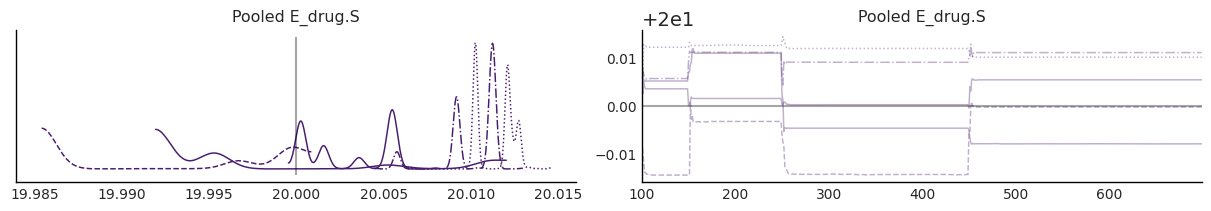

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning:

A valid var_name should be provided, found {'Pooled circulating.R Sigma', 'Log mean PK_central.V_c', 'Pooled transit.MTT', 'Pooled E_drug.S', 'Pooled proliferating.gamma', 'Log std. PK_central.V_c', 'Log mean circulating.R_0', 'Log std. circulating.R_0'} expected from {'Pooled PK_central.K_cl'}



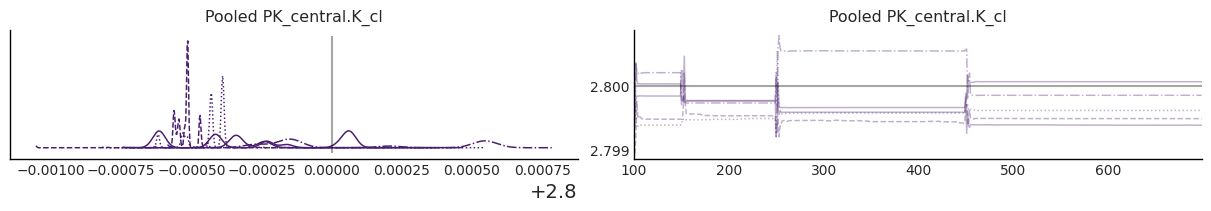

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning:

A valid var_name should be provided, found {'Pooled PK_central.K_cl', 'Pooled circulating.R Sigma', 'Pooled transit.MTT', 'Pooled E_drug.S', 'Pooled proliferating.gamma', 'Log mean circulating.R_0', 'Log std. circulating.R_0'} expected from {'Log mean PK_central.V_c', 'Log std. PK_central.V_c', 'PK_central.V_c'}



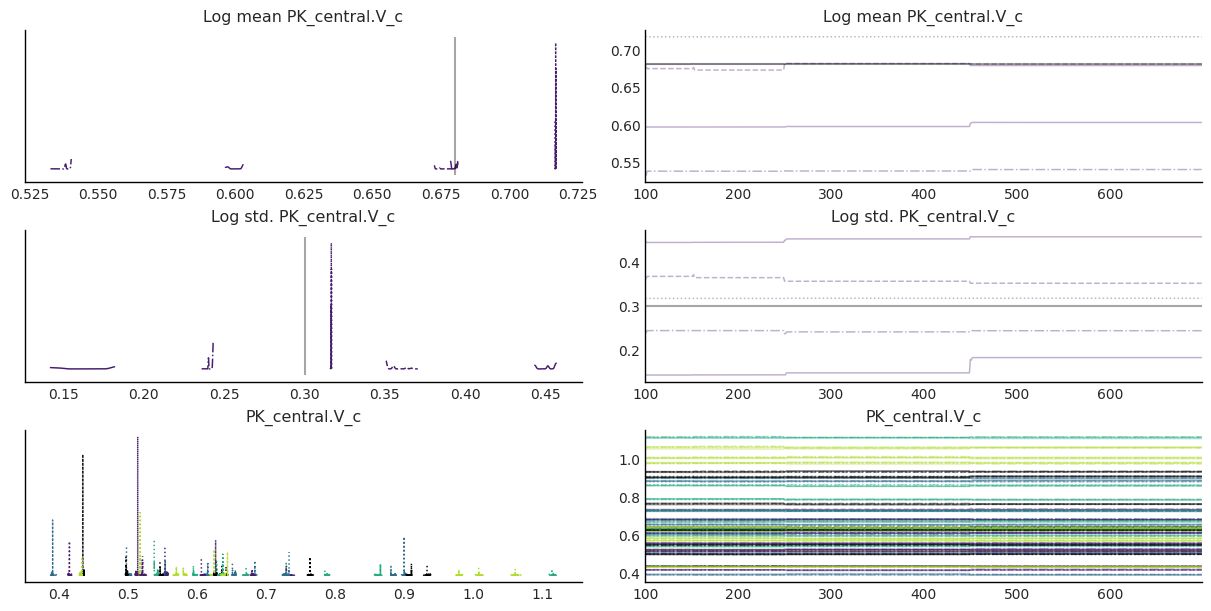

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning:

A valid var_name should be provided, found {'Pooled PK_central.K_cl', 'Pooled circulating.R Sigma', 'Log mean PK_central.V_c', 'Pooled transit.MTT', 'Pooled E_drug.S', 'Pooled proliferating.gamma', 'Log std. PK_central.V_c'} expected from {'Log mean circulating.R_0', 'Log std. circulating.R_0', 'circulating.R_0'}



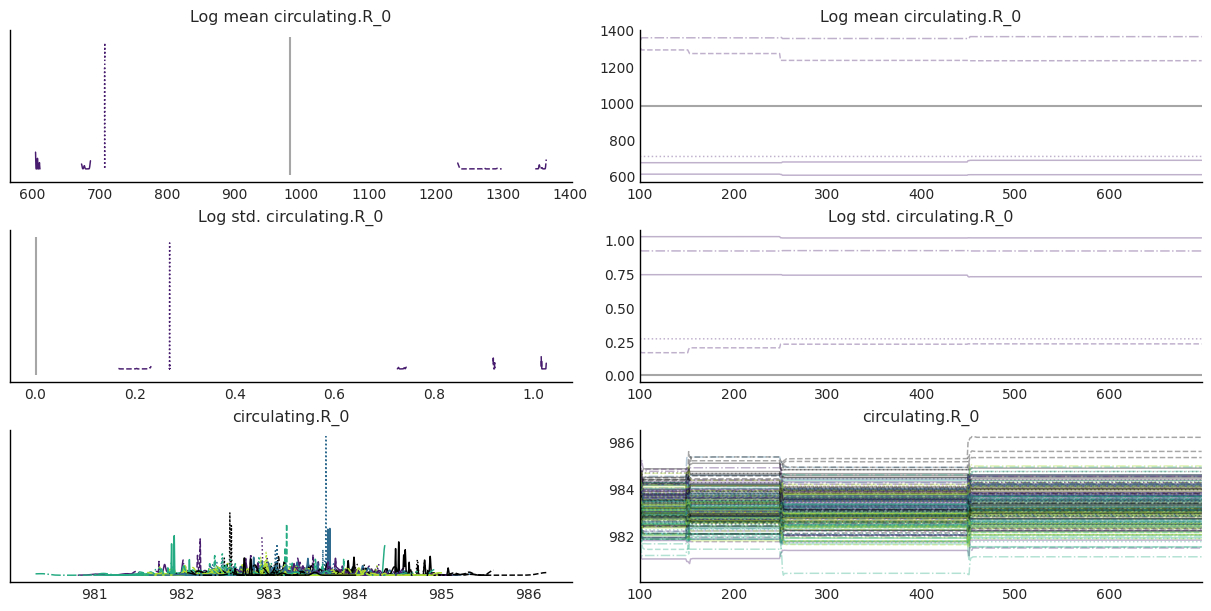

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning:

A valid var_name should be provided, found {'Pooled PK_central.K_cl', 'Pooled circulating.R Sigma', 'Log mean PK_central.V_c', 'Pooled transit.MTT', 'Pooled E_drug.S', 'Log std. PK_central.V_c', 'Log mean circulating.R_0', 'Log std. circulating.R_0'} expected from {'Pooled proliferating.gamma'}



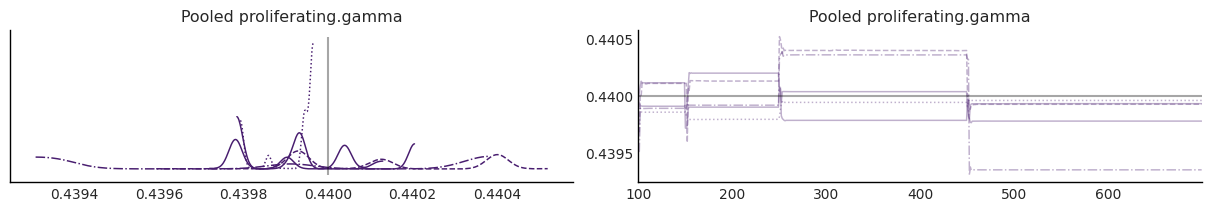

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning:

A valid var_name should be provided, found {'Pooled PK_central.K_cl', 'Pooled circulating.R Sigma', 'Log mean PK_central.V_c', 'Pooled E_drug.S', 'Pooled proliferating.gamma', 'Log std. PK_central.V_c', 'Log mean circulating.R_0', 'Log std. circulating.R_0'} expected from {'Pooled transit.MTT'}



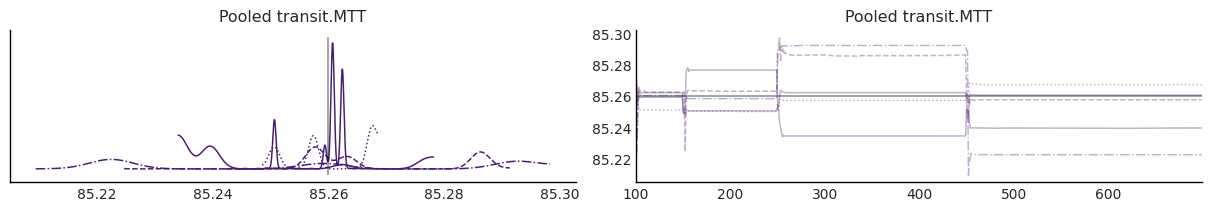

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning:

A valid var_name should be provided, found {'Pooled PK_central.K_cl', 'Log mean PK_central.V_c', 'Pooled transit.MTT', 'Pooled E_drug.S', 'Pooled proliferating.gamma', 'Log std. PK_central.V_c', 'Log mean circulating.R_0', 'Log std. circulating.R_0'} expected from {'Pooled circulating.R Sigma'}



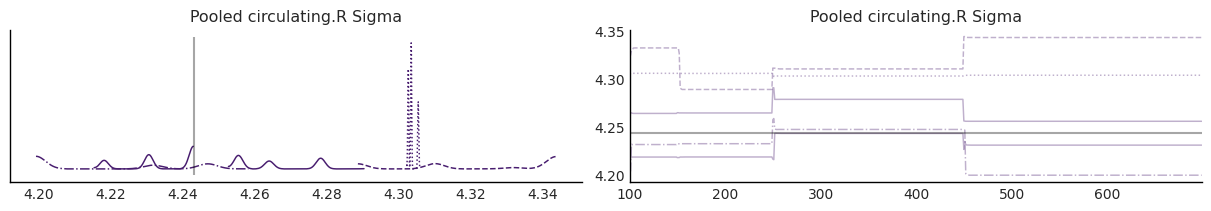

In [17]:
def graph_tansform(params_to_trans):
    trans_param = params_to_trans
    try:
        trans_param['Log mean '+param] = np.exp(trans_param['Log mean '+param])
    except KeyError:
        pass
    return trans_param

# Discard warmup iterations
# discard = max(len(posterior_samples.draw)-int(num_samples/n_runs), 1)
discard = max(100, 1)
main_samples = posterior_samples.drop_isel(draw=range(0, discard))

print("R-hat value:", az.rhat(main_samples))

for param in np.delete(PKPD_model.parameters(), [3, 4, 6]):
    az.plot_trace(
        main_samples,
        var_names=('.*'+param),
        filter_vars="regex",
        lines=lines,
        transform=graph_tansform
    )
    param_name = param.split('.')[-1]
    plt.savefig(
        image_file +
        "PD_" + drug + "/" +
        PD_pop_model_file + fixed_file +
        "MCMC_" + param_name + "_trace.svg"
    )
    plt.show()

az.plot_trace(main_samples, var_names=('.*Sigma'), filter_vars="regex", lines=lines)
plt.savefig(
    image_file +
    "PD_" + drug + "/" +
    PD_pop_model_file + fixed_file +
    "MCMC_noise_trace.svg"
)
plt.show()

In [ ]:
prev_pop_params = []
prev_ind_params = []
for var in posterior_samples.data_vars:
    last_sample = posterior_samples.sel({'draw':max(posterior_samples.draw)})[var]
    if 'individual' in last_sample.dims:
        prev_ind_params.append(last_sample.values)
    else:
        prev_pop_params.append(last_sample.values)
prev_pop_params = np.asarray(prev_pop_params).transpose()
prev_ind_params = np.asarray(prev_ind_params).transpose(1, 2, 0)
x = sampler.make_initial_point(
                n_runs, prev_pop_params, prev_ind_params.reshape((n_runs, -1))
            )
# sampler._initial_params

In [ ]:
# Visualise the results
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from math import floor

n_times = 1000
n_ids = 100  # number of ids to generate per sample for determining percentiles
n_samples_per = 100 # number of samples to select for determining percentiles

PK_time_span = df.loc[df["Observable"]=="PK_central.drug_concentration"]["Time"].max()
PD_time_span = df.loc[df["Observable"]=="circulating.R"]["Time"].max()
more_PK_times = np.linspace(
    start=0, stop=1.01*(PK_time_span-dose_time), num=n_times
)
more_PD_times = np.linspace(
    start=-dose_time, stop=1.01*(PD_time_span-dose_time), num=n_times
)

fig1 = make_subplots(rows=4, cols=3, shared_xaxes=True, shared_yaxes=True)
fig2 = make_subplots(rows=4, cols=3, shared_xaxes=True, shared_yaxes=True)

non_pop_parameters = np.insert(PKPD_actual_params[1], 6, 0.0)
mean_samples = main_samples.mean(dim="draw")
per_samples = az.extract(main_samples, num_samples=n_samples_per)

avg_inferred = np.empty((n_runs, len(non_pop_parameters)))
individual_parameters = np.empty((n_runs, len(non_pop_parameters), n_ids_data))

for x in all_params:
    if x == "sigma_PK":
        param_name = "PK_central.drug_concentration Sigma"
    elif x == "sigma_PD":
        param_name = "circulating.R Sigma"
    else:
        param_name = PKPD_model.parameters()[PKPD_param_numbers[x]]

    if x in mixed_effect_params:
        avg_inferred[:, mixed_effect_params[x]] = np.exp(mean_samples["Log mean " + param_name])
        individual_parameters[:, mixed_effect_params[x], :] = mean_samples[param_name]
        per_samples = per_samples.drop_vars([param_name])
        
    elif x in fixed_params:
        fix_value = non_pop_parameters[fixed_params[x][1]]
        avg_inferred[:, fixed_params[x][1]] = fix_value
        individual_parameters[:, fixed_params[x][1], :] = fix_value
    
    else:
        avg_value = mean_samples["Pooled " + param_name]
        avg_inferred[:, PKPD_param_numbers[x]] = avg_value
        individual_parameters[:, PKPD_param_numbers[x], :] = np.transpose([avg_value]*n_ids_data)

for run in range(0, n_runs):
    row = floor(run/3)+1
    col = run%3+1
    print(row, col)

    # sampled_params = main_samples.sel(chain=[run])
    run_mean_samples = mean_samples.sel(chain=[run])
    run_per_samples = per_samples.sel(chain=[run])

    run_avg_inferred = avg_inferred[run]
    run_individual_parameters = individual_parameters[run]
    
    per_ind_params = np.empty((0,len(run_per_samples.data_vars)-len(mixed_effect_params)))
    for s in run_per_samples.coords['draw']:
        param = np.asarray(run_per_samples.sel(draw=s).to_array()).flatten()
        per_ind_params = np.concatenate((per_ind_params, population_model.sample(
            parameters=param,
            n_samples=n_ids
        )), axis = 0)

    for x in fixed_params:
        fix_value = non_pop_parameters[fixed_params[x][1]]
        per_ind_params = np.insert(per_ind_params, fixed_params[x][1], fix_value, axis=1)

    # Plot the population model for each dose
    for i, group in enumerate(dose_groups):
        # Simulate and Plot from the population mean
        amt = dose_amts[i]
        PKPD_model.set_dosing_regimen(amt, start=dose_time, period=0)
        more_PK_values = PKPD_model.simulate(
            run_avg_inferred[:-2],
            more_PK_times+dose_time
        )[0]
        fig1.add_trace(
            go.Scatter(
                x=more_PK_times,
                y=more_PK_values,
                mode='lines',
                line=dict(color=ind_colours[i, int(n_ids_data/2)], dash='dash'),
                name='Typical simulation',
                legendgroup= group,
                # legendgrouptitle = {'text': 'Dose '+str(group)+' '+dose_unit},
                showlegend=False
            ),
            row=row,
            col=col
        )
        more_PD_values = PKPD_model.simulate(run_avg_inferred[:-2], more_PD_times)[1]
        fig2.add_trace(
            go.Scatter(
                x=more_PD_times,
                y=more_PD_values,
                mode='lines',
                line=dict(color=ind_colours[i, int(n_ids_data/2)], dash='dash'),
                name='Typical simulation',
                legendgroup= group,
                legendgrouptitle = {'text': 'Dose '+str(group)+' '+dose_unit},
                showlegend=False
            ),
            row=row,
            col=col
        )
        for j, patient in enumerate(df.loc[df['Dose group']==group]['ID'].unique()):
            PKPD_model.set_dosing_regimen(
                df.loc[(df['ID']==patient) & df['Observable'].isna()]['Dose'].iat[0], 
                start=dose_time,
                period=0
            )
            pat_param = run_individual_parameters[:, j]
            if group!=0.0:
                individual_PK_values = PKPD_model.simulate(
                    pat_param[:-2],
                    more_PK_times+dose_time
                )[0]
                fig1.add_trace(
                    go.Scatter(
                        x=more_PK_times,
                        y=individual_PK_values,
                        name='Individual simulation',
                        legendgroup = group,
                        showlegend= False,
                        mode="lines",
                        line=go.scatter.Line(color=ind_colours[i, j], width=0.5),
                        opacity=0.5,
                    ),
                    row=row,
                    col=col
                )
                x_data = df_PK_graph.loc[df_PK_graph['ID']==patient][x_label]-dose_time
                y_data = df_PK_graph.loc[df_PK_graph['ID']==patient][PK_y_label]
                fig1.add_trace(go.Scatter(
                    x=x_data,
                    y=y_data,
                    mode='markers',
                    marker_color=ind_colours[i, j],
                    name='Data',
                    legendgroup = group,
                    showlegend = False,
                ),row=row, col=col)
            individual_PD_values = PKPD_model.simulate(
                pat_param[:-2],
                more_PD_times+dose_time
            )[1]
            fig2.add_trace(
                go.Scatter(
                    x=more_PD_times,
                    y=individual_PD_values,
                    name='Individual simulation',
                    legendgroup = group,
                    showlegend= False,
                    mode="lines",
                    line=go.scatter.Line(color=ind_colours[i, j], width=0.5),
                    opacity=0.5,
                ),
                row=row,
                col=col
            )
            x_data = df_PD_graph.loc[df_PD_graph['ID']==patient][x_label]-dose_time
            y_data = df_PD_graph.loc[df_PD_graph['ID']==patient][PD_y_label]
            fig2.add_trace(
                go.Scatter(
                    x=x_data,
                    y=y_data,
                    mode='markers',
                    marker_color=ind_colours[i, j],
                    name='Data',
                    legendgroup = group,
                    showlegend = False,
                ),
                row=row,
                col=col
            )
            
        PKPD_model.set_dosing_regimen(amt, start=dose_time, period=0)
        if group!=0.0:
            # Find 5th to 95th percentile of population distribution
            PK_simulations = np.empty(shape=(len(per_ind_params), n_times))
            PD_simulations = np.empty(shape=(len(per_ind_params), n_times))
            for idd, ind_param in enumerate(per_ind_params):
                # avg_inferred = np.insert(avg_inferred, 1, PK_opt_params[0]) # Clearance
                ind_sim = PKPD_model.simulate(
                    ind_param[:-2],
                    more_PK_times+dose_time
                )[0]
                PK_simulations[idd] = PK_noise_model.sample(
                    ind_param[-2:-1], ind_sim)[:, 0]
                ind_sim = PKPD_model.simulate(
                    ind_param[:-2],
                    more_PD_times + dose_time
                )[1]
                PD_simulations[idd] = PD_noise_model.sample(
                    ind_param[-1:], ind_sim)[:, 0]
            
            # Plot the variability
            fifth = np.percentile(PK_simulations, q=5, axis=0)
            ninety_fifth = np.percentile(PK_simulations, q=95, axis=0)
            fig1.add_trace(
                go.Scatter(
                    x=np.hstack([more_PK_times, more_PK_times[::-1]]),
                    y=np.hstack([fifth, ninety_fifth[::-1]]),
                    line=dict(
                        width=0,
                        color=ind_colours[i, int(n_ids_data/2)]
                    ),
                    fill='toself',
                    name='Population model',
                    text=r"90% bulk probability",
                    hoverinfo='text',
                    legendgroup= group,
                    showlegend=False
                ),
                row=row,
                col=col
            )
            
        # Plot the variability
        fifth = np.percentile(PD_simulations, q=5, axis=0)
        ninety_fifth = np.percentile(PD_simulations, q=95, axis=0)
        fig2.add_trace(
            go.Scatter(
                x=np.hstack([more_PD_times, more_PD_times[::-1]]),
                y=np.hstack([fifth, ninety_fifth[::-1]]),
                line=dict(
                    width=0,
                    color=ind_colours[i, int(n_ids_data/2)]
                ),
                fill='toself',
                name='Population model',
                text=r"90% bulk probability",
                hoverinfo='text',
                legendgroup= group,
                showlegend=False
            ),
            row=row,
            col=col
        )
    if run == 0:
        axis = ''
    else:
        axis = str(run+1)
    fig1['layout']['yaxis'+axis].update(type="log", minor=dict(dtick='D1', showgrid=True), dtick = 1, title_text = PK_y_label)
    fig1['layout']['xaxis'+axis].update(dtick = 1, title_text = x_label)
    fig2['layout']['yaxis'+axis].update(dtick = 250, title_text = PD_y_label)
    fig2['layout']['xaxis'+axis].update(dtick = 72, minor=dict(dtick=24, showgrid=True), title_text = x_label)

fig1.update_layout(
    width=1100,
    height=750,
    template='plotly_white'
)
fig2.update_layout(
    width=1100,
    height=750,
    template='plotly_white'
)

fig1.write_image(image_file + "PKPD_"+drug+"/"+PD_pop_model_file+fixed_file+"_PK_MCMC_runs.svg")
fig2.write_image(image_file + "PKPD_"+drug+"/"+PD_pop_model_file+fixed_file+"_PD_MCMC_runs.svg")
fig1.show()
fig2.show()

In [ ]:
fig = make_subplots(rows=1, cols=2)

all_mean_samples = mean_samples.mean(dim=["chain"])
all_avg_inferred = np.mean(avg_inferred, axis = 0)
all_individual_parameters = np.mean(individual_parameters, axis = 0)

per_ind_params = np.empty((0,len(per_samples.data_vars)-len(mixed_effect_params)))
for s in per_samples.coords['sample']:
    param = np.asarray(per_samples.sel(sample=s).to_array()).flatten()
    per_ind_params = np.concatenate((per_ind_params, population_model.sample(
        parameters=param,
        n_samples=n_ids
    )), axis = 0)

for x in fixed_params:
    fix_value = non_pop_parameters[fixed_params[x][1]]
    per_ind_params = np.insert(per_ind_params, fixed_params[x][1], fix_value, axis=1)

# Plot the population model for each dose
for i, group in enumerate(dose_groups):
    # Simulate and Plot from the population mean
    amt = dose_amts[i]
    PKPD_model.set_dosing_regimen(amt, start=dose_time, period=0)
    more_PK_values = PKPD_model.simulate(
        all_avg_inferred[:-2],
        more_PK_times+dose_time
    )[0]
    fig.add_trace(
        go.Scatter(
            x=more_PK_times,
            y=more_PK_values,
            mode='lines',
            line=dict(
                color=ind_colours[i, int(n_ids_data/2)],
                dash='dash'
            ),
            name='Typical simulation',
            legendgroup=group,
            # legendgrouptitle = {'text': 'Dose '+str(group)+' '+dose_unit},
            showlegend=False
        ),
        row=1,
        col=1
    )
    more_PD_values = PKPD_model.simulate(all_avg_inferred[:-2], more_PD_times)[1]
    fig.add_trace(
        go.Scatter(
            x=more_PD_times,
            y=more_PD_values,
            mode='lines',
            line=dict(
                color=ind_colours[i, int(n_ids_data/2)],
                dash='dash'
            ),
            name='Typical simulation',
            legendgroup=group,
            legendgrouptitle={'text': 'Dose '+str(group)+' '+dose_unit},
            showlegend=False
        ),
        row=1,
        col=2
    )
    for j, patient in enumerate(df.loc[df['Dose group'] == group]['ID'].unique()):
        PKPD_model.set_dosing_regimen(
            ind_dose['Dose'].iat[0],
            start=dose_time,
            period=0
        )
        pat_params = all_individual_parameters[:, j]
        if group!=0.0:
            individual_PK_values = PKPD_model.simulate(
                pat_params[:-2],
                more_PK_times+dose_time
            )[0]
            fig.add_trace(
                go.Scatter(
                    x=more_PK_times,
                    y=individual_PK_values,
                    name='Individual simulation',
                    legendgroup=group,
                    showlegend=False,
                    mode="lines",
                    line=go.scatter.Line(
                        color=ind_colours[i, j],
                        width=0.5
                    ),
                    opacity=0.5,
                ),
                row=1,
                col=1
            )
            x_data = df_PK_graph.loc[df_PK_graph['ID']==patient][x_label]-dose_time
            y_data = df_PK_graph.loc[df_PK_graph['ID']==patient][PK_y_label]
            fig.add_trace(go.Scatter(
                x=x_data,
                y=y_data,
                mode='markers',
                marker_color=ind_colours[i, j],
                name='Data',
                legendgroup=group,
                showlegend=False,
            ), row=1, col=1)
        individual_PD_values = PKPD_model.simulate(
            pat_params[:-2],
            more_PD_times+dose_time
        )[1]
        fig.add_trace(
            go.Scatter(
                x=more_PD_times,
                y=individual_PD_values,
                name='Individual simulation',
                legendgroup=group,
                showlegend=False,
                mode="lines",
                line=go.scatter.Line(
                    color=ind_colours[i, j],
                    width=0.5
                ),
                opacity=0.5,
            ),
            row=1,
            col=2
        )
        x_data = df_PD_graph.loc[df_PD_graph['ID'] == patient][x_label]-dose_time
        y_data = df_PD_graph.loc[df_PD_graph['ID'] == patient][PD_y_label]
        fig.add_trace(
            go.Scatter(
                x=x_data,
                y=y_data,
                mode='markers',
                marker_color=ind_colours[i, j],
                name='Data',
                legendgroup=group,
                showlegend=False,
            ),
            row=1,
            col=2
        )

    PKPD_model.set_dosing_regimen(amt, start=dose_time, period=0)
    if group != 0.0:
        # Find 5th to 95th percentile of population distribution
        PK_simulations = np.empty(shape=(len(per_ind_params), n_times))
        PD_simulations = np.empty(shape=(len(per_ind_params), n_times))
        for idd, ind_param in enumerate(per_ind_params):
            ind_sim = PKPD_model.simulate(
                ind_param[:-2],
                more_PK_times+dose_time
            )[0]
            PK_simulations[idd] = PK_noise_model.sample(
                ind_param[-2:-1], ind_sim)[:, 0]
            ind_sim = PKPD_model.simulate(
                ind_param[:-2],
                more_PD_times + dose_time
            )[1]
            PD_simulations[idd] = PD_noise_model.sample(
                ind_param[-1:], ind_sim
            )[:, 0]

        # Plot the variability
        fifth = np.percentile(PK_simulations, q=5, axis=0)
        ninety_fifth = np.percentile(PK_simulations, q=95, axis=0)
        fig.add_trace(
            go.Scatter(
                x=np.hstack([more_PK_times, more_PK_times[::-1]]),
                y=np.hstack([fifth, ninety_fifth[::-1]]),
                line=dict(
                    width=0,
                    color=ind_colours[i, int(n_ids_data/2)]
                ),
                fill='toself',
                name='Population model',
                text=r"90% bulk probability",
                hoverinfo='text',
                legendgroup=group,
                showlegend=False
            ),
            row=1,
            col=1
        )

    # Plot the variability
    fifth = np.percentile(PD_simulations, q=5, axis=0)
    ninety_fifth = np.percentile(PD_simulations, q=95, axis=0)
    fig.add_trace(
        go.Scatter(
            x=np.hstack([more_PD_times, more_PD_times[::-1]]),
            y=np.hstack([fifth, ninety_fifth[::-1]]),
            line=dict(
                width=0,
                color=ind_colours[i, int(n_ids_data/2)]
            ),
            fill='toself',
            name='Population model',
            text=r"90% bulk probability",
            hoverinfo='text',
            legendgroup=group,
            showlegend=False
        ),
        row=1,
        col=2
    )
fig['layout']['yaxis'].update(
    type="log", minor=dict(dtick='D1', showgrid=True), dtick=1, title_text=PK_y_label
)
fig['layout']['xaxis'].update(dtick=1, title_text=x_label)
fig['layout']['yaxis2'].update(dtick=250, title_text=PD_y_label)
fig['layout']['xaxis2'].update(
    dtick=72, minor=dict(dtick=24, showgrid=True), title_text=x_label
)

fig.update_layout(
    width=1200,
    height=500,
    template='plotly_white'
)

fig.write_image(image_file + "PKPD_"+drug+"/"+PD_pop_model_file+fixed_file+"_MCMC_graph.svg")
fig.show()

In [ ]:
posterior_samples.close()

#### Model Selection

In [ ]:
import xarray as xr
import arviz as az
log_likelihood = problem.get_log_posterior().get_log_likelihood()

In [ ]:
class PointwiseLikelihood():

    def __init__(self, log_likelihood, data) -> None:
        self.log_likelihood = log_likelihood
        self.data = data
        self.ids = np.asarray(data["ID"].unique())
        self.n_obs_points = len(data.loc[(data["ID"]==self.ids[0]) & data["Value"].notna()])
        self.reset_pwll()

    def reset_pwll(self):
        self.pwlls = np.empty((0, len(self.ids), self.n_obs_points))

    def add_pwll(self, parameters):
        pwll = np.asarray(self.log_likelihood.compute_pointwise_ll(parameters, per_individual=False))
        pwll = pwll.reshape((1, len(self.ids), self.n_obs_points))
        self.pwlls = np.append(self.pwlls, pwll, axis=0)

    def create_pwlls(self, samples):
        self.reset_pwll()
        # add pointwise likelihood for each parameter sample
        for param in samples:
            self.add_pwll(param)
            # check if it agrees with loglikelihood
            sum_pw = np.sum(self.pwlls[-1])
            ll = self.log_likelihood(param)
            if np.isinf(sum_pw):
                if not np.isinf(sum_pw):
                    raise ValueError("pointwise log-likelihoods do not sum to log-likelihood, "+str(sum_pw)+"!="+str(ll))
            elif np.abs((sum_pw-ll)/ll) > 1e-2:
                    raise ValueError("pointwise log-likelihoods do not sum to log-likelihood, "+str(sum_pw)+"!="+str(ll))
        return self.pwlls
    
    def get_inference_data(self, samples):
        posterior = az.convert_to_inference_data(samples, group='posterior')
        
        obs_df = df.copy()
        obs_df = obs_df.dropna(subset=['Observable']).sort_values(['ID', 'Time', 'Observable'])
        obs_df["Points"] = (
            obs_df['Observable'].astype(str)+
            np.asarray([" - "]*len(obs_df)).astype(str) +
            obs_df['Time'].astype(str)
        )
        obs_df = obs_df[["ID", "Points", "Value"]]
        obs_points = obs_df["Points"]
        obs_df.set_index(["ID", "Points"])
        observed = az.convert_to_inference_data(
            obs_df.to_xarray(),
            group='observed_data'
        )

        const_df = df.copy()
        const_df = const_df.dropna(subset=['Dose']).sort_values(['ID', 'Time'])
        const_df = const_df[['ID', "Time", "Dose group", "Duration", "Dose"]]
        const_df.set_index(["ID", "Time"])
        constant = az.convert_to_inference_data(
            obs_df.to_xarray(),
            group='constant_data'
        )
        ids = samples.coords["individual"]
        if isinstance(samples, (xr.Dataset, az.InferenceData)):
            pop_param_names = problem.get_parameter_names()
            pop_samples = az.extract(posterior_samples, var_names=pop_param_names)
            ind_samples = az.extract(posterior_samples, var_names=['~' + x for x in pop_param_names])
            sample_coords = pop_samples.coords["sample"]
            if isinstance(ind_samples, xr.Dataset):
                ind_samples = ind_samples.to_array()
            if isinstance(pop_samples, xr.Dataset):
                pop_samples = pop_samples.to_array()
            numpy_samples = np.concatenate((np.asarray(ind_samples), np.asarray(pop_samples))).transpose()
        else:
            numpy_samples = np.asarray(samples)
            sample_coords = np.arange(numpy_samples.shape[0])
        pointwise = {"pointwise log-likelihooods": np.asarray(np.split(self.create_pwlls(numpy_samples), len(samples.coords["draw"]), axis=0))}
        print(pointwise["pointwise log-likelihooods"].shape)
        coords = {"individual": ids, "Points": obs_points.unique()}
        dims = {"pointwise log-likelihooods": ["individual", "Points"]}
        likelihood = az.convert_to_inference_data(pointwise, coords=coords, dims=dims, group='log_likelihood')

        inference_data = az.concat(likelihood, posterior, observed, constant)
        return inference_data

In [ ]:
start_point = [V_c_approx]*(n_ids_data*3) + [
    0.5*PD_bounds[0,0]+0.5*PD_bounds[1,0],      # S
    cl_approx,                                 # Clearance
    np.log(V_c_approx),                         # Log mean of central volume
    0.1,                                        # Log std. of central volume
#     cl_approx*np.random.random(),             # Periferal compartment transfer
#     V_c_approx*np.random.random(),            # Periferal compartment volume
    R_0_approx,                                 # R_0
    1,                                          # gamma
    MTT_approx,                                 # MTT
#     0.1,                                      # PK Noise parameter
    0.1*R_0_approx*np.random.random(),          # PD Noise parameter
]

pw_ll = PointwiseLikelihood(log_likelihood, df)
pw_ll.add_pwll(start_point)
print(np.sum(pw_ll.pwlls), log_likelihood(start_point))

In [ ]:
# Acquire Pointwise posterior samples
import xarray as xr
import arviz as az
model_types = ["pop_V_c", "pop_V_c_R_0", "fixed_effects"]
num_samples = 1500  # number of wanted final samples from all runs
compare_dict = {}


# For mixed effects model
for model_type in model_types:
    print('----------------------------------------------------------------------------------')
    print(model_type)
    posterior_samples = xr.open_dataset(PD_data_file+drug+model_type+fixed_file+"samples.nc").load()
    # ind_samples = az.extract(posterior_samples, var_names="PK_central.V_c")
    # pop_samples = az.extract(posterior_samples, var_names="~PK_central.V_c")
    # samples = np.concatenate((np.asarray(ind_samples), np.asarray(pop_samples.to_array())))
    # for i, param_name in enumerate(problem.get_parameter_names()):
    #     mean_samples = np.min(samples, axis=1)
    #     print(param_name, mean_samples[i+45])
    inference_data = pw_ll.get_inference_data(posterior_samples)
    posterior_samples.close()
    compare_dict[model_type] = inference_data

# For fixed effects:
# model_type = "Fixed effects"
# print('----------------------------------------------------------------------------------')
# print(model_type)
# samples = np.asarray(
#     pints.io.load_samples('../Data_and_parameters/PD_sim/MCMC_'+'add'+'_samples_chain', n=3)
# )[:,-int(num_samples/samples.shape[0]):, :]
# pointwise_chains = np.load('../Data_and_parameters/PD_sim/MCMC_'+'add'+'_pointloglike.npz')
# pointwise = []
# for chain in pointwise_chains:
#     pointwise.append(pointwise_chains[chain])
# pointwise = np.asarray(pointwise)[:,-int(num_samples/samples.shape[0]):, :]
# likelihood = az.convert_to_inference_data(pointwise, group='log_likelihood')
# posterior = az.convert_to_inference_data(samples, group='posterior') 
# inference_data = az.concat(likelihood, posterior, observed)
# model_types.append(model_type)

# compare_dict[model_type] = inference_data
inference_data

In [ ]:
posterior_samples.close()

In [ ]:
compare_dict = dict(zip(model_types, inference_data_sets))